<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Extension/blob/main/Bank_Marketing_Transductive_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##STAT 561 Project Extension - Bank Marketing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C5K306):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)



{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [4]:
X

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married        NaN      no     1506     yes   no   
4       33           NaN    single        NaN      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day_of_week month  duration  campaign  pdays  previous  \
0            NaN            5   may       261         1     -1         0   
1            NaN            5   may       151         1     -1         0   
2            NaN            5   may        76         1     -1         0   
3            NaN            5   may        92         1     -1         0   
4            NaN            5   may       198         1     -1         0   
...          ...          ...   ...       ...       ...    ...       ...   
45206   cellular           17   nov       977         3     -1         0   
45207   cellular           17   nov       456         2     -1         0   
45208   cellular           17   nov      1127         5    184         3   
45209  telephone           17   nov       508         4     -1         0   
45210   cellular           17   nov       361         2    188        11   

      poutcome  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
45206      NaN  
45207      NaN  
45208  success  
45209      NaN  
45210    other  

[45211 rows x 16 columns]

In [5]:
y

y
0       no
1       no
2       no
3       no
4       no
...    ...
45206  yes
45207  yes
45208  yes
45209   no
45210   no

[45211 rows x 1 columns]

In [6]:
for i in range(len(X.columns)):
  print(X.columns[i])
  print(X.iloc[:, i].unique())
  print('------------------')

age
[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
------------------
job
['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
------------------
marital
['married' 'single' 'divorced']
------------------
education
['tertiary' 'secondary' nan 'primary']
------------------
default
['no' 'yes']
------------------
balance
[ 2143    29     2 ...  8205 14204 16353]
------------------
housing
['yes' 'no']
------------------
loan
['no' 'yes']
------------------
contact
[nan 'cellular' 'telephone']
------------------
day_of_week
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
------------------
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

In [7]:
y['y'].unique()

array(['no', 'yes'], dtype=object)

In [8]:
X_numeric = pd.DataFrame()

## Age:
X_numeric['age'] = X['age']

## Working class:
X_numeric['job'] = X['job']
X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student'],
                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True)


## Marital:
X_numeric['marital'] = X['marital']
X_numeric['marital'].replace(['single', 'married', 'divorced'],
                                    [0, 1, 2], inplace=True)

## Education:
X_numeric['education'] = X['education']
X_numeric['education'].replace(['primary', 'secondary', 'tertiary'],
                                    [0, 1, 2], inplace=True)


## Credit Default:
X_numeric['default'] = X['default']
X_numeric['default'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Balance:
X_numeric['balance'] = X['balance']


## Housing:
X_numeric['housing'] = X['housing']
X_numeric['housing'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)


## Loan:
X_numeric['loan'] = X['loan']
X_numeric['loan'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Contact:
X_numeric['contact'] = X['contact']
X_numeric['contact'].replace([np.nan, 'cellular', 'telephone'],
                                    [0, 1, 2], inplace=True)


## Day of week:
X_numeric['day_of_week'] = X['day_of_week']


## Month:
X_numeric['month'] = X['month']
X_numeric['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], inplace=True)


## Duration:
X_numeric['duration'] = X['duration']

## Campaign:
X_numeric['campaign'] = X['campaign']


## Pdays:
X_numeric['pdays'] = X['pdays']
# X_numeric['pdays'].replace([-1], [np.nan], inplace=True)

## Previous:
X_numeric['previous'] = X['previous']

## Poutcome:
X_numeric['poutcome'] = X['poutcome']
X_numeric['poutcome'].replace([np.nan, 'failure', 'success', 'other'],
                                    [0, 1, 2, 3], inplace=True)





## ---------------------- Response variable y: --------------------

## Income:
y_numeric = pd.DataFrame()
y_numeric['Y'] = y['y']
y_numeric['Y'].replace(['no', 'yes'],
                          [0, 1], inplace=True)

X_numeric





<ipython-input-8-ece2c1f564e2>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
<ipython-input-8-ece2c1f564e2>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_numeric['job'].replace(['management', 'tec

age  job  marital  education  default  balance  housing  loan  contact  \
0       58  0.0        1        2.0        0     2143        1     0        0   
1       44  1.0        0        1.0        0       29        1     0        0   
2       33  2.0        1        1.0        0        2        1     1        0   
3       47  3.0        1        NaN        0     1506        1     0        0   
4       33  NaN        0        NaN        0        1        0     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
45206   51  1.0        1        2.0        0      825        0     0        1   
45207   71  4.0        2        0.0        0     1729        0     0        1   
45208   72  4.0        1        1.0        0     5715        0     0        1   
45209   57  3.0        1        1.0        0      668        0     0        2   
45210   37  2.0        1        1.0        0     2971        0     0        1   

       day_of_week  month  duration  campaign  pdays  previous  poutcome  
0                5      4       261         1     -1         0         0  
1                5      4       151         1     -1         0         0  
2                5      4        76         1     -1         0         0  
3                5      4        92         1     -1         0         0  
4                5      4       198         1     -1         0         0  
...            ...    ...       ...       ...    ...       ...       ...  
45206           17     10       977         3     -1         0         0  
45207           17     10       456         2     -1         0         0  
45208           17     10      1127         5    184         3         2  
45209           17     10       508         4     -1         0         0  
45210           17     10       361         2    188        11         3  

[45211 rows x 16 columns]

In [9]:
y_numeric['Y']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: Y, Length: 45211, dtype: int64

In [10]:
y_numeric['Y'].value_counts()

Y
0    39922
1     5289
Name: count, dtype: int64

In [11]:
data_total = pd.concat([X_numeric, y_numeric], axis=1)

data_total = data_total.dropna().reset_index(drop=True)


data_total

age  job  marital  education  default  balance  housing  loan  contact  \
0       58  0.0        1        2.0        0     2143        1     0        0   
1       44  1.0        0        1.0        0       29        1     0        0   
2       33  2.0        1        1.0        0        2        1     1        0   
3       35  0.0        1        2.0        0      231        1     0        0   
4       28  0.0        0        2.0        0      447        1     1        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
43188   51  1.0        1        2.0        0      825        0     0        1   
43189   71  4.0        2        0.0        0     1729        0     0        1   
43190   72  4.0        1        1.0        0     5715        0     0        1   
43191   57  3.0        1        1.0        0      668        0     0        2   
43192   37  2.0        1        1.0        0     2971        0     0        1   

       day_of_week  month  duration  campaign  pdays  previous  poutcome  Y  
0                5      4       261         1     -1         0         0  0  
1                5      4       151         1     -1         0         0  0  
2                5      4        76         1     -1         0         0  0  
3                5      4       139         1     -1         0         0  0  
4                5      4       217         1     -1         0         0  0  
...            ...    ...       ...       ...    ...       ...       ... ..  
43188           17     10       977         3     -1         0         0  1  
43189           17     10       456         2     -1         0         0  1  
43190           17     10      1127         5    184         3         2  1  
43191           17     10       508         4     -1         0         0  0  
43192           17     10       361         2    188        11         3  0  

[43193 rows x 17 columns]

In [12]:
X = data_total.iloc[:, :-1]
y = data_total.iloc[:,-1]
y

0        0
1        0
2        0
3        0
4        0
        ..
43188    1
43189    1
43190    1
43191    0
43192    0
Name: Y, Length: 43193, dtype: int64

In [13]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [14]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
43188  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
43189  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
43190  0.701299  0.4  0.5  0.5  0.0  0.124689  0.0  0.0  0.5  0.533333   
43191  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   
43192  0.246753  0.2  0.5  0.5  0.0  0.099777  0.0  0.0  0.5  0.533333   

             10        11        12        13        14        15  Y  
0      0.363636  0.053070  0.000000  0.000000  0.000000  0.000000  0  
1      0.363636  0.030704  0.000000  0.000000  0.000000  0.000000  0  
2      0.363636  0.015453  0.000000  0.000000  0.000000  0.000000  0  
3      0.363636  0.028264  0.000000  0.000000  0.000000  0.000000  0  
4      0.363636  0.044124  0.000000  0.000000  0.000000  0.000000  0  
...         ...       ...       ...       ...       ...       ... ..  
43188  0.909091  0.198658  0.035088  0.000000  0.000000  0.000000  1  
43189  0.909091  0.092721  0.017544  0.000000  0.000000  0.000000  1  
43190  0.909091  0.229158  0.070175  0.212156  0.010909  0.666667  1  
43191  0.909091  0.103294  0.052632  0.000000  0.000000  0.000000  0  
43192  0.909091  0.073404  0.017544  0.216743  0.040000  1.000000  0  

[43193 rows x 17 columns]

In [15]:
y.value_counts()

Y
0    38172
1     5021
Name: count, dtype: int64

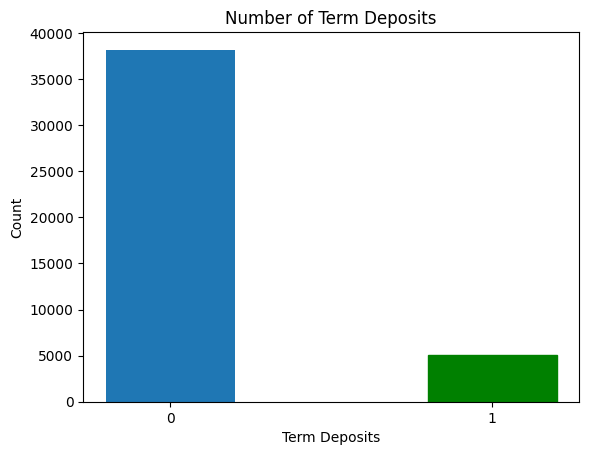

In [17]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Term Deposits")
plt.ylabel("Count")
plt.title("Number of Term Deposits")
plt.show()

In [18]:
data_total

age  job  marital  education  default  balance  housing  loan  contact  \
0       58  0.0        1        2.0        0     2143        1     0        0   
1       44  1.0        0        1.0        0       29        1     0        0   
2       33  2.0        1        1.0        0        2        1     1        0   
3       35  0.0        1        2.0        0      231        1     0        0   
4       28  0.0        0        2.0        0      447        1     1        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
43188   51  1.0        1        2.0        0      825        0     0        1   
43189   71  4.0        2        0.0        0     1729        0     0        1   
43190   72  4.0        1        1.0        0     5715        0     0        1   
43191   57  3.0        1        1.0        0      668        0     0        2   
43192   37  2.0        1        1.0        0     2971        0     0        1   

       day_of_week  month  duration  campaign  pdays  previous  poutcome  Y  
0                5      4       261         1     -1         0         0  0  
1                5      4       151         1     -1         0         0  0  
2                5      4        76         1     -1         0         0  0  
3                5      4       139         1     -1         0         0  0  
4                5      4       217         1     -1         0         0  0  
...            ...    ...       ...       ...    ...       ...       ... ..  
43188           17     10       977         3     -1         0         0  1  
43189           17     10       456         2     -1         0         0  1  
43190           17     10      1127         5    184         3         2  1  
43191           17     10       508         4     -1         0         0  0  
43192           17     10       361         2    188        11         3  0  

[43193 rows x 17 columns]

In [19]:
data_total.iloc[:, 3].value_counts()

education
1.0    23131
2.0    13262
0.0     6800
Name: count, dtype: int64

In [20]:
data2.iloc[:, 3].value_counts()

3
0.5    23131
1.0    13262
0.0     6800
Name: count, dtype: int64

# Splitting for Source and Target Domains:


# Full Dataset:

Grouping by 'International': domestic students are source data, international students are target data

In [21]:
data_S = data2[data2.iloc[:,3] > 0.4].reset_index(drop=True)  ## Source domain and classification - Secondary/Tertiary education
data_T = data2[data2.iloc[:,3] <= 0.4].reset_index(drop=True)  ## Target domain and classification - Primary education

In [22]:
data_S

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
36388  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
36389  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
36390  0.701299  0.4  0.5  0.5  0.0  0.124689  0.0  0.0  0.5  0.533333   
36391  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   
36392  0.246753  0.2  0.5  0.5  0.0  0.099777  0.0  0.0  0.5  0.533333   

             10        11        12        13        14        15  Y  
0      0.363636  0.053070  0.000000  0.000000  0.000000  0.000000  0  
1      0.363636  0.030704  0.000000  0.000000  0.000000  0.000000  0  
2      0.363636  0.015453  0.000000  0.000000  0.000000  0.000000  0  
3      0.363636  0.028264  0.000000  0.000000  0.000000  0.000000  0  
4      0.363636  0.044124  0.000000  0.000000  0.000000  0.000000  0  
...         ...       ...       ...       ...       ...       ... ..  
36388  0.909091  0.078487  0.017544  0.000000  0.000000  0.000000  1  
36389  0.909091  0.198658  0.035088  0.000000  0.000000  0.000000  1  
36390  0.909091  0.229158  0.070175  0.212156  0.010909  0.666667  1  
36391  0.909091  0.103294  0.052632  0.000000  0.000000  0.000000  0  
36392  0.909091  0.073404  0.017544  0.216743  0.040000  1.000000  0  

[36393 rows x 17 columns]

In [23]:
data_T

0    1    2    3    4         5    6    7    8         9  \
0     0.519481  0.4  0.5  0.0  0.0  0.073902  1.0  0.0  0.0  0.133333   
1     0.428571  0.4  0.5  0.0  0.0  0.074882  1.0  0.0  0.0  0.133333   
2     0.506494  0.3  0.5  0.0  0.0  0.073275  1.0  0.0  0.0  0.133333   
3     0.545455  0.4  0.5  0.0  0.0  0.073348  1.0  0.0  0.0  0.133333   
4     0.181818  0.3  0.0  0.0  0.0  0.073012  1.0  1.0  0.0  0.133333   
...        ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
6795  0.558442  0.9  0.5  0.0  0.0  0.074456  0.0  0.0  0.5  0.266667   
6796  0.584416  0.4  0.5  0.0  0.0  0.106740  0.0  0.0  1.0  0.266667   
6797  0.012987  1.0  0.0  0.0  0.0  0.075028  0.0  0.0  1.0  0.300000   
6798  0.675325  0.4  0.5  0.0  0.0  0.075745  0.0  0.0  0.5  0.466667   
6799  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   

            10        11        12        13        14        15  Y  
0     0.363636  0.010167  0.000000  0.000000  0.000000  0.000000  0  
1     0.363636  0.071777  0.000000  0.000000  0.000000  0.000000  0  
2     0.363636  0.007727  0.000000  0.000000  0.000000  0.000000  0  
3     0.363636  0.044530  0.000000  0.000000  0.000000  0.000000  0  
4     0.363636  0.032534  0.000000  0.000000  0.000000  0.000000  0  
...        ...       ...       ...       ...       ...       ... ..  
6795  0.909091  0.068117  0.000000  0.106651  0.047273  0.333333  0  
6796  0.909091  0.061204  0.000000  0.524083  0.014545  0.333333  0  
6797  0.909091  0.019927  0.017544  0.127294  0.007273  1.000000  0  
6798  0.909091  0.015860  0.000000  0.111239  0.025455  0.666667  0  
6799  0.909091  0.092721  0.017544  0.000000  0.000000  0.000000  1  

[6800 rows x 17 columns]

## Source domain and task labels:

In [24]:
X_S_full = data_S.iloc[:, :-1]
X_S_full       ## Source domain


y_S_full = data_S.iloc[:, -1]
y_S_full       ## Source classification (response)

0        0
1        0
2        0
3        0
4        0
        ..
36388    1
36389    1
36390    1
36391    0
36392    0
Name: Y, Length: 36393, dtype: int64

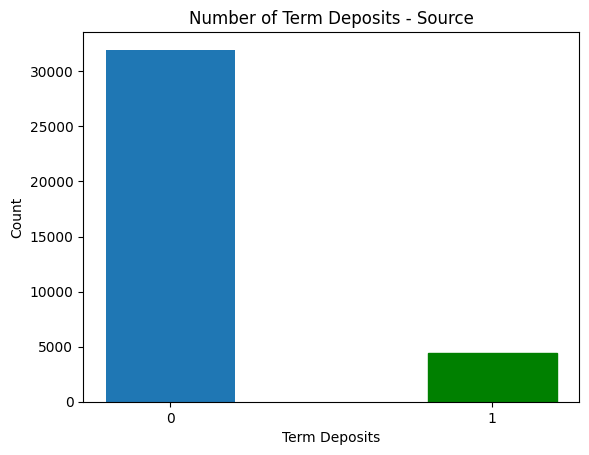

In [26]:
barlist_S = plt.bar([str(0),str(1)], y_S_full.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Term Deposits")
plt.ylabel("Count")
plt.title("Number of Term Deposits - Source")
plt.show()

## Target domain and task labels:

In [27]:
X_T_full = data_T.iloc[:, :-1]
X_T_full       ## Target domain


y_T_full = data_T.iloc[:, -1]
y_T_full       ## Target classification (response)

0       0
1       0
2       0
3       0
4       0
       ..
6795    0
6796    0
6797    0
6798    0
6799    1
Name: Y, Length: 6800, dtype: int64

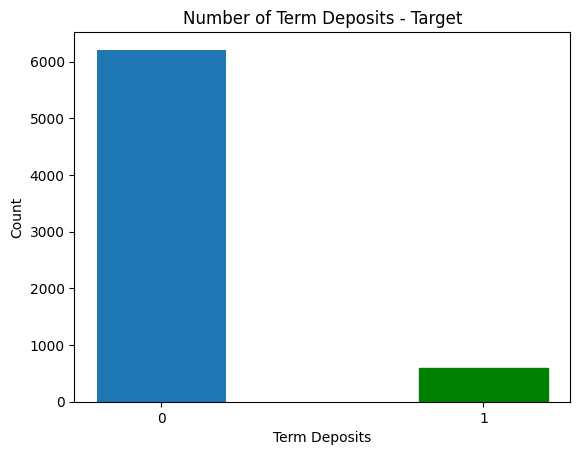

In [28]:
barlist_T = plt.bar([str(0),str(1)], y_T_full.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Term Deposits")
plt.ylabel("Count")
plt.title("Number of Term Deposits - Target")
plt.show()

## Updated Code (Modified from Shreya's code):

In [29]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)
    return time_elapsed


In [30]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)

    return fpr, tnr, fnr, tpr, time_elapsed

In [31]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)

In [32]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (29114, 16)
y_S_train: (29114,)
X_S_test: (7279, 16)
y_S_test: (7279,)


In [33]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6621 - loss: 0.3635 - val_AUC: 0.8654 - val_loss: 0.2782
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8646 - loss: 0.2668 - val_AUC: 0.8793 - val_loss: 0.2638
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8768 - loss: 0.2569 - val_AUC: 0.8822 - val_loss: 0.2610
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8767 - loss: 0.2532 - val_AUC: 0.8833 - val_loss: 0.2575
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8829 - loss: 0.2495 - val_AUC: 0.8872 - val_loss: 0.2553
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8885 - loss: 0.2433 - val_AUC: 0.8906 - val_loss: 0.2504
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8869 - loss: 0.2429 - val_AUC: 0.8930 - val_loss: 0.2485
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8940 - loss: 0.2384 - val_AUC: 0.8941 - val_loss: 0.2493
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AU

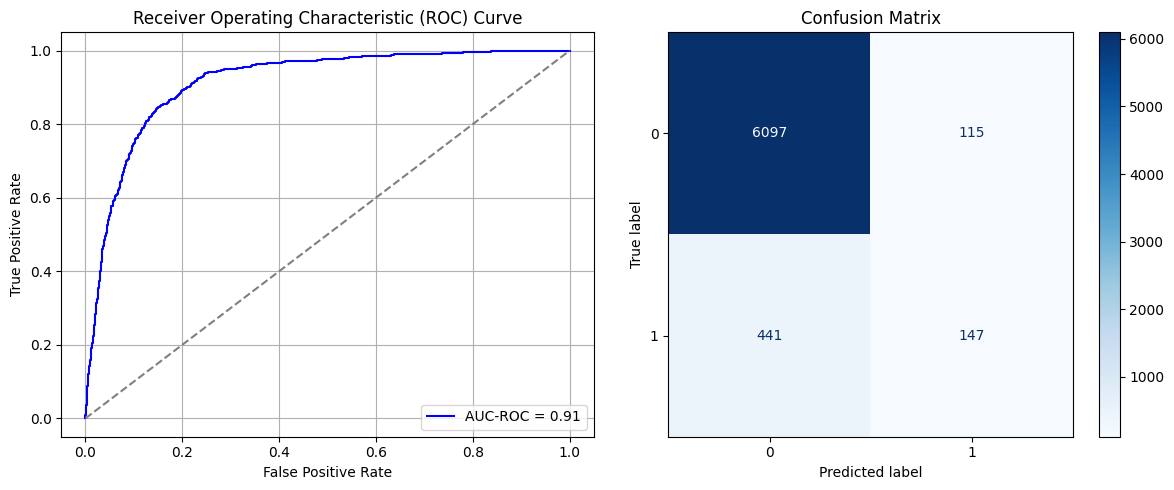

Best threshold based on F1-score: 0.16565173864364624
False Negative Rate: 0.75
Time elapsed (performance): 1.0317387399999802
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6582 - loss: 0.3635 - val_AUC: 0.8629 - val_loss: 0.2817
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8697 - loss: 0.2654 - val_AUC: 0.8797 - val_loss: 0.2622
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8799 - loss: 0.2509 - val_AUC: 0.8837 - val_loss: 0.2574
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8832 - loss: 0.2509 - val_AUC: 0.8838 - val_loss: 0.2579
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8864 - loss: 0.2466 - val_AUC: 0.8892 - val_loss: 0.2529
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8874 - loss: 0.2473 - val_AUC: 0.8880 - val_loss: 0.2524
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8934 - loss: 0.2388 - val_AUC: 0.8933 - val_loss: 0.2509
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8951 - loss: 0.2392 - val_AUC: 0.8926 - val_loss: 0.2490
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8950 -

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9148723558966406
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6212
           1       0.55      0.38      0.45       588

    accuracy                           0.92      6800
   macro avg       0.75      0.67      0.70      6800
weighted avg       0.91      0.92      0.91      6800

FPR 0.029298132646490664 TPR: 0.37925170068027214 FNR: 0.6207482993197279 TNR: 0.9707018673535094


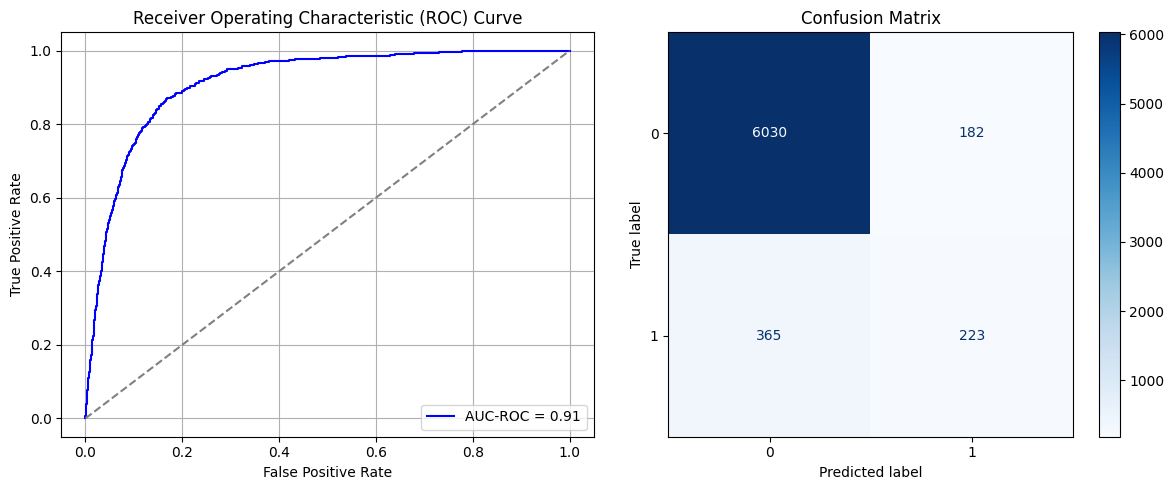

Best threshold based on F1-score: 0.2765471637248993
False Negative Rate: 0.6207482993197279
Time elapsed (performance): 0.7208422679999558
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6420 - loss: 0.3926 - val_AUC: 0.8642 - val_loss: 0.2839
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8666 - loss: 0.2706 - val_AUC: 0.8774 - val_loss: 0.2778
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8766 - loss: 0.2551 - val_AUC: 0.8813 - val_loss: 0.2634
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8790 - loss: 0.2565 - val_AUC: 0.8844 - val_loss: 0.2679
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8794 - loss: 0.2516 - val_AUC: 0.8843 - val_loss: 0.2594
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8811 - loss: 0.2534 - val_AUC: 0.8857 - val_loss: 0.2565
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8812 - loss: 0.2511 - val_AUC: 0.8866 - val_loss: 0.2543
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8824 - loss: 0.2447 - val_AUC: 0.8869 - val_loss: 0.2541
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8890 -

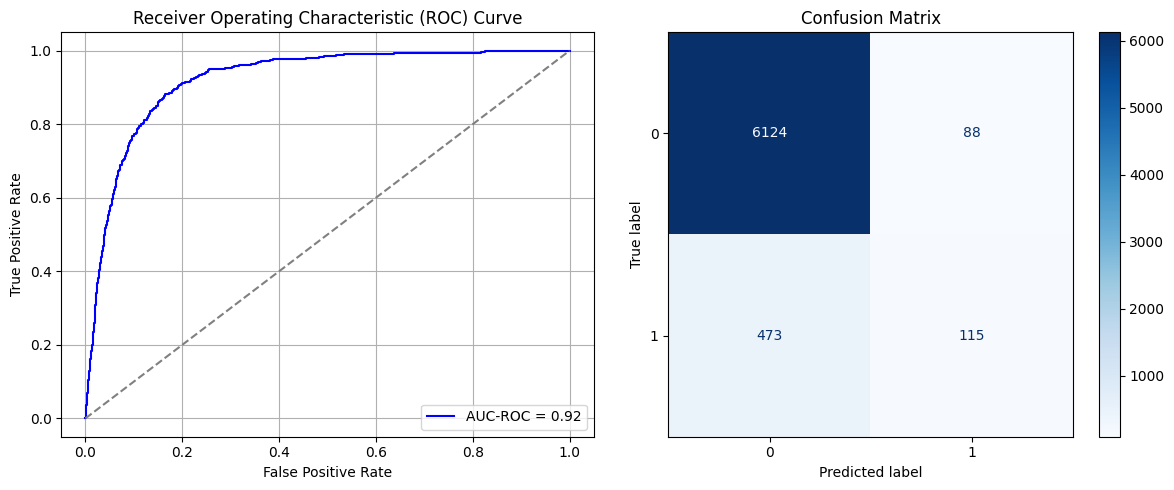

Best threshold based on F1-score: 0.8042197823524475
False Negative Rate: 0.8044217687074829
Time elapsed (performance): 0.7788296499999774
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6574 - loss: 0.3650 - val_AUC: 0.8667 - val_loss: 0.2812
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8680 - loss: 0.2635 - val_AUC: 0.8788 - val_loss: 0.2670
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8810 - loss: 0.2534 - val_AUC: 0.8840 - val_loss: 0.2585
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8839 - loss: 0.2494 - val_AUC: 0.8840 - val_loss: 0.2595
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8897 - loss: 0.2398 - val_AUC: 0.8860 - val_loss: 0.2582
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8909 - loss: 0.2395 - val_AUC: 0.8865 - val_loss: 0.2593
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8918 - loss: 0.2427 - val_AUC: 0.8910 - val_loss: 0.2528
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8935 - loss: 0.2344 - val_AUC: 0.8899 - val_loss: 0.2595
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8922 -

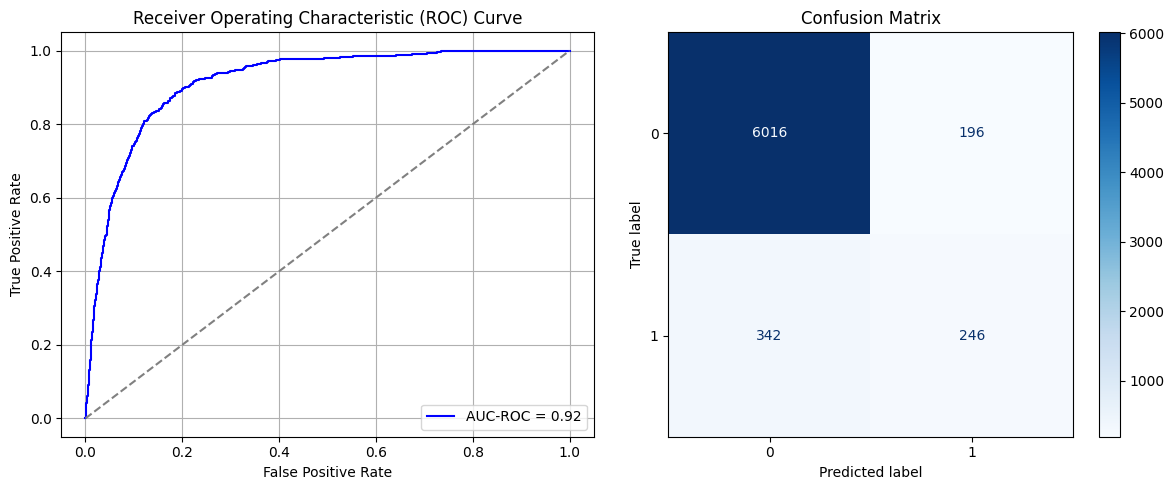

Best threshold based on F1-score: 0.3603358864784241
False Negative Rate: 0.5816326530612245
Time elapsed (performance): 1.1948640979999823
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6448 - loss: 0.3777 - val_AUC: 0.8580 - val_loss: 0.2866
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8607 - loss: 0.2602 - val_AUC: 0.8800 - val_loss: 0.2723
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8788 - loss: 0.2552 - val_AUC: 0.8826 - val_loss: 0.2583
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8855 - loss: 0.2495 - val_AUC: 0.8843 - val_loss: 0.2556
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8864 - loss: 0.2426 - val_AUC: 0.8838 - val_loss: 0.2585
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8898 - loss: 0.2427 - val_AUC: 0.8888 - val_loss: 0.2613
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8963 - loss: 0.2360 - val_AUC: 0.8850 - val_loss: 0.2573
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8937 - loss: 0.2341 - val_AUC: 0.8912 - val_loss: 0.2509
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8896 -

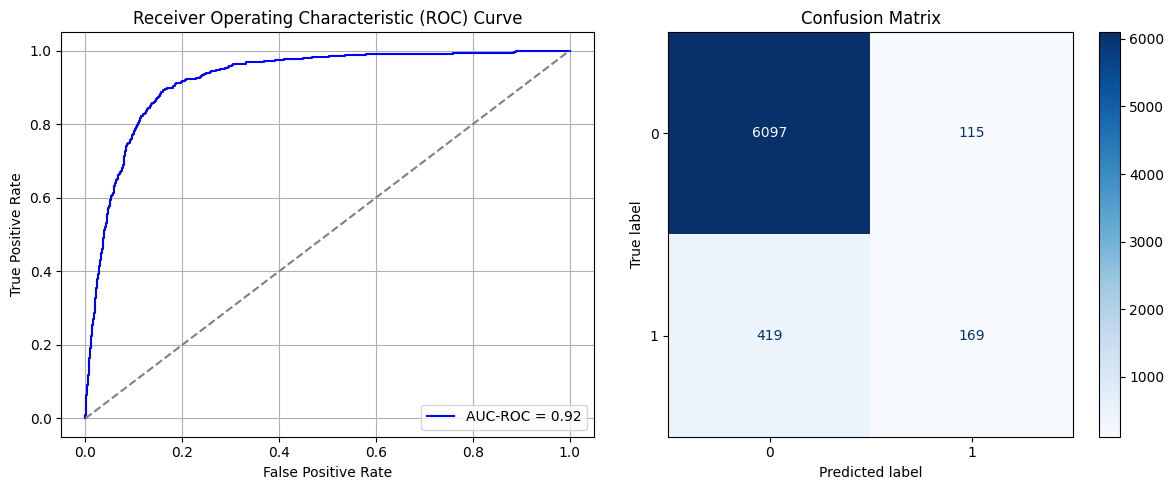

Best threshold based on F1-score: 0.1940212845802307
False Negative Rate: 0.7125850340136054
Time elapsed (performance): 0.7589045670000019
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6727 - loss: 0.3633 - val_AUC: 0.8729 - val_loss: 0.2757
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8760 - loss: 0.2608 - val_AUC: 0.8808 - val_loss: 0.2740
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8845 - loss: 0.2522 - val_AUC: 0.8816 - val_loss: 0.2607
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8900 - loss: 0.2435 - val_AUC: 0.8850 - val_loss: 0.2576
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8857 - loss: 0.2509 - val_AUC: 0.8856 - val_loss: 0.2630
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8820 - loss: 0.2452 - val_AUC: 0.8864 - val_loss: 0.2545
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8875 - loss: 0.2454 - val_AUC: 0.8903 - val_loss: 0.2513
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8912 - loss: 0.2402 - val_AUC: 0.8914 - val_loss: 0.2534
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8944 -

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9218021078360515
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6212
           1       0.59      0.29      0.38       588

    accuracy                           0.92      6800
   macro avg       0.76      0.63      0.67      6800
weighted avg       0.91      0.92      0.91      6800

FPR 0.019156471345782355 TPR: 0.2857142857142857 FNR: 0.7142857142857143 TNR: 0.9808435286542176


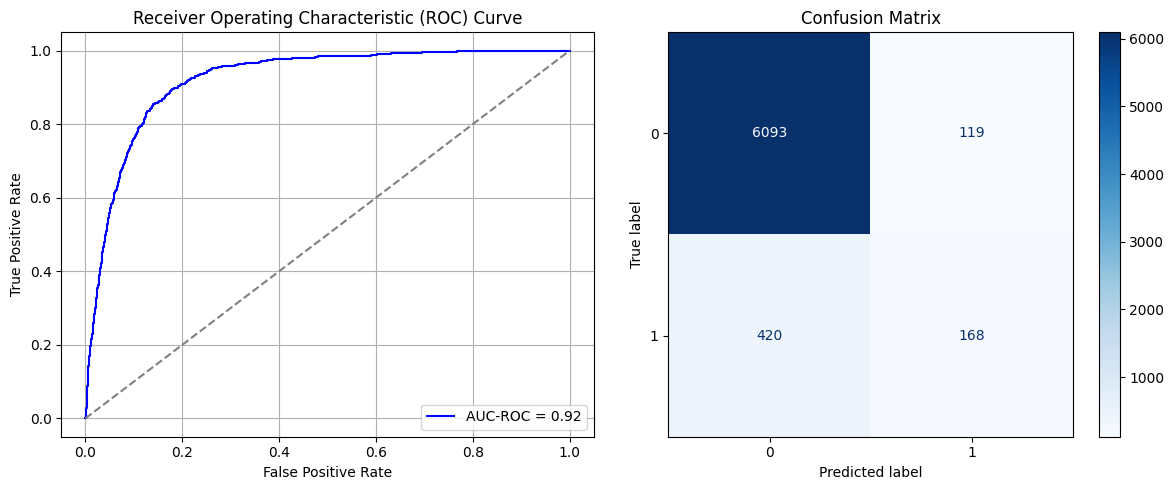

Best threshold based on F1-score: 0.787860095500946
False Negative Rate: 0.7142857142857143
Time elapsed (performance): 0.7440261600000326
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6524 - loss: 0.3769 - val_AUC: 0.8650 - val_loss: 0.2798
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8672 - loss: 0.2644 - val_AUC: 0.8804 - val_loss: 0.2649
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8816 - loss: 0.2514 - val_AUC: 0.8839 - val_loss: 0.2573
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8768 - loss: 0.2557 - val_AUC: 0.8864 - val_loss: 0.2552
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8856 - loss: 0.2459 - val_AUC: 0.8896 - val_loss: 0.2518
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8876 - loss: 0.2493 - val_AUC: 0.8921 - val_loss: 0.2517
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8937 - loss: 0.2414 - val_AUC: 0.8905 - val_loss: 0.2579
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8964 - loss: 0.2364 - val_AUC: 0.8957 - val_loss: 0.2463
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.8950 -

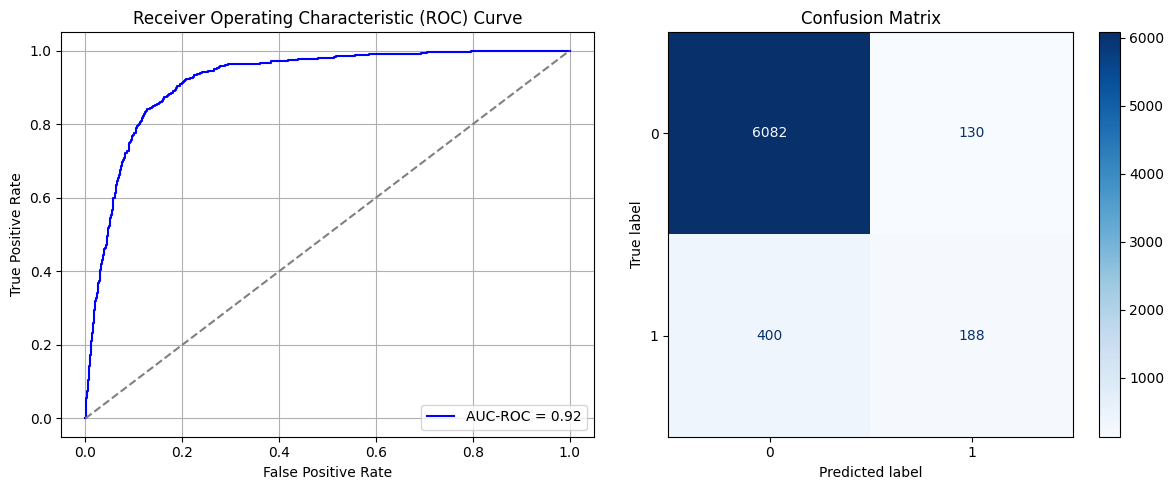

Best threshold based on F1-score: 0.20897316932678223
False Negative Rate: 0.6802721088435374
Time elapsed (performance): 0.7490924569999606
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6470 - loss: 0.3781 - val_AUC: 0.8666 - val_loss: 0.2774
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8689 - loss: 0.2648 - val_AUC: 0.8810 - val_loss: 0.2623
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8802 - loss: 0.2525 - val_AUC: 0.8834 - val_loss: 0.2599
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8816 - loss: 0.2468 - val_AUC: 0.8850 - val_loss: 0.2559
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8818 - loss: 0.2481 - val_AUC: 0.8845 - val_loss: 0.2571
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8882 - loss: 0.2458 - val_AUC: 0.8865 - val_loss: 0.2545
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8863 - loss: 0.2477 - val_AUC: 0.8867 - val_loss: 0.2540
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8914 - loss: 0.2407 - val_AUC: 0.8888 - val_loss: 0.2527
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8951 -

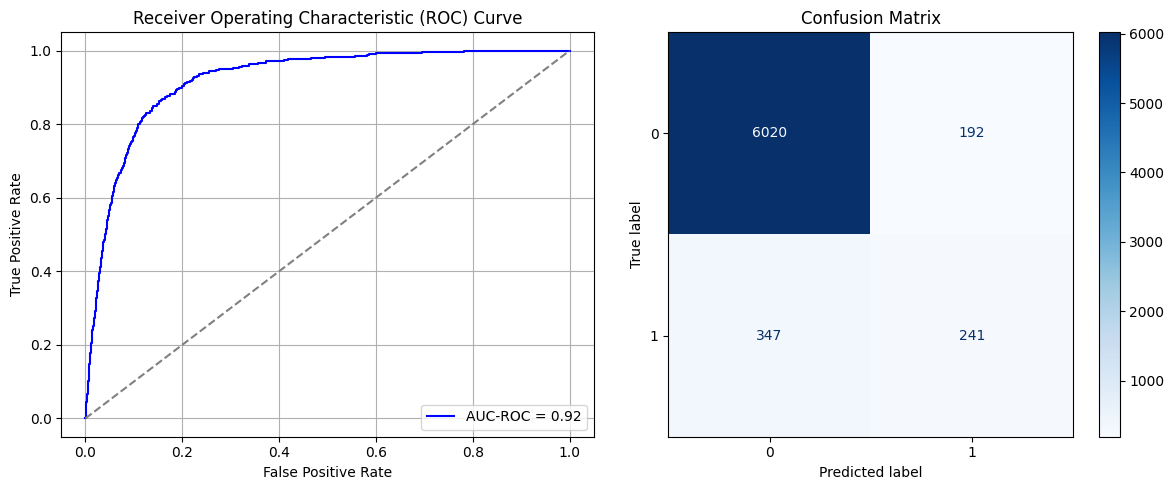

Best threshold based on F1-score: 0.8105908632278442
False Negative Rate: 0.5901360544217688
Time elapsed (performance): 0.7847304389999863
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6705 - loss: 0.3610 - val_AUC: 0.8741 - val_loss: 0.2723
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8664 - loss: 0.2638 - val_AUC: 0.8776 - val_loss: 0.2740
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8793 - loss: 0.2478 - val_AUC: 0.8797 - val_loss: 0.2612
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8775 - loss: 0.2547 - val_AUC: 0.8840 - val_loss: 0.2629
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8799 - loss: 0.2494 - val_AUC: 0.8852 - val_loss: 0.2648
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8824 - loss: 0.2490 - val_AUC: 0.8866 - val_loss: 0.2555
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8890 - loss: 0.2416 - val_AUC: 0.8891 - val_loss: 0.2517
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8953 - loss: 0.2403 - val_AUC: 0.8912 - val_loss: 0.2554
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8864 -

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9175772369475802
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6212
           1       0.60      0.25      0.35       588

    accuracy                           0.92      6800
   macro avg       0.77      0.62      0.66      6800
weighted avg       0.90      0.92      0.91      6800

FPR 0.015453960077269801 TPR: 0.25 FNR: 0.75 TNR: 0.9845460399227302


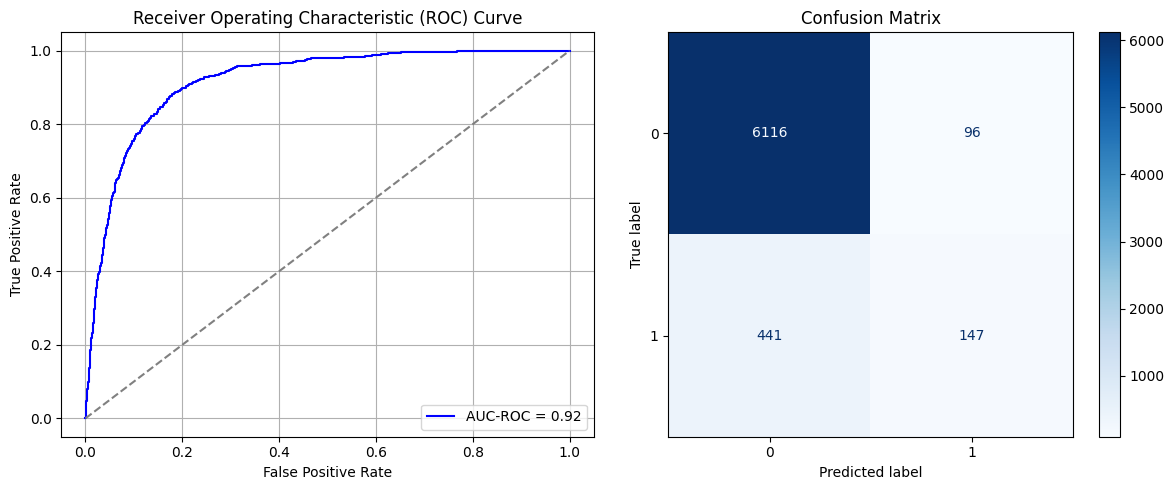

Best threshold based on F1-score: 0.7237189412117004
False Negative Rate: 0.75
Time elapsed (performance): 0.7725597169999219
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6773 - loss: 0.3527 - val_AUC: 0.8716 - val_loss: 0.2807
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8753 - loss: 0.2543 - val_AUC: 0.8800 - val_loss: 0.2619
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8810 - loss: 0.2522 - val_AUC: 0.8832 - val_loss: 0.2611
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8781 - loss: 0.2489 - val_AUC: 0.8863 - val_loss: 0.2548
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8821 - loss: 0.2497 - val_AUC: 0.8861 - val_loss: 0.2550
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8822 - loss: 0.2550 - val_AUC: 0.8888 - val_loss: 0.2526
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8872 - loss: 0.2446 - val_AUC: 0.8889 - val_loss: 0.2596
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8925 - loss: 0.2409 - val_AUC: 0.8923 - val_loss: 0.2494
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8886 -

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9193822248796493
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6212
           1       0.60      0.17      0.27       588

    accuracy                           0.92      6800
   macro avg       0.77      0.58      0.61      6800
weighted avg       0.90      0.92      0.90      6800

FPR 0.010624597553122988 TPR: 0.17176870748299322 FNR: 0.8282312925170068 TNR: 0.989375402446877


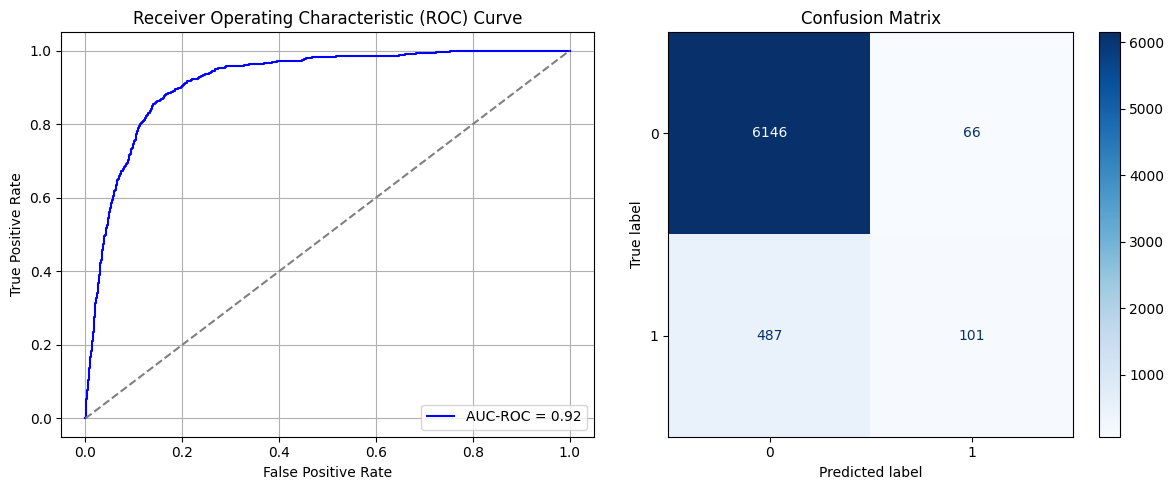

Best threshold based on F1-score: 0.7306824326515198
False Negative Rate: 0.8282312925170068
Time elapsed (performance): 0.7568912169999749


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [34]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)
    model_source = create_dnn_model(X_S_train.shape[1])
    result_imbalanced = train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    Training_time.append(result_imbalanced)
    FPR.append(result_TL_imbalanced[0])
    TNR.append(result_TL_imbalanced[1])
    FNR.append(result_TL_imbalanced[2])
    TPR.append(result_TL_imbalanced[3])
    TL_time.append(result_TL_imbalanced[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [35]:
print(ParamFit)
ParamFit.to_csv('Imbalanced.csv')

## Remember that TPR is actually TNR and TNR is actually TPR!!!

   Source time       FPR       TPR       FNR       TNR  Target time
0    25.734774  0.018513  0.250000  0.750000  0.981487     1.031739
1    24.956974  0.029298  0.379252  0.620748  0.970702     0.720842
2    25.711288  0.014166  0.195578  0.804422  0.985834     0.778830
3    27.777824  0.031552  0.418367  0.581633  0.968448     1.194864
4    29.705885  0.018513  0.287415  0.712585  0.981487     0.758905
5    28.758704  0.019156  0.285714  0.714286  0.980844     0.744026
6    32.446221  0.020927  0.319728  0.680272  0.979073     0.749092
7    29.316765  0.030908  0.409864  0.590136  0.969092     0.784730
8    32.206434  0.015454  0.250000  0.750000  0.984546     0.772560
9    25.652454  0.010625  0.171769  0.828231  0.989375     0.756891


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [36]:
data_S

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
36388  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
36389  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
36390  0.701299  0.4  0.5  0.5  0.0  0.124689  0.0  0.0  0.5  0.533333   
36391  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   
36392  0.246753  0.2  0.5  0.5  0.0  0.099777  0.0  0.0  0.5  0.533333   

             10        11        12        13        14        15  Y  
0      0.363636  0.053070  0.000000  0.000000  0.000000  0.000000  0  
1      0.363636  0.030704  0.000000  0.000000  0.000000  0.000000  0  
2      0.363636  0.015453  0.000000  0.000000  0.000000  0.000000  0  
3      0.363636  0.028264  0.000000  0.000000  0.000000  0.000000  0  
4      0.363636  0.044124  0.000000  0.000000  0.000000  0.000000  0  
...         ...       ...       ...       ...       ...       ... ..  
36388  0.909091  0.078487  0.017544  0.000000  0.000000  0.000000  1  
36389  0.909091  0.198658  0.035088  0.000000  0.000000  0.000000  1  
36390  0.909091  0.229158  0.070175  0.212156  0.010909  0.666667  1  
36391  0.909091  0.103294  0.052632  0.000000  0.000000  0.000000  0  
36392  0.909091  0.073404  0.017544  0.216743  0.040000  1.000000  0  

[36393 rows x 17 columns]

In [37]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

4433
31960


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6650 - loss: 0.6589 - val_AUC: 0.7538 - val_loss: 0.6102
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7795 - loss: 0.5698 - val_AUC: 0.8402 - val_loss: 0.5080
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8552 - loss: 0.4865 - val_AUC: 0.8704 - val_loss: 0.4608
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8670 - loss: 0.4640 - val_AUC: 0.8778 - val_loss: 0.4472
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8784 - loss: 0.4425 - val_AUC: 0.8804 - val_loss: 0.4399
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8806 - loss: 0.4362 - val_AUC: 0.8813 - val_loss: 0.4444
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4309 - val_AUC: 0.8814 - val_loss: 0.4347
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4283 - val_AUC: 0.8869 - val_loss: 0.4257
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 -

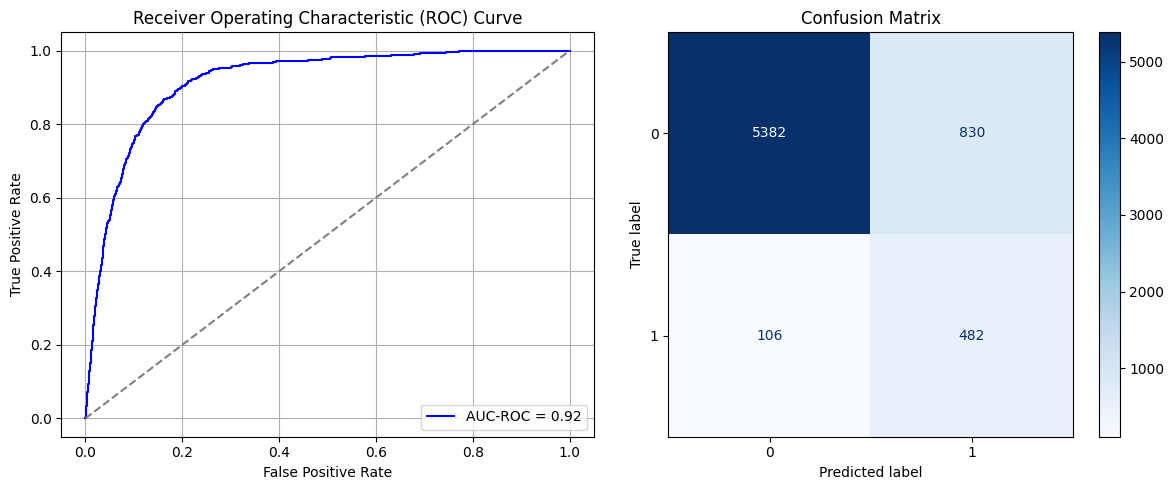

Best threshold based on F1-score: 0.9924026131629944
False Negative Rate: 0.18027210884353742
Time elapsed (performance): 0.7247950619999983
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6467 - loss: 0.6627 - val_AUC: 0.7565 - val_loss: 0.5914
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7791 - loss: 0.5725 - val_AUC: 0.8443 - val_loss: 0.5097
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8538 - loss: 0.4925 - val_AUC: 0.8710 - val_loss: 0.4743
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8711 - loss: 0.4577 - val_AUC: 0.8818 - val_loss: 0.4432
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8829 - loss: 0.4352 - val_AUC: 0.8830 - val_loss: 0.4401
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8870 - loss: 0.4297 - val_AUC: 0.8817 - val_loss: 0.4430
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4307 - val_AUC: 0.8845 - val_loss: 0.4377
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.4114 - val_AUC: 0.8848 - val_loss: 0.4328
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 -

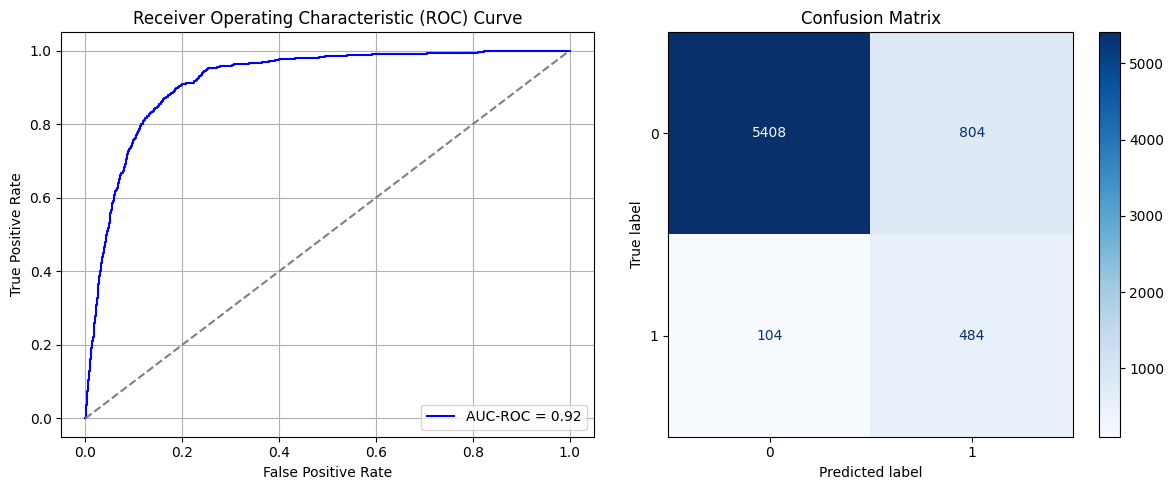

Best threshold based on F1-score: 0.9972143769264221
False Negative Rate: 0.17687074829931973
Time elapsed (performance): 0.7141433060000963
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6304 - loss: 0.6658 - val_AUC: 0.7805 - val_loss: 0.5822
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7900 - loss: 0.5675 - val_AUC: 0.8721 - val_loss: 0.4819
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8475 - loss: 0.4957 - val_AUC: 0.8931 - val_loss: 0.4385
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8658 - loss: 0.4656 - val_AUC: 0.8959 - val_loss: 0.4211
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.4479 - val_AUC: 0.8920 - val_loss: 0.4260
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8810 - loss: 0.4382 - val_AUC: 0.8961 - val_loss: 0.4249
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4321 - val_AUC: 0.8967 - val_loss: 0.4137
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4212 - val_AUC: 0.8961 - val_loss: 0.4363
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8883 -

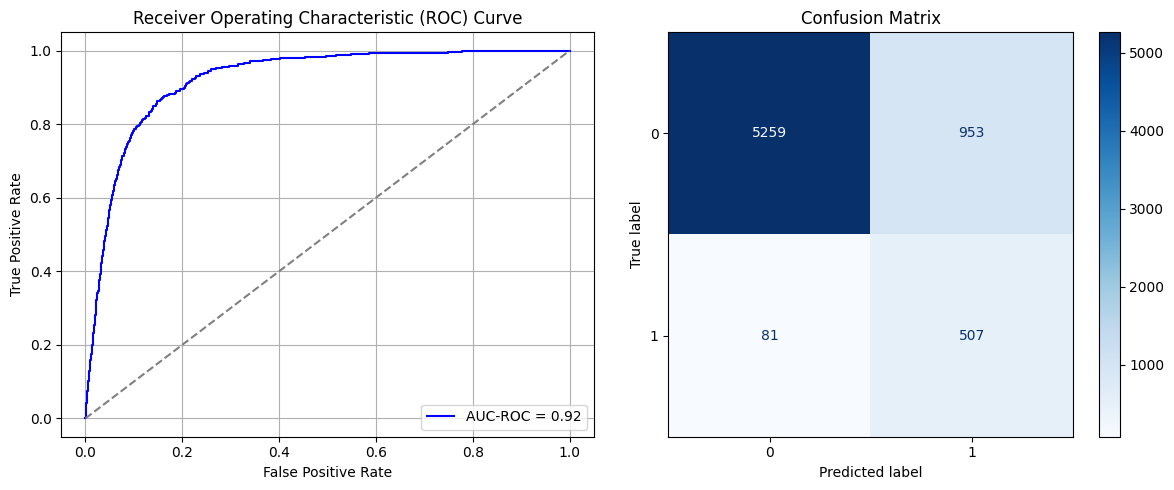

Best threshold based on F1-score: 0.9999001026153564
False Negative Rate: 0.1377551020408163
Time elapsed (performance): 0.7538094700000784
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6626 - loss: 0.6576 - val_AUC: 0.7753 - val_loss: 0.5775
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8060 - loss: 0.5454 - val_AUC: 0.8722 - val_loss: 0.4806
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8625 - loss: 0.4769 - val_AUC: 0.8809 - val_loss: 0.4488
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8761 - loss: 0.4507 - val_AUC: 0.8854 - val_loss: 0.4338
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8744 - loss: 0.4487 - val_AUC: 0.8855 - val_loss: 0.4400
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8791 - loss: 0.4414 - val_AUC: 0.8868 - val_loss: 0.4295
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8824 - loss: 0.4355 - val_AUC: 0.8844 - val_loss: 0.4438
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4220 - val_AUC: 0.8855 - val_loss: 0.4428
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 -

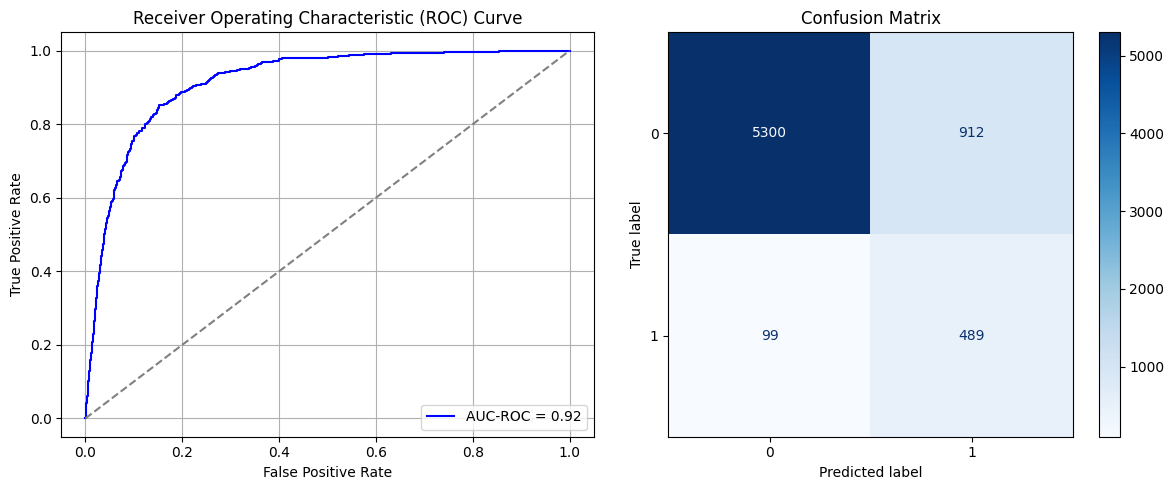

Best threshold based on F1-score: 0.9982789754867554
False Negative Rate: 0.1683673469387755
Time elapsed (performance): 1.0985274180000033
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6635 - loss: 0.6531 - val_AUC: 0.7851 - val_loss: 0.5759
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7788 - loss: 0.5728 - val_AUC: 0.8613 - val_loss: 0.5010
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8470 - loss: 0.5037 - val_AUC: 0.8806 - val_loss: 0.4522
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8759 - loss: 0.4527 - val_AUC: 0.8867 - val_loss: 0.4367
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8744 - loss: 0.4546 - val_AUC: 0.8881 - val_loss: 0.4340
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4468 - val_AUC: 0.8903 - val_loss: 0.4275
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4309 - val_AUC: 0.8885 - val_loss: 0.4255
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4257 - val_AUC: 0.8905 - val_loss: 0.4208
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 -

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9164495643717887
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      6212
           1       0.37      0.80      0.51       588

    accuracy                           0.87      6800
   macro avg       0.68      0.84      0.72      6800
weighted avg       0.93      0.87      0.89      6800

FPR 0.12846104314230522 TPR: 0.804421768707483 FNR: 0.195578231292517 TNR: 0.8715389568576948


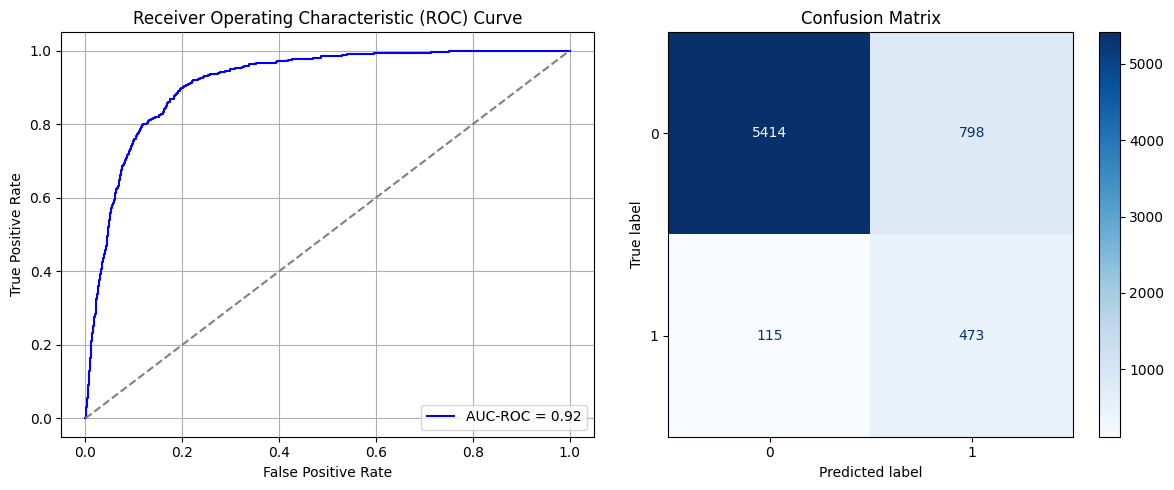

Best threshold based on F1-score: 0.644701361656189
False Negative Rate: 0.195578231292517
Time elapsed (performance): 0.776029957999981
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6543 - loss: 0.6560 - val_AUC: 0.7782 - val_loss: 0.5783
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7928 - loss: 0.5620 - val_AUC: 0.8550 - val_loss: 0.4977
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8590 - loss: 0.4884 - val_AUC: 0.8761 - val_loss: 0.4616
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8701 - loss: 0.4634 - val_AUC: 0.8817 - val_loss: 0.4409
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8769 - loss: 0.4461 - val_AUC: 0.8837 - val_loss: 0.4380
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8711 - loss: 0.4556 - val_AUC: 0.8851 - val_loss: 0.4334
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4391 - val_AUC: 0.8870 - val_loss: 0.4299
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8788 - loss: 0.4410 - val_AUC: 0.8874 - val_loss: 0.4284
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 -

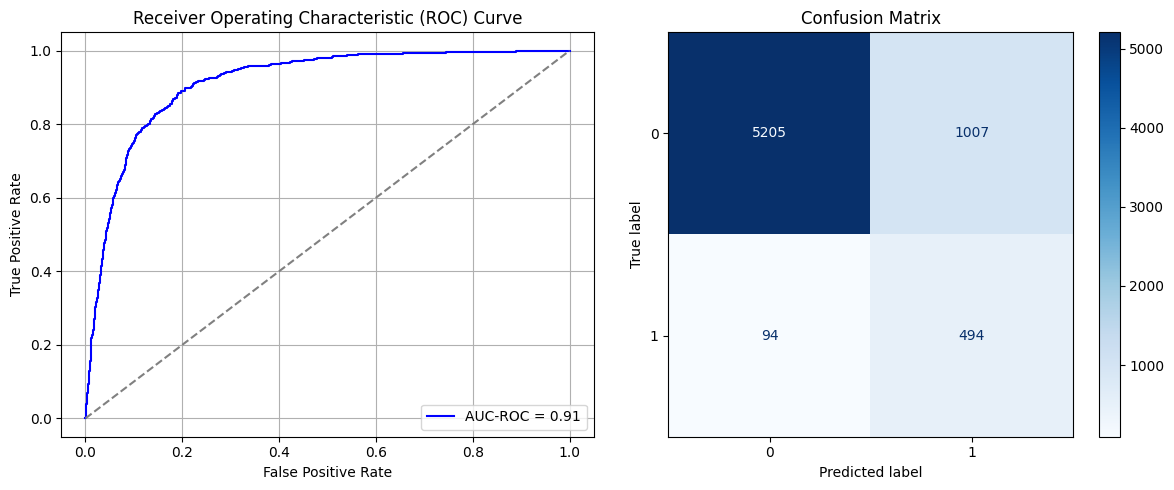

Best threshold based on F1-score: 0.997645378112793
False Negative Rate: 0.1598639455782313
Time elapsed (performance): 1.0271114070000067
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6776 - loss: 0.6541 - val_AUC: 0.7743 - val_loss: 0.5790
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7828 - loss: 0.5680 - val_AUC: 0.8619 - val_loss: 0.5037
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8514 - loss: 0.4974 - val_AUC: 0.8810 - val_loss: 0.4493
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8607 - loss: 0.4731 - val_AUC: 0.8885 - val_loss: 0.4385
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8771 - loss: 0.4455 - val_AUC: 0.8877 - val_loss: 0.4300
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8827 - loss: 0.4353 - val_AUC: 0.8880 - val_loss: 0.4309
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4315 - val_AUC: 0.8889 - val_loss: 0.4331
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4345 - val_AUC: 0.8906 - val_loss: 0.4267
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8763 -

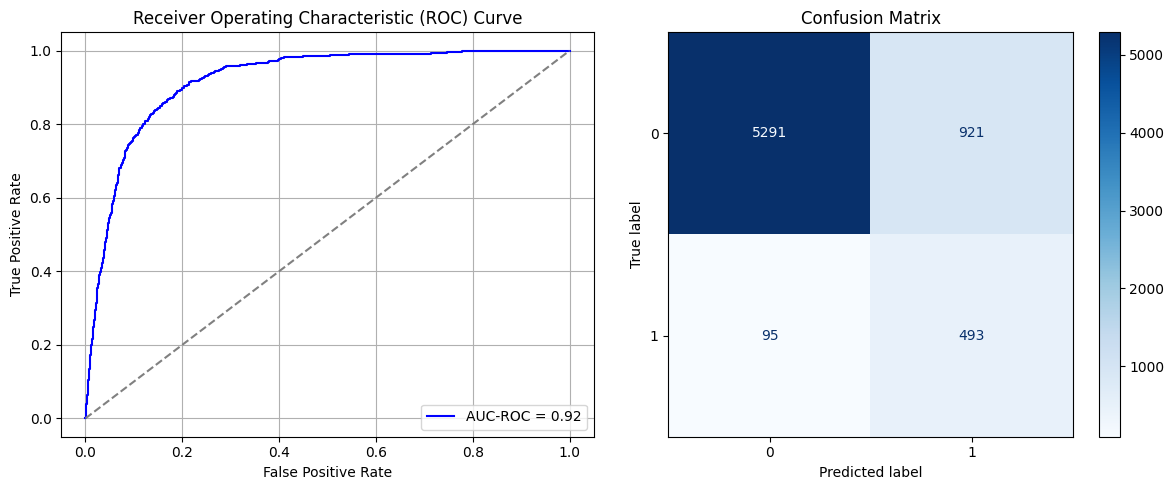

Best threshold based on F1-score: 0.9988077878952026
False Negative Rate: 0.16156462585034015
Time elapsed (performance): 0.74438804600004
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6720 - loss: 0.6557 - val_AUC: 0.7757 - val_loss: 0.5874
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7894 - loss: 0.5638 - val_AUC: 0.8585 - val_loss: 0.4933
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8517 - loss: 0.4938 - val_AUC: 0.8830 - val_loss: 0.4588
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8740 - loss: 0.4565 - val_AUC: 0.8832 - val_loss: 0.4502
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8707 - loss: 0.4582 - val_AUC: 0.8843 - val_loss: 0.4392
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8759 - loss: 0.4529 - val_AUC: 0.8833 - val_loss: 0.4359
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8740 - loss: 0.4523 - val_AUC: 0.8871 - val_loss: 0.4291
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4360 - val_AUC: 0.8865 - val_loss: 0.4289
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 -

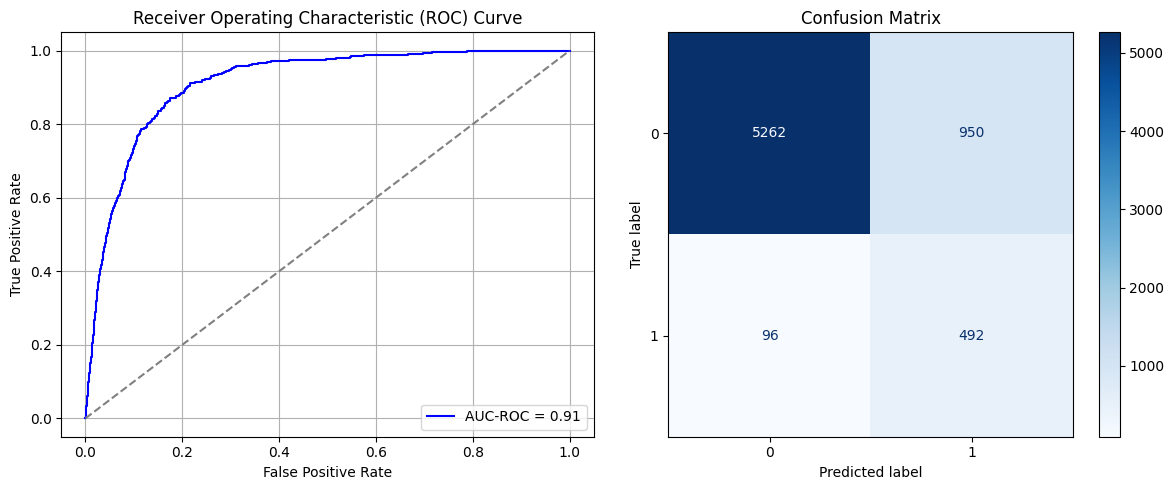

Best threshold based on F1-score: 0.9982971549034119
False Negative Rate: 0.16326530612244897
Time elapsed (performance): 0.7610206969999354
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6646 - loss: 0.6596 - val_AUC: 0.7484 - val_loss: 0.6023
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7706 - loss: 0.5764 - val_AUC: 0.8366 - val_loss: 0.5261
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8470 - loss: 0.5004 - val_AUC: 0.8690 - val_loss: 0.4661
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8762 - loss: 0.4518 - val_AUC: 0.8739 - val_loss: 0.4598
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4516 - val_AUC: 0.8742 - val_loss: 0.4483
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4330 - val_AUC: 0.8747 - val_loss: 0.4549
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4260 - val_AUC: 0.8761 - val_loss: 0.4476
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8784 - loss: 0.4417 - val_AUC: 0.8775 - val_loss: 0.4424
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 -

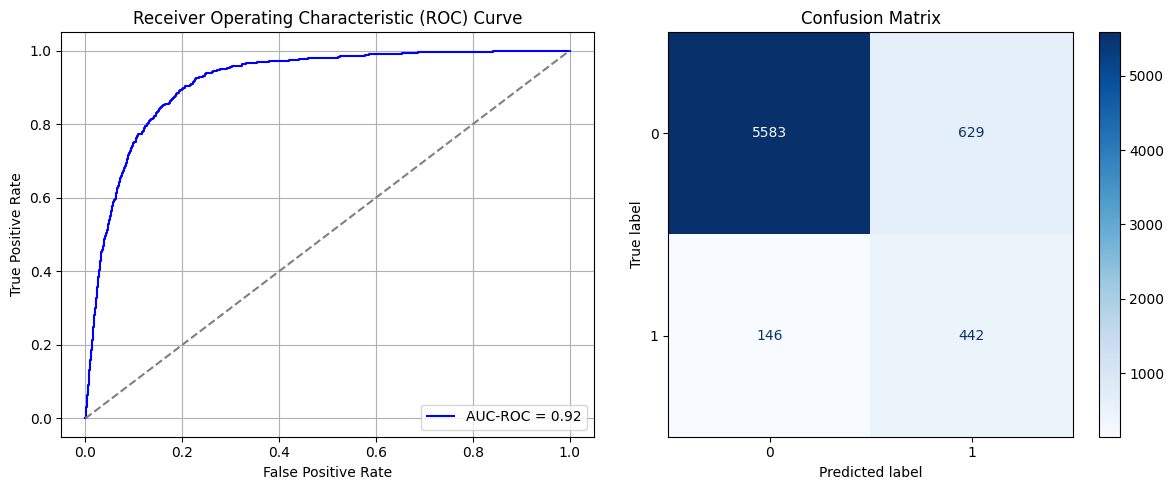

Best threshold based on F1-score: 0.9992761611938477
False Negative Rate: 0.24829931972789115
Time elapsed (performance): 1.0179817210000692
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6621 - loss: 0.6583 - val_AUC: 0.7639 - val_loss: 0.5867
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7727 - loss: 0.5765 - val_AUC: 0.8425 - val_loss: 0.5073
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8470 - loss: 0.4964 - val_AUC: 0.8827 - val_loss: 0.4487
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8653 - loss: 0.4655 - val_AUC: 0.8897 - val_loss: 0.4285
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8715 - loss: 0.4535 - val_AUC: 0.8912 - val_loss: 0.4352
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4446 - val_AUC: 0.8918 - val_loss: 0.4224
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4338 - val_AUC: 0.8923 - val_loss: 0.4178
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4279 - val_AUC: 0.8874 - val_loss: 0.4230
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8847 -

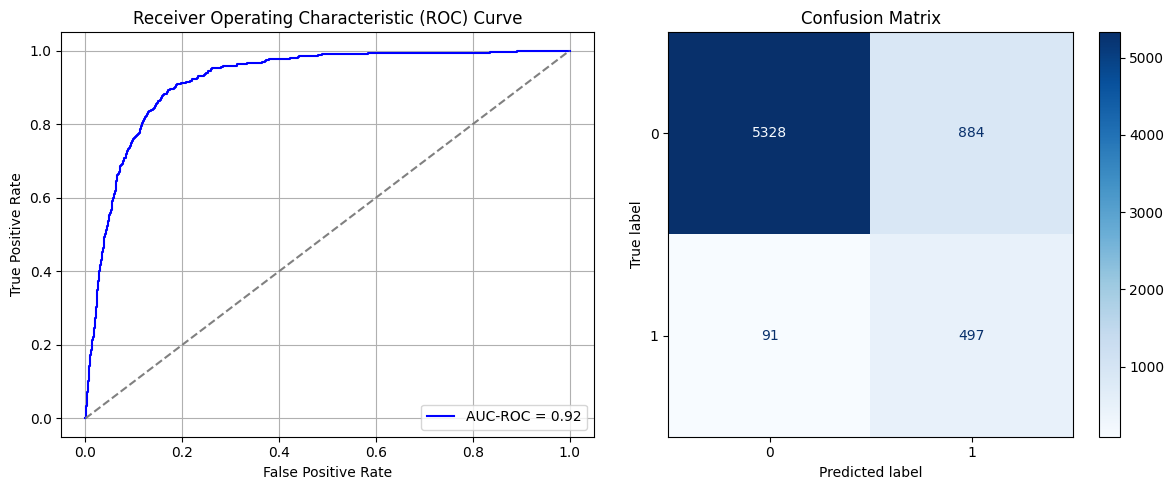

Best threshold based on F1-score: 0.7129182815551758
False Negative Rate: 0.15476190476190477
Time elapsed (performance): 0.7568796410000687


In [38]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
    data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRS = data_S_SRS_RUS.iloc[:, :-1]
    y_S_SRS = data_S_SRS_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
    model_SRS = create_dnn_model(X_S_train.shape[1])
    result_SRS = train_and_evaluate(model_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS = Transductive_TL(model_SRS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS)
    FPR.append(result_TL_SRS[0])
    TNR.append(result_TL_SRS[1])
    FNR.append(result_TL_SRS[2])
    TPR.append(result_TL_SRS[3])
    TL_time.append(result_TL_SRS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [39]:
print(ParamFit)
ParamFit.to_csv('SRS_RUS.csv')

   Source time       FPR       TPR       FNR       TNR  Target time
0    12.759643  0.133612  0.819728  0.180272  0.866388     0.724795
1     9.973880  0.129427  0.823129  0.176871  0.870573     0.714143
2     9.870659  0.153413  0.862245  0.137755  0.846587     0.753809
3     8.332649  0.146813  0.831633  0.168367  0.853187     1.098527
4     9.741380  0.128461  0.804422  0.195578  0.871539     0.776030
5     8.908082  0.162106  0.840136  0.159864  0.837894     1.027111
6     9.514074  0.148261  0.838435  0.161565  0.851739     0.744388
7    10.593938  0.152930  0.836735  0.163265  0.847070     0.761021
8     9.805874  0.101256  0.751701  0.248299  0.898744     1.017982
9     9.692922  0.142305  0.845238  0.154762  0.857695     0.756880


## Simple Random Sampling with Replacement:

In [40]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

4433
31960


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6475 - loss: 0.6577 - val_AUC: 0.7754 - val_loss: 0.5753
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7953 - loss: 0.5544 - val_AUC: 0.8554 - val_loss: 0.4968
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8533 - loss: 0.4875 - val_AUC: 0.8732 - val_loss: 0.4613
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8785 - loss: 0.4473 - val_AUC: 0.8790 - val_loss: 0.4461
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8891 - loss: 0.4244 - val_AUC: 0.8794 - val_loss: 0.4454
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8805 - loss: 0.4374 - val_AUC: 0.8791 - val_loss: 0.4445
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4193 - val_AUC: 0.8785 - val_loss: 0.4429
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4190 - val_AUC: 0.8820 - val_loss: 0.4391
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8783 -

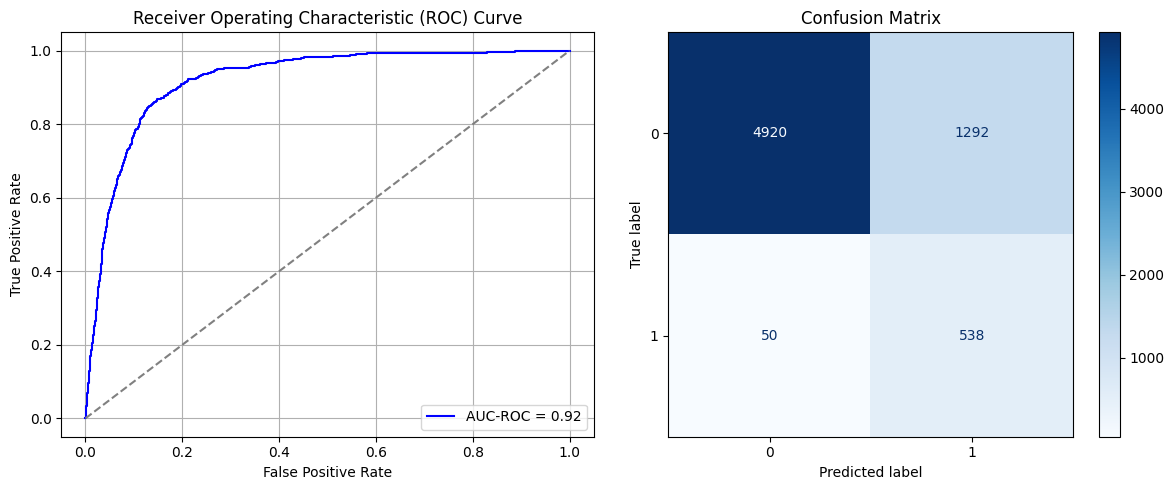

Best threshold based on F1-score: 0.9992722868919373
False Negative Rate: 0.08503401360544217
Time elapsed (performance): 0.7348691010000721
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6802 - loss: 0.6542 - val_AUC: 0.7708 - val_loss: 0.5874
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7902 - loss: 0.5639 - val_AUC: 0.8674 - val_loss: 0.4874
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8625 - loss: 0.4777 - val_AUC: 0.8864 - val_loss: 0.4349
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8724 - loss: 0.4540 - val_AUC: 0.8909 - val_loss: 0.4322
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4442 - val_AUC: 0.8926 - val_loss: 0.4195
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8806 - loss: 0.4369 - val_AUC: 0.8928 - val_loss: 0.4324
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4340 - val_AUC: 0.8939 - val_loss: 0.4211
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8768 - loss: 0.4425 - val_AUC: 0.8949 - val_loss: 0.4113
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8805 -

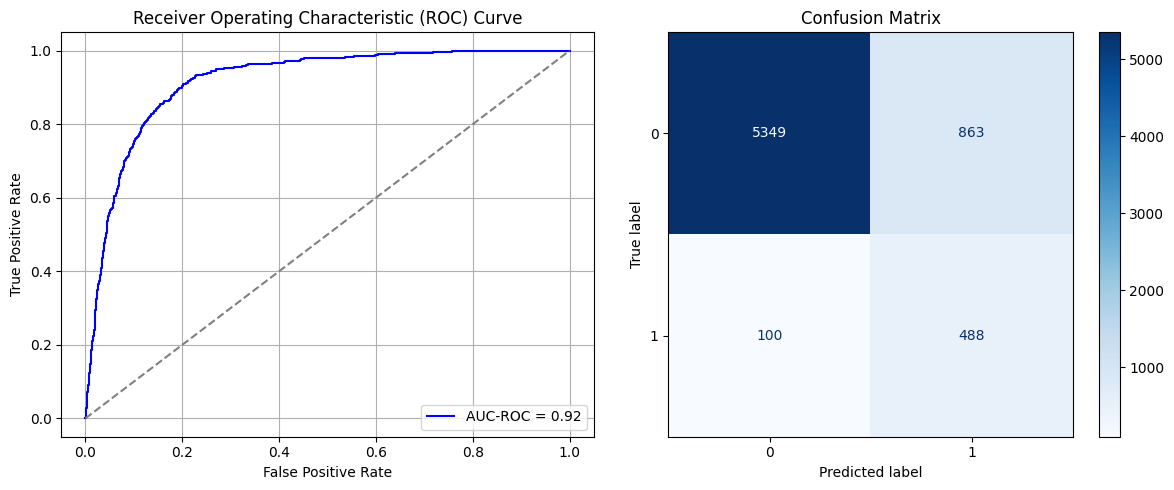

Best threshold based on F1-score: 0.6675875186920166
False Negative Rate: 0.17006802721088435
Time elapsed (performance): 0.7075270529999216
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6857 - loss: 0.6463 - val_AUC: 0.8012 - val_loss: 0.5627
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8149 - loss: 0.5402 - val_AUC: 0.8737 - val_loss: 0.4734
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8723 - loss: 0.4653 - val_AUC: 0.8832 - val_loss: 0.4420
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4447 - val_AUC: 0.8875 - val_loss: 0.4318
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4320 - val_AUC: 0.8846 - val_loss: 0.4304
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4250 - val_AUC: 0.8891 - val_loss: 0.4233
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4318 - val_AUC: 0.8886 - val_loss: 0.4287
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4334 - val_AUC: 0.8907 - val_loss: 0.4264
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 -

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.9181297116399683
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      6212
           1       0.34      0.86      0.49       588

    accuracy                           0.85      6800
   macro avg       0.66      0.85      0.70      6800
weighted avg       0.93      0.85      0.87      6800

FPR 0.15373470701867353 TPR: 0.8554421768707483 FNR: 0.1445578231292517 TNR: 0.8462652929813265


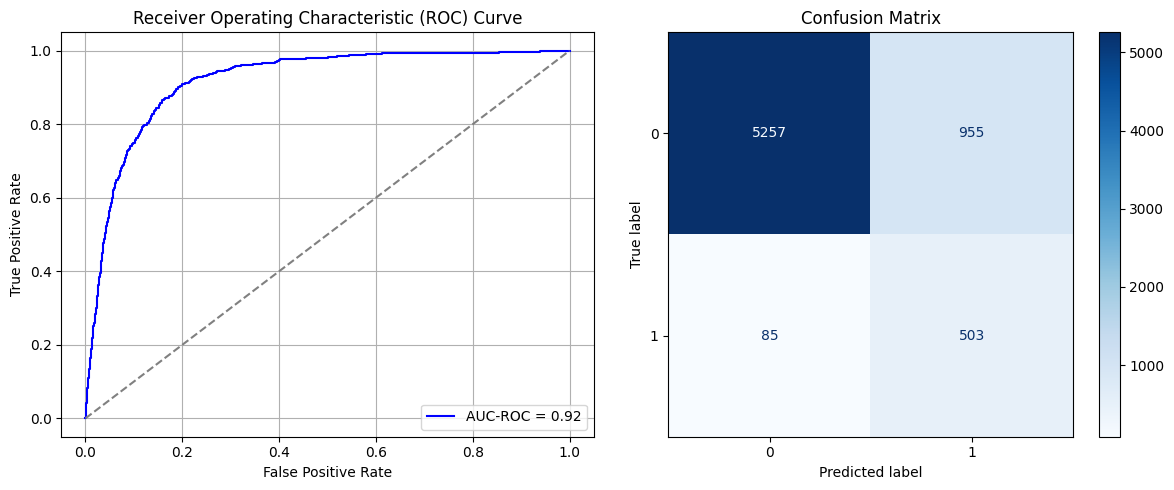

Best threshold based on F1-score: 0.9986090660095215
False Negative Rate: 0.1445578231292517
Time elapsed (performance): 1.0273387179998963
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6812 - loss: 0.6527 - val_AUC: 0.7484 - val_loss: 0.6066
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7801 - loss: 0.5690 - val_AUC: 0.8365 - val_loss: 0.5211
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8445 - loss: 0.5013 - val_AUC: 0.8655 - val_loss: 0.4768
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8643 - loss: 0.4649 - val_AUC: 0.8728 - val_loss: 0.4557
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8685 - loss: 0.4560 - val_AUC: 0.8753 - val_loss: 0.4488
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8637 - loss: 0.4612 - val_AUC: 0.8762 - val_loss: 0.4467
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4390 - val_AUC: 0.8781 - val_loss: 0.4422
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8748 - loss: 0.4439 - val_AUC: 0.8783 - val_loss: 0.4434
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8735 -

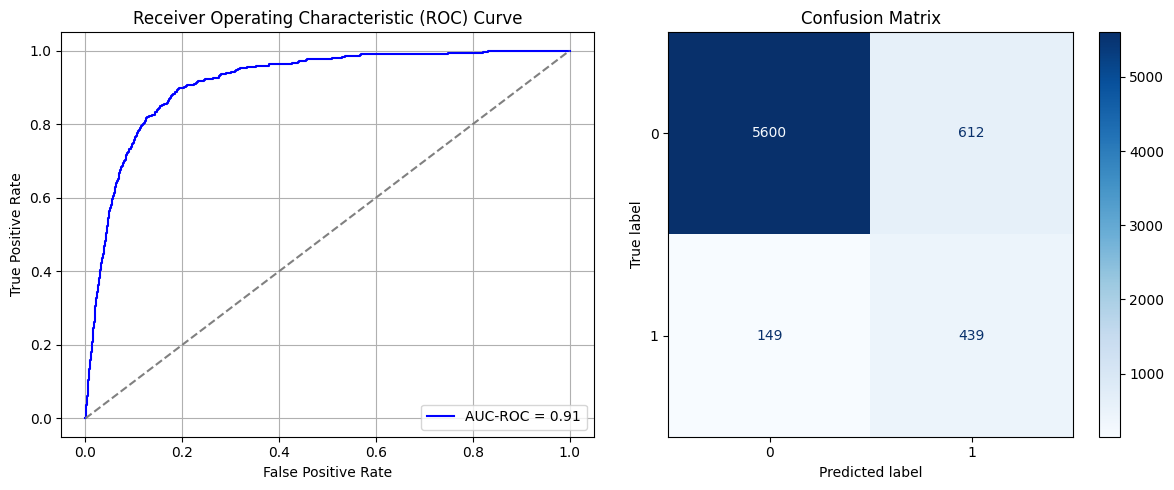

Best threshold based on F1-score: 0.5885415077209473
False Negative Rate: 0.2534013605442177
Time elapsed (performance): 0.7421921430000111
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6556 - loss: 0.6606 - val_AUC: 0.7557 - val_loss: 0.5909
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8026 - loss: 0.5519 - val_AUC: 0.8434 - val_loss: 0.5099
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8618 - loss: 0.4807 - val_AUC: 0.8672 - val_loss: 0.4676
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4564 - val_AUC: 0.8708 - val_loss: 0.4660
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4391 - val_AUC: 0.8754 - val_loss: 0.4526
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4471 - val_AUC: 0.8747 - val_loss: 0.4517
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4280 - val_AUC: 0.8772 - val_loss: 0.4465
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4146 - val_AUC: 0.8772 - val_loss: 0.4453
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 -

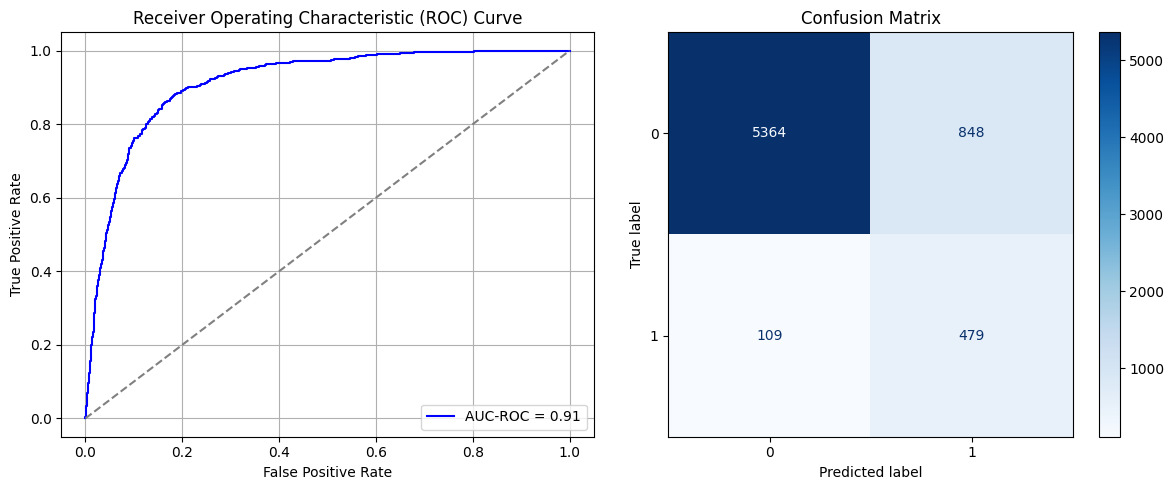

Best threshold based on F1-score: 0.6748934388160706
False Negative Rate: 0.18537414965986396
Time elapsed (performance): 0.72170830999994
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6809 - loss: 0.6516 - val_AUC: 0.7718 - val_loss: 0.5860
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7885 - loss: 0.5632 - val_AUC: 0.8465 - val_loss: 0.5014
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8485 - loss: 0.4936 - val_AUC: 0.8777 - val_loss: 0.4689
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8690 - loss: 0.4597 - val_AUC: 0.8800 - val_loss: 0.4556
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8786 - loss: 0.4425 - val_AUC: 0.8848 - val_loss: 0.4358
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4383 - val_AUC: 0.8832 - val_loss: 0.4539
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4349 - val_AUC: 0.8852 - val_loss: 0.4314
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4209 - val_AUC: 0.8868 - val_loss: 0.4398
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 -

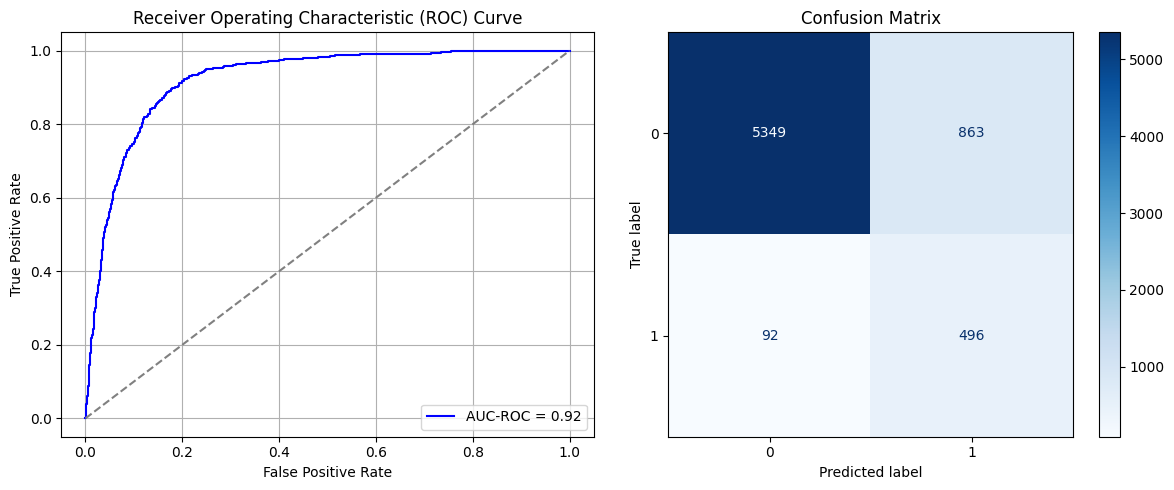

Best threshold based on F1-score: 0.9985111355781555
False Negative Rate: 0.1564625850340136
Time elapsed (performance): 0.7078258149999783
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6535 - loss: 0.6615 - val_AUC: 0.7732 - val_loss: 0.5832
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7673 - loss: 0.5810 - val_AUC: 0.8607 - val_loss: 0.5131
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8470 - loss: 0.5002 - val_AUC: 0.8803 - val_loss: 0.4581
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8801 - loss: 0.4485 - val_AUC: 0.8834 - val_loss: 0.4603
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4520 - val_AUC: 0.8844 - val_loss: 0.4376
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8769 - loss: 0.4473 - val_AUC: 0.8857 - val_loss: 0.4383
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4233 - val_AUC: 0.8870 - val_loss: 0.4283
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4295 - val_AUC: 0.8895 - val_loss: 0.4186
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 -

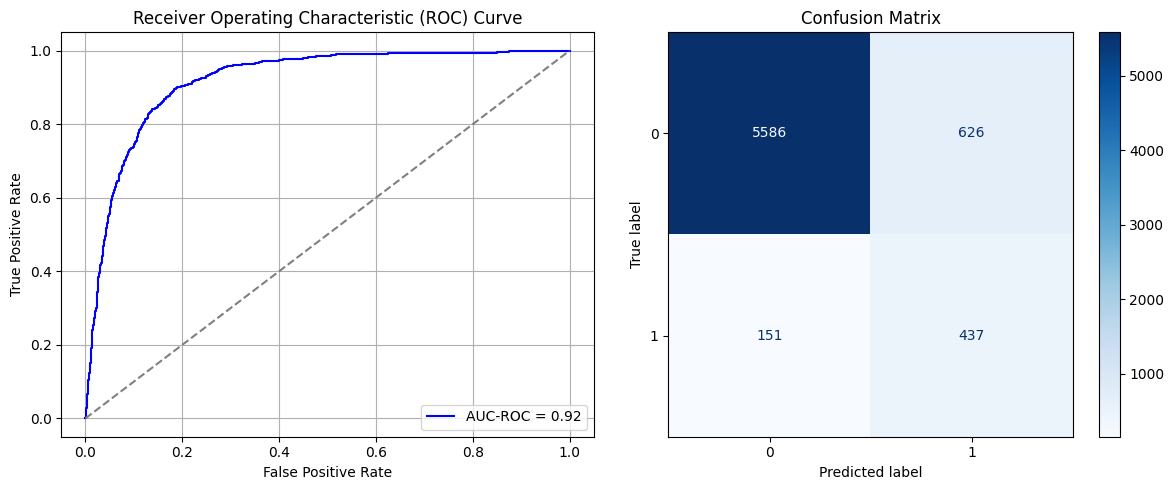

Best threshold based on F1-score: 0.9963980317115784
False Negative Rate: 0.2568027210884354
Time elapsed (performance): 1.0127605920000633
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6075 - loss: 0.6686 - val_AUC: 0.7514 - val_loss: 0.5951
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7756 - loss: 0.5743 - val_AUC: 0.8366 - val_loss: 0.5216
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8444 - loss: 0.5057 - val_AUC: 0.8638 - val_loss: 0.4745
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8748 - loss: 0.4569 - val_AUC: 0.8708 - val_loss: 0.4748
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8689 - loss: 0.4606 - val_AUC: 0.8703 - val_loss: 0.4542
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8787 - loss: 0.4403 - val_AUC: 0.8741 - val_loss: 0.4495
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8788 - loss: 0.4438 - val_AUC: 0.8755 - val_loss: 0.4508
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4317 - val_AUC: 0.8755 - val_loss: 0.4443
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 -

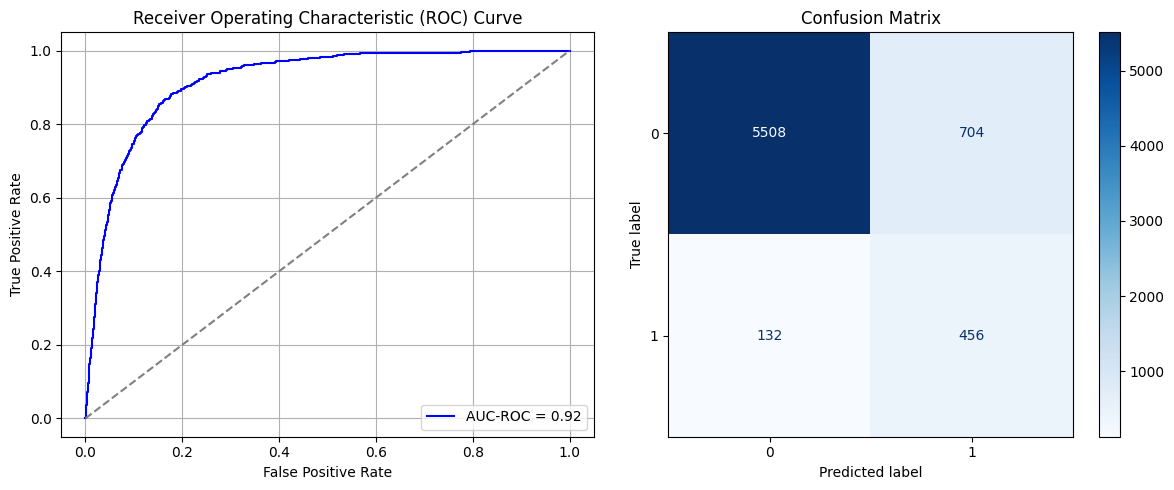

Best threshold based on F1-score: 0.995503842830658
False Negative Rate: 0.22448979591836735
Time elapsed (performance): 1.0260171009999794
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6810 - loss: 0.6490 - val_AUC: 0.7705 - val_loss: 0.5836
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8036 - loss: 0.5514 - val_AUC: 0.8581 - val_loss: 0.4918
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8625 - loss: 0.4748 - val_AUC: 0.8790 - val_loss: 0.4481
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4295 - val_AUC: 0.8826 - val_loss: 0.4359
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4299 - val_AUC: 0.8846 - val_loss: 0.4343
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4232 - val_AUC: 0.8839 - val_loss: 0.4401
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4300 - val_AUC: 0.8854 - val_loss: 0.4267
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8891 - loss: 0.4189 - val_AUC: 0.8864 - val_loss: 0.4242
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8843 -

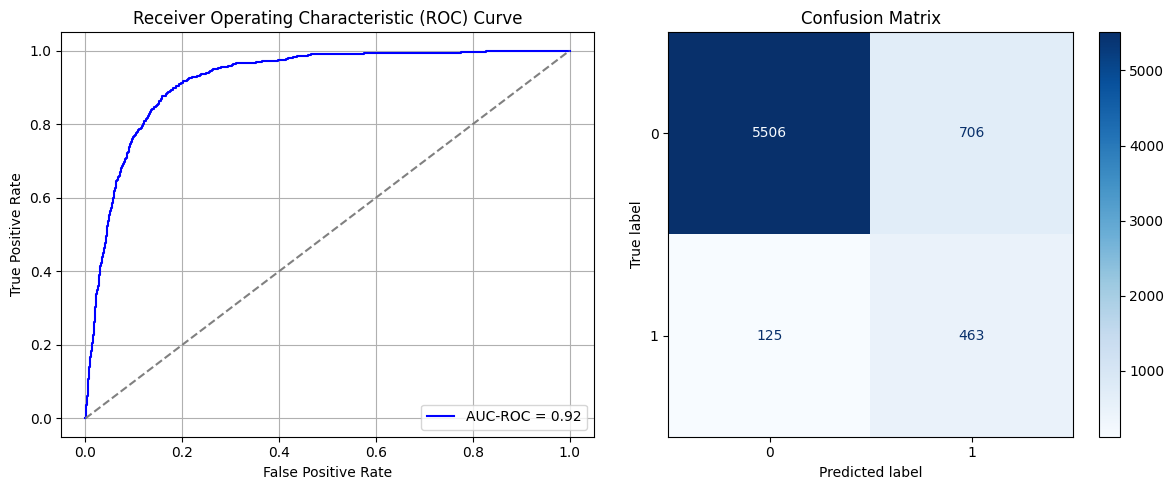

Best threshold based on F1-score: 0.9985299706459045
False Negative Rate: 0.21258503401360543
Time elapsed (performance): 0.7596564289999606
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6548 - loss: 0.6543 - val_AUC: 0.7594 - val_loss: 0.5902
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7696 - loss: 0.5798 - val_AUC: 0.8431 - val_loss: 0.5100
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8524 - loss: 0.4951 - val_AUC: 0.8758 - val_loss: 0.4549
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8697 - loss: 0.4606 - val_AUC: 0.8825 - val_loss: 0.4412
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8783 - loss: 0.4455 - val_AUC: 0.8835 - val_loss: 0.4537
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4238 - val_AUC: 0.8867 - val_loss: 0.4365
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4342 - val_AUC: 0.8874 - val_loss: 0.4256
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4315 - val_AUC: 0.8875 - val_loss: 0.4473
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8722 -

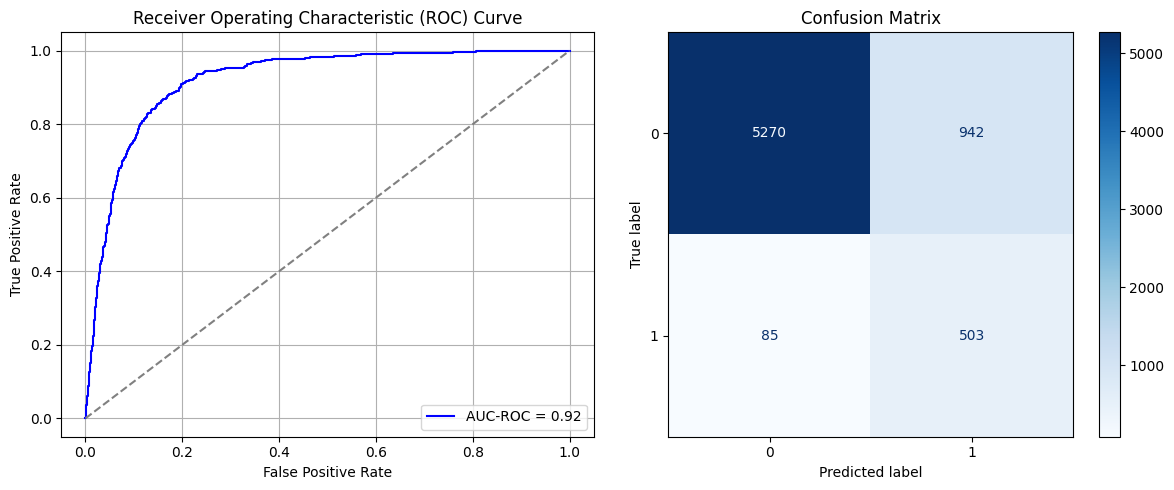

Best threshold based on F1-score: 0.9989911913871765
False Negative Rate: 0.1445578231292517
Time elapsed (performance): 0.7562965780000468


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [41]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
    data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :-1]
    y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
    model_SRSwR = create_dnn_model(X_S_train.shape[1])
    result_SRSwR = train_and_evaluate(model_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRSwR = Transductive_TL(model_SRSwR, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRSwR)
    FPR.append(result_TL_SRSwR[0])
    TNR.append(result_TL_SRSwR[1])
    FNR.append(result_TL_SRSwR[2])
    TPR.append(result_TL_SRSwR[3])
    TL_time.append(result_TL_SRSwR[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [42]:
print(ParamFit)
ParamFit.to_csv('SRSwR_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    10.174706  0.207985  0.792015  0.085034  0.914966     0.734869
1    10.015106  0.138925  0.861075  0.170068  0.829932     0.707527
2     8.658629  0.153735  0.846265  0.144558  0.855442     1.027339
3     8.663126  0.098519  0.901481  0.253401  0.746599     0.742192
4     9.684642  0.136510  0.863490  0.185374  0.814626     0.721708
5    10.966282  0.138925  0.861075  0.156463  0.843537     0.707826
6     9.258066  0.100773  0.899227  0.256803  0.743197     1.012761
7    10.530481  0.113329  0.886671  0.224490  0.775510     1.026017
8     9.893883  0.113651  0.886349  0.212585  0.787415     0.759656
9    11.376599  0.151642  0.848358  0.144558  0.855442     0.756297


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

7.209564628919468
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6335 - loss: 0.6598 - val_AUC: 0.7626 - val_loss: 0.5826
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7950 - loss: 0.5564 - val_AUC: 0.8468 - val_loss: 0.5126
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8490 - loss: 0.4974 - val_AUC: 0.8666 - val_loss: 0.4708
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8597 - loss: 0.4739 - val_AUC: 0.8725 - val_loss: 0.4651
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8811 - loss: 0.4399 - val_AUC: 0.8722 - val_loss: 0.4631
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8792 - loss: 0.4418 - val_AUC: 0.8743 - val_loss: 0.4637
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4355 - val_AUC: 0.8708 - val_loss: 0.4524
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8832 - loss: 0.4361 - val_AUC: 0.8797 - val_loss: 0.4428
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 -

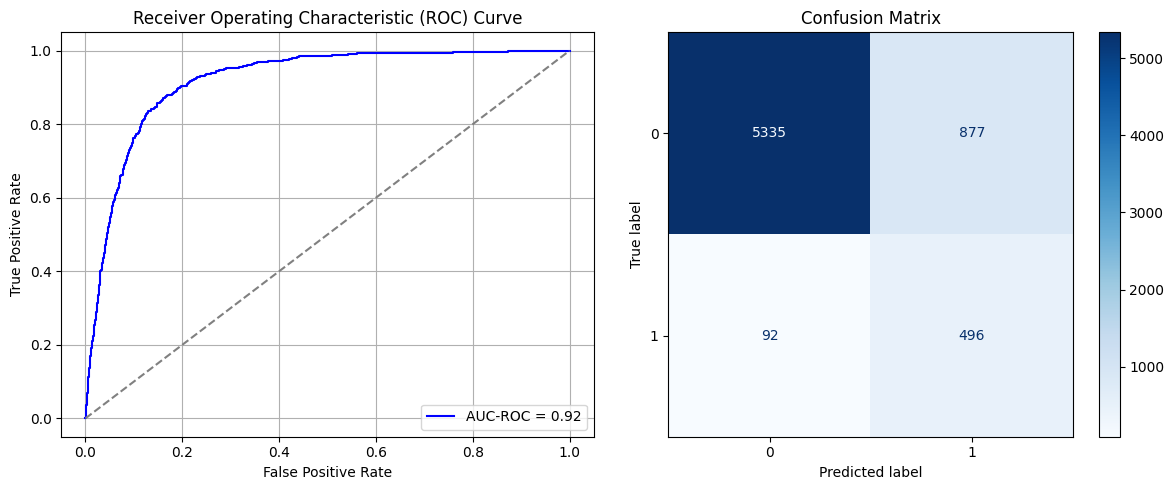

Best threshold based on F1-score: 0.9964190721511841
False Negative Rate: 0.1564625850340136
Time elapsed (performance): 1.0705963630000497
(np.float64(0.14117836445589182), np.float64(0.8588216355441082))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6566 - loss: 0.6549 - val_AUC: 0.7524 - val_loss: 0.5912
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7766 - loss: 0.5742 - val_AUC: 0.8364 - val_loss: 0.5188
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8458 - loss: 0.5004 - val_AUC: 0.8697 - val_loss: 0.4943
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8717 - loss: 0.4611 - val_AUC: 0.8739 - val_loss: 0.4538
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8790 - loss: 0.4414 - val_AUC: 0.8763 - val_loss: 0.4549
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4345 - val_AUC: 0.8795 - val_loss: 0.4428
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4295 - val_AUC: 0.8801 - val_loss: 0.4453
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4208 - val_AUC: 0.8788 - val_loss: 0.4402
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 -

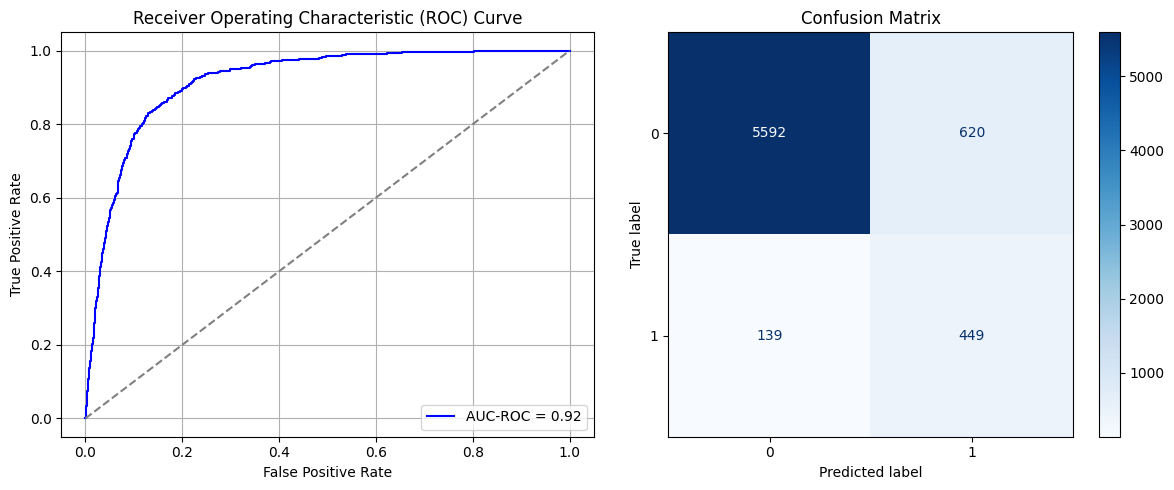

Best threshold based on F1-score: 0.9987136721611023
False Negative Rate: 0.23639455782312926
Time elapsed (performance): 1.0167283270000098
(np.float64(0.09980682549903412), np.float64(0.9001931745009659))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6650 - loss: 0.6551 - val_AUC: 0.7924 - val_loss: 0.5678
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8082 - loss: 0.5447 - val_AUC: 0.8637 - val_loss: 0.4774
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8633 - loss: 0.4729 - val_AUC: 0.8827 - val_loss: 0.4452
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8742 - loss: 0.4509 - val_AUC: 0.8860 - val_loss: 0.4441
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8782 - loss: 0.4440 - val_AUC: 0.8880 - val_loss: 0.4276
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4346 - val_AUC: 0.8881 - val_loss: 0.4231
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4299 - val_AUC: 0.8892 - val_loss: 0.4192
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.4087 - val_AUC: 0.8908 - val_loss: 0.4170
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 -

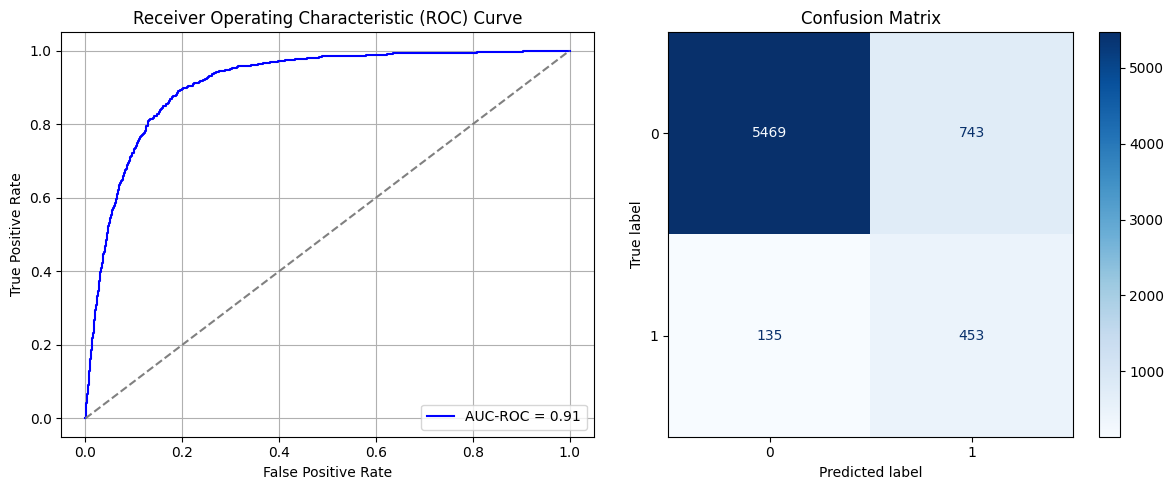

Best threshold based on F1-score: 0.9929226636886597
False Negative Rate: 0.22959183673469388
Time elapsed (performance): 0.7350148630000604
(np.float64(0.11960721184803606), np.float64(0.880392788151964))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6375 - loss: 0.6626 - val_AUC: 0.7694 - val_loss: 0.5837
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7705 - loss: 0.5759 - val_AUC: 0.8413 - val_loss: 0.5170
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8444 - loss: 0.5017 - val_AUC: 0.8708 - val_loss: 0.4686
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8765 - loss: 0.4529 - val_AUC: 0.8793 - val_loss: 0.4505
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.4235 - val_AUC: 0.8809 - val_loss: 0.4454
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4318 - val_AUC: 0.8798 - val_loss: 0.4454
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4250 - val_AUC: 0.8801 - val_loss: 0.4397
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4315 - val_AUC: 0.8808 - val_loss: 0.4375
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 -

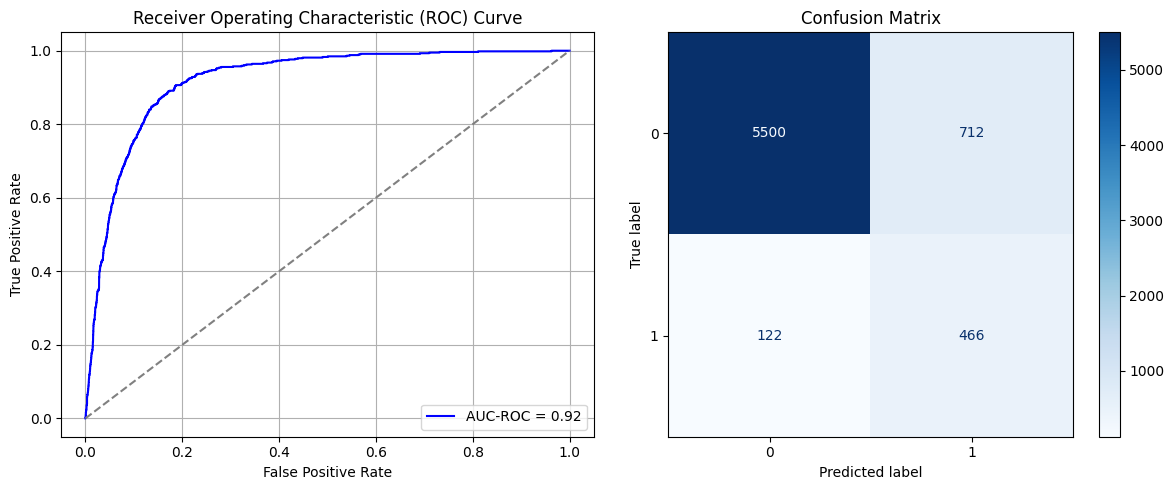

Best threshold based on F1-score: 0.9928044676780701
False Negative Rate: 0.20748299319727892
Time elapsed (performance): 0.7259904979999874
(np.float64(0.11461687057308435), np.float64(0.8853831294269157))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6591 - loss: 0.6548 - val_AUC: 0.7684 - val_loss: 0.5941
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7850 - loss: 0.5648 - val_AUC: 0.8456 - val_loss: 0.5138
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8532 - loss: 0.4952 - val_AUC: 0.8666 - val_loss: 0.4742
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8683 - loss: 0.4636 - val_AUC: 0.8693 - val_loss: 0.4669
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8660 - loss: 0.4648 - val_AUC: 0.8726 - val_loss: 0.4517
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8753 - loss: 0.4490 - val_AUC: 0.8710 - val_loss: 0.4578
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8801 - loss: 0.4398 - val_AUC: 0.8742 - val_loss: 0.4727
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8776 - loss: 0.4422 - val_AUC: 0.8703 - val_loss: 0.4588
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8799 -

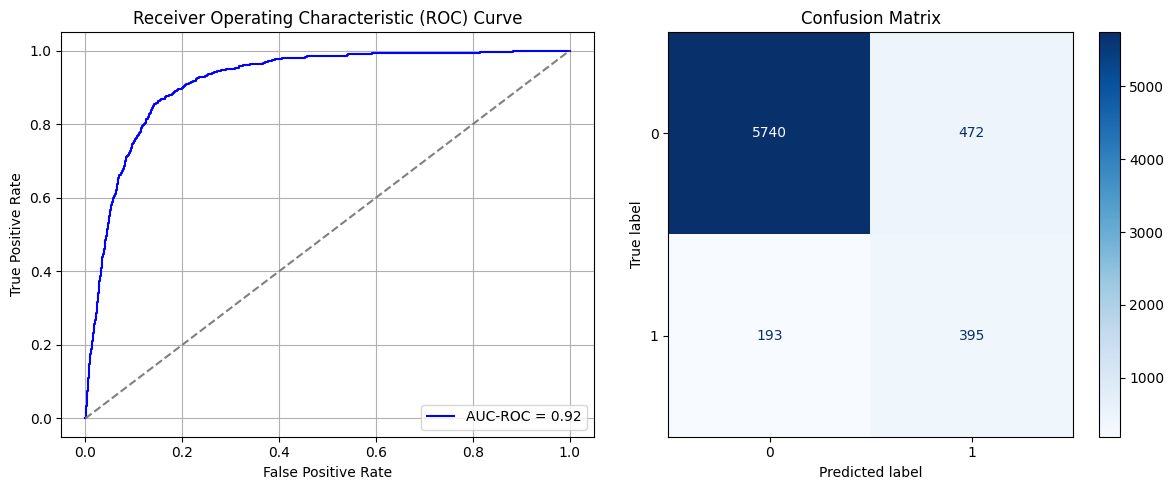

Best threshold based on F1-score: 0.9933168888092041
False Negative Rate: 0.3282312925170068
Time elapsed (performance): 0.7145929590000151
(np.float64(0.07598197037990985), np.float64(0.9240180296200902))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6444 - loss: 0.6616 - val_AUC: 0.7667 - val_loss: 0.5888
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7878 - loss: 0.5607 - val_AUC: 0.8590 - val_loss: 0.4979
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8524 - loss: 0.4911 - val_AUC: 0.8795 - val_loss: 0.4559
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8782 - loss: 0.4456 - val_AUC: 0.8843 - val_loss: 0.4470
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4351 - val_AUC: 0.8846 - val_loss: 0.4371
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4320 - val_AUC: 0.8868 - val_loss: 0.4265
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4224 - val_AUC: 0.8866 - val_loss: 0.4453
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4287 - val_AUC: 0.8864 - val_loss: 0.4266
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 -

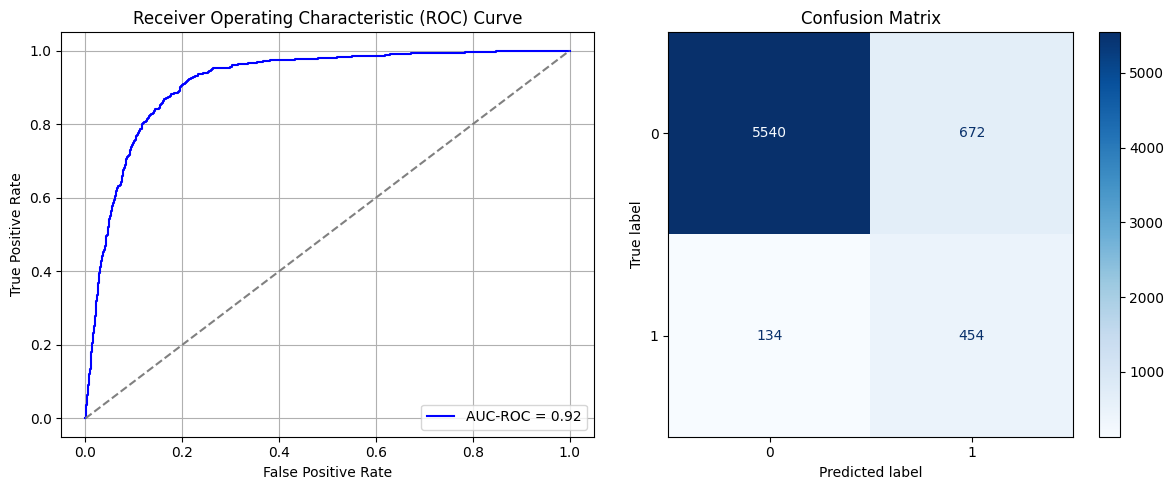

Best threshold based on F1-score: 0.9941290616989136
False Negative Rate: 0.22789115646258504
Time elapsed (performance): 1.7749868009999545
(np.float64(0.1081777205408886), np.float64(0.8918222794591114))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6724 - loss: 0.6550 - val_AUC: 0.7592 - val_loss: 0.5908
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7804 - loss: 0.5705 - val_AUC: 0.8271 - val_loss: 0.5262
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8476 - loss: 0.4999 - val_AUC: 0.8627 - val_loss: 0.4772
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8587 - loss: 0.4816 - val_AUC: 0.8700 - val_loss: 0.4640
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8684 - loss: 0.4614 - val_AUC: 0.8729 - val_loss: 0.4556
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4372 - val_AUC: 0.8731 - val_loss: 0.4510
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4311 - val_AUC: 0.8727 - val_loss: 0.4484
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8774 - loss: 0.4409 - val_AUC: 0.8752 - val_loss: 0.4547
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 -

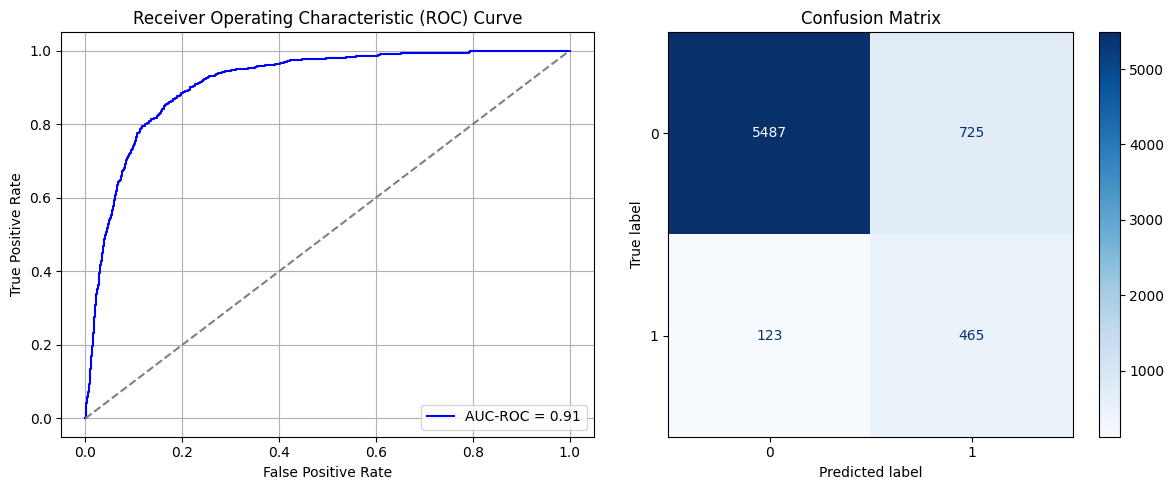

Best threshold based on F1-score: 0.6832236647605896
False Negative Rate: 0.20918367346938777
Time elapsed (performance): 1.1502237749999722
(np.float64(0.11670959433354797), np.float64(0.883290405666452))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6472 - loss: 0.6663 - val_AUC: 0.7530 - val_loss: 0.5915
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7704 - loss: 0.5773 - val_AUC: 0.8303 - val_loss: 0.5214
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8487 - loss: 0.4999 - val_AUC: 0.8667 - val_loss: 0.4717
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8788 - loss: 0.4547 - val_AUC: 0.8702 - val_loss: 0.4612
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8772 - loss: 0.4531 - val_AUC: 0.8653 - val_loss: 0.4907
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8730 - loss: 0.4549 - val_AUC: 0.8718 - val_loss: 0.4545
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4439 - val_AUC: 0.8708 - val_loss: 0.4555
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8772 - loss: 0.4515 - val_AUC: 0.8743 - val_loss: 0.4494
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8847 -

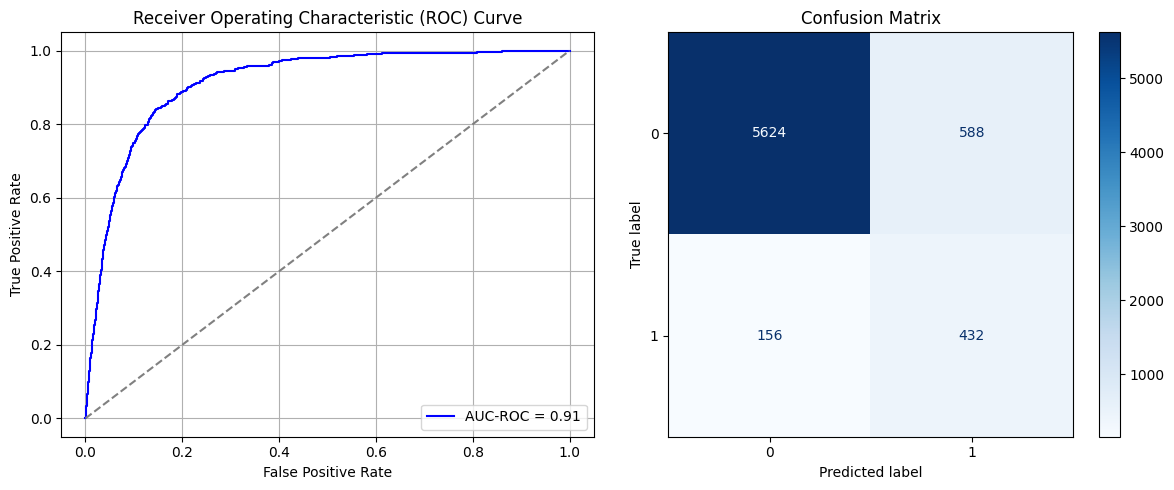

Best threshold based on F1-score: 0.9979361295700073
False Negative Rate: 0.2653061224489796
Time elapsed (performance): 0.777186754000013
(np.float64(0.09465550547327753), np.float64(0.9053444945267225))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6533 - loss: 0.6569 - val_AUC: 0.7696 - val_loss: 0.5788
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8035 - loss: 0.5516 - val_AUC: 0.8623 - val_loss: 0.4884
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8624 - loss: 0.4765 - val_AUC: 0.8771 - val_loss: 0.4733
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8682 - loss: 0.4611 - val_AUC: 0.8788 - val_loss: 0.4567
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4482 - val_AUC: 0.8797 - val_loss: 0.4450
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4416 - val_AUC: 0.8802 - val_loss: 0.4428
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8805 - loss: 0.4422 - val_AUC: 0.8820 - val_loss: 0.4452
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4337 - val_AUC: 0.8837 - val_loss: 0.4376
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 -

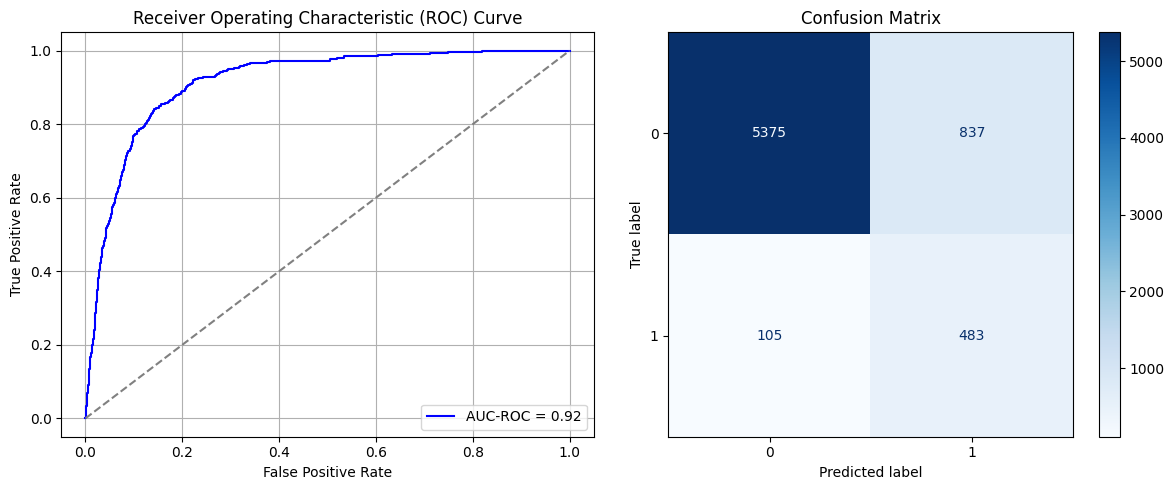

Best threshold based on F1-score: 0.6350396275520325
False Negative Rate: 0.17857142857142858
Time elapsed (performance): 1.0168377789999568
(np.float64(0.13473921442369607), np.float64(0.8652607855763039))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6744 - loss: 0.6474 - val_AUC: 0.7844 - val_loss: 0.5699
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8056 - loss: 0.5457 - val_AUC: 0.8557 - val_loss: 0.5003
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8615 - loss: 0.4835 - val_AUC: 0.8699 - val_loss: 0.4816
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8722 - loss: 0.4565 - val_AUC: 0.8756 - val_loss: 0.4487
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8794 - loss: 0.4415 - val_AUC: 0.8748 - val_loss: 0.4601
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4279 - val_AUC: 0.8768 - val_loss: 0.4415
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4389 - val_AUC: 0.8781 - val_loss: 0.4463
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4133 - val_AUC: 0.8778 - val_loss: 0.4400
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 -

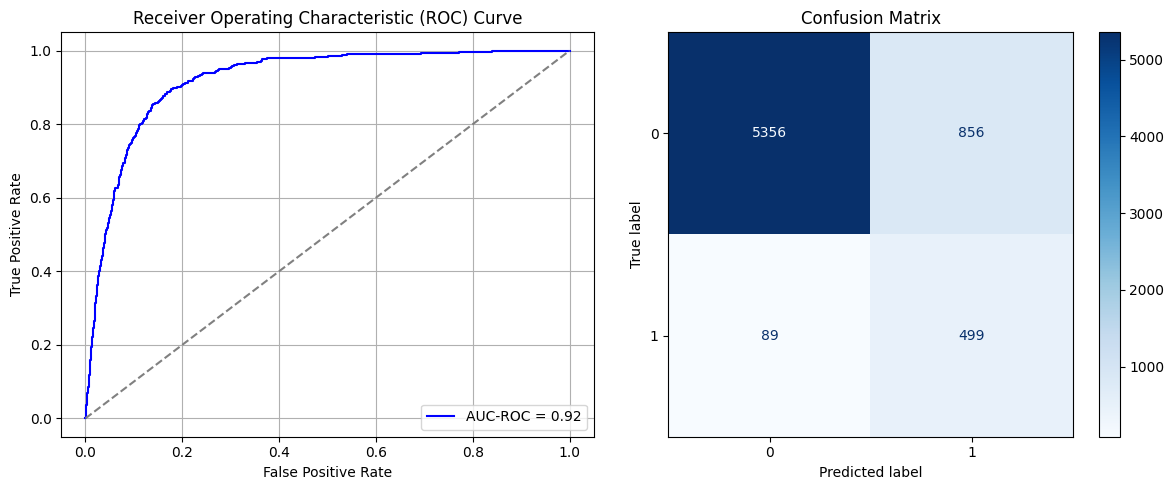

Best threshold based on F1-score: 0.9971144795417786
False Negative Rate: 0.15136054421768708
Time elapsed (performance): 1.009121897
(np.float64(0.13779781068898905), np.float64(0.862202189311011))
   Source time       FPR       TNR       FNR       TPR  Target time
0     9.054806  0.141178  0.858822  0.156463  0.843537     1.070596
1     7.927417  0.099807  0.900193  0.236395  0.763605     1.016728
2     9.042816  0.119607  0.880393  0.229592  0.770408     0.735015
3     9.244182  0.114617  0.885383  0.207483  0.792517     0.725990
4     9.718470  0.075982  0.924018  0.328231  0.671769     0.714593
5     8.802460  0.108178  0.891822  0.227891  0.772109     1.774987
6     8.317125  0.116710  0.883290  0.209184  0.790816     1.150224
7     9.125823  0.094656  0.905344  0.265306  0.734694     0.777187
8     9.693044  0.134739  0.865261  0.178571  0.821429     1.016838
9     9.197864  0.137798  0.862202  0.151361  0.848639     1.009122


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [43]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)


In [44]:
print(ParamFit)
ParamFit.to_csv('Sy_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0     9.054806  0.141178  0.858822  0.156463  0.843537     1.070596
1     7.927417  0.099807  0.900193  0.236395  0.763605     1.016728
2     9.042816  0.119607  0.880393  0.229592  0.770408     0.735015
3     9.244182  0.114617  0.885383  0.207483  0.792517     0.725990
4     9.718470  0.075982  0.924018  0.328231  0.671769     0.714593
5     8.802460  0.108178  0.891822  0.227891  0.772109     1.774987
6     8.317125  0.116710  0.883290  0.209184  0.790816     1.150224
7     9.125823  0.094656  0.905344  0.265306  0.734694     0.777187
8     9.693044  0.134739  0.865261  0.178571  0.821429     1.016838
9     9.197864  0.137798  0.862202  0.151361  0.848639     1.009122


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

72.09564628919468
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6555 - loss: 0.6562 - val_AUC: 0.7614 - val_loss: 0.5875
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8063 - loss: 0.5462 - val_AUC: 0.8398 - val_loss: 0.5032
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8627 - loss: 0.4767 - val_AUC: 0.8649 - val_loss: 0.4689
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8762 - loss: 0.4511 - val_AUC: 0.8710 - val_loss: 0.4604
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8796 - loss: 0.4418 - val_AUC: 0.8717 - val_loss: 0.4540
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8898 - loss: 0.4230 - val_AUC: 0.8737 - val_loss: 0.4500
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4205 - val_AUC: 0.8756 - val_loss: 0.4439
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8913 - loss: 0.4143 - val_AUC: 0.8752 - val_loss: 0.4580
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8788 -

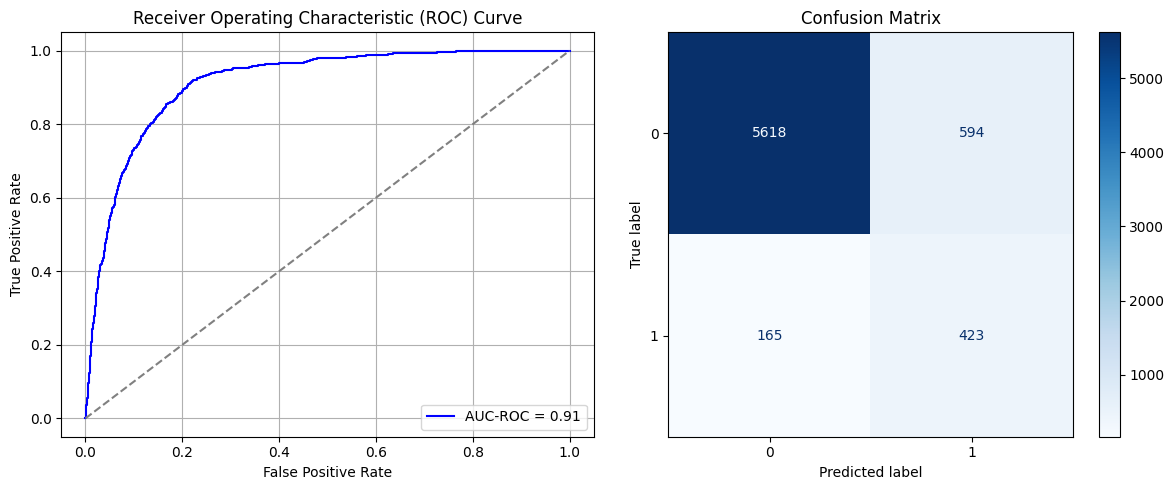

Best threshold based on F1-score: 0.993649959564209
False Negative Rate: 0.28061224489795916
Time elapsed (performance): 0.6930036599999312
(np.float64(0.0956213779781069), np.float64(0.9043786220218931))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6916 - loss: 0.6503 - val_AUC: 0.7586 - val_loss: 0.5914
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7831 - loss: 0.5677 - val_AUC: 0.8320 - val_loss: 0.5207
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8522 - loss: 0.4906 - val_AUC: 0.8536 - val_loss: 0.4886
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8633 - loss: 0.4704 - val_AUC: 0.8624 - val_loss: 0.4739
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8676 - loss: 0.4602 - val_AUC: 0.8625 - val_loss: 0.4768
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4476 - val_AUC: 0.8659 - val_loss: 0.4716
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4400 - val_AUC: 0.8651 - val_loss: 0.4702
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4318 - val_AUC: 0.8683 - val_loss: 0.4694
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 -

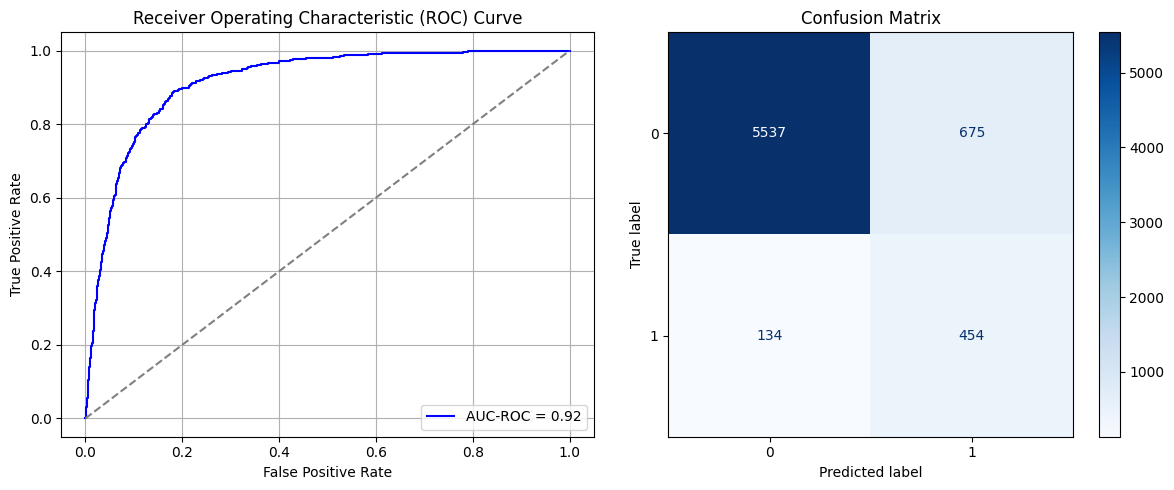

Best threshold based on F1-score: 0.9996983408927917
False Negative Rate: 0.22789115646258504
Time elapsed (performance): 0.7077975800000331
(np.float64(0.10866065679330328), np.float64(0.8913393432066967))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6752 - loss: 0.6541 - val_AUC: 0.7663 - val_loss: 0.5809
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7993 - loss: 0.5538 - val_AUC: 0.8525 - val_loss: 0.4936
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8650 - loss: 0.4738 - val_AUC: 0.8776 - val_loss: 0.4633
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8720 - loss: 0.4572 - val_AUC: 0.8838 - val_loss: 0.4314
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8987 - loss: 0.4082 - val_AUC: 0.8941 - val_loss: 0.4203
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4344 - val_AUC: 0.8920 - val_loss: 0.4174
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8891 - loss: 0.4236 - val_AUC: 0.8916 - val_loss: 0.4164
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8850 - loss: 0.4286 - val_AUC: 0.8940 - val_loss: 0.4145
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 -

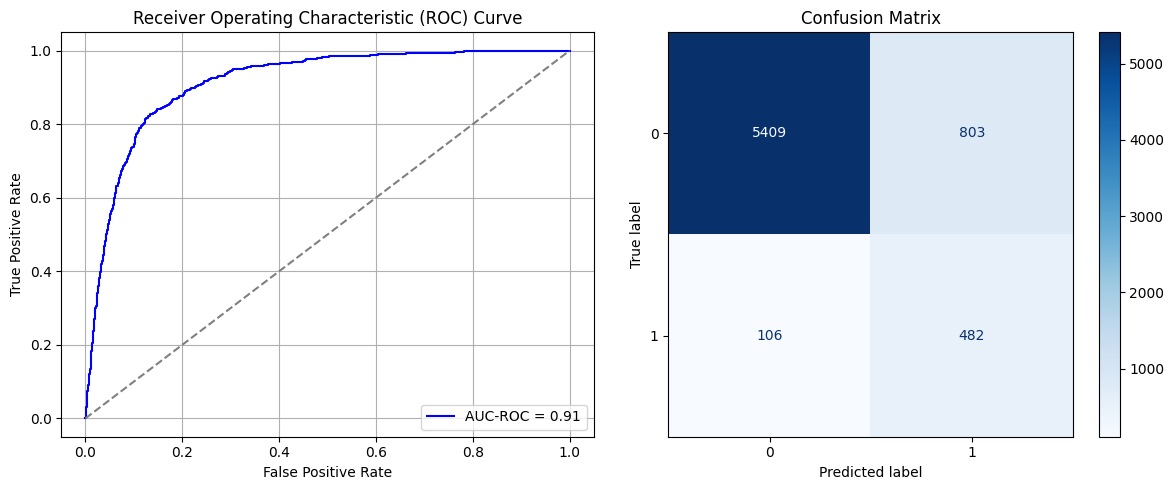

Best threshold based on F1-score: 0.9978266358375549
False Negative Rate: 0.18027210884353742
Time elapsed (performance): 1.0028981960001602
(np.float64(0.12926593689632968), np.float64(0.8707340631036703))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6561 - loss: 0.6575 - val_AUC: 0.7725 - val_loss: 0.5757
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7942 - loss: 0.5540 - val_AUC: 0.8540 - val_loss: 0.4913
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8730 - loss: 0.4609 - val_AUC: 0.8784 - val_loss: 0.4479
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4316 - val_AUC: 0.8845 - val_loss: 0.4387
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4194 - val_AUC: 0.8834 - val_loss: 0.4477
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4355 - val_AUC: 0.8842 - val_loss: 0.4345
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4182 - val_AUC: 0.8829 - val_loss: 0.4342
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9011 - loss: 0.4006 - val_AUC: 0.8836 - val_loss: 0.4320
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9036 -

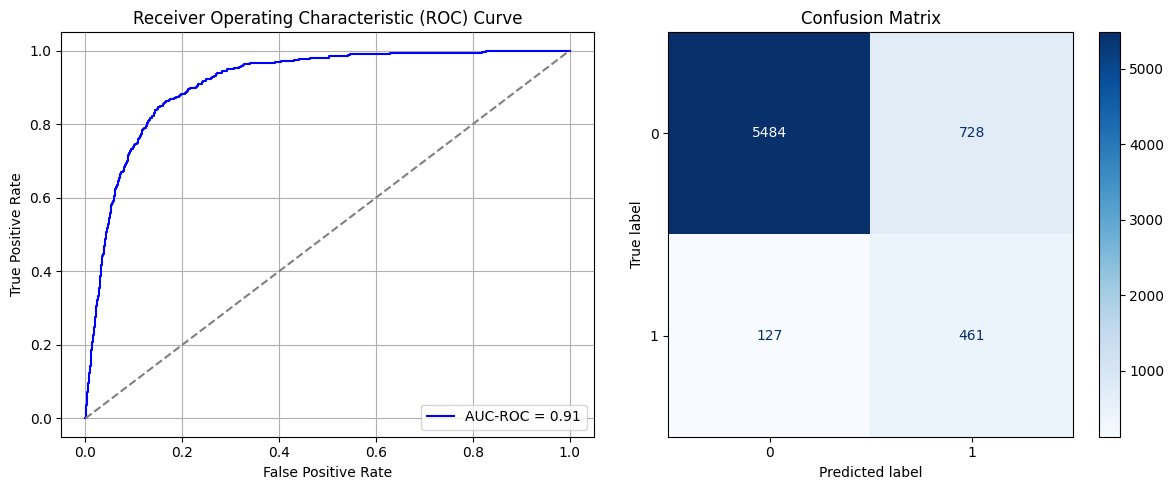

Best threshold based on F1-score: 0.999107301235199
False Negative Rate: 0.21598639455782312
Time elapsed (performance): 1.048105453999824
(np.float64(0.11719253058596266), np.float64(0.8828074694140373))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6572 - loss: 0.6620 - val_AUC: 0.7609 - val_loss: 0.5890
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7822 - loss: 0.5699 - val_AUC: 0.8397 - val_loss: 0.5064
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8565 - loss: 0.4875 - val_AUC: 0.8689 - val_loss: 0.4699
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4482 - val_AUC: 0.8744 - val_loss: 0.4627
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8785 - loss: 0.4485 - val_AUC: 0.8792 - val_loss: 0.4410
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4337 - val_AUC: 0.8800 - val_loss: 0.4494
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4264 - val_AUC: 0.8785 - val_loss: 0.4428
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4345 - val_AUC: 0.8772 - val_loss: 0.4806
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 -

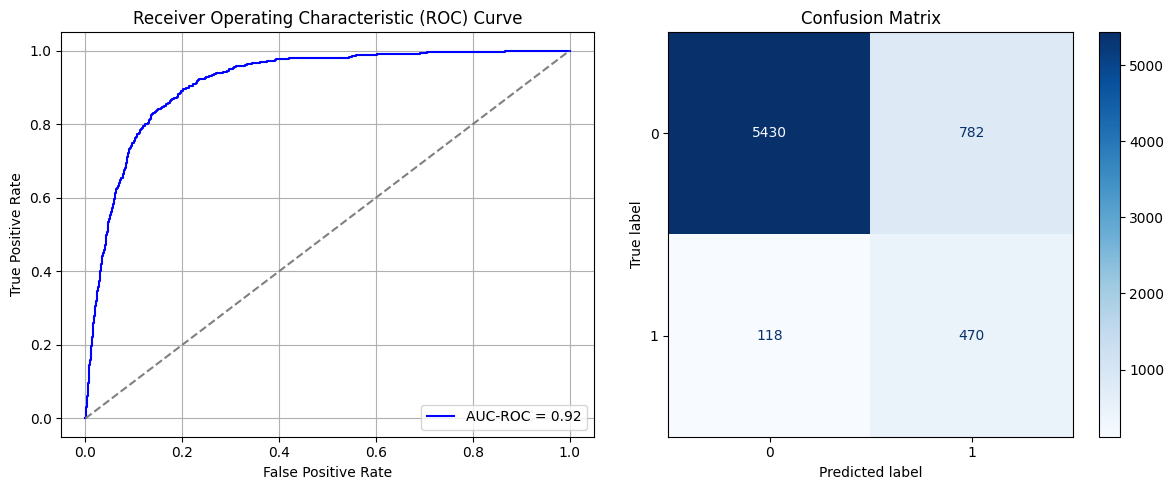

Best threshold based on F1-score: 0.6039085984230042
False Negative Rate: 0.20068027210884354
Time elapsed (performance): 0.717758171000014
(np.float64(0.1258853831294269), np.float64(0.8741146168705731))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6644 - loss: 0.6506 - val_AUC: 0.7678 - val_loss: 0.5931
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8090 - loss: 0.5455 - val_AUC: 0.8487 - val_loss: 0.5035
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8738 - loss: 0.4648 - val_AUC: 0.8653 - val_loss: 0.4694
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4456 - val_AUC: 0.8696 - val_loss: 0.4580
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8756 - loss: 0.4463 - val_AUC: 0.8732 - val_loss: 0.4500
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8824 - loss: 0.4342 - val_AUC: 0.8727 - val_loss: 0.4520
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8805 - loss: 0.4360 - val_AUC: 0.8763 - val_loss: 0.4499
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4230 - val_AUC: 0.8773 - val_loss: 0.4412
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 -

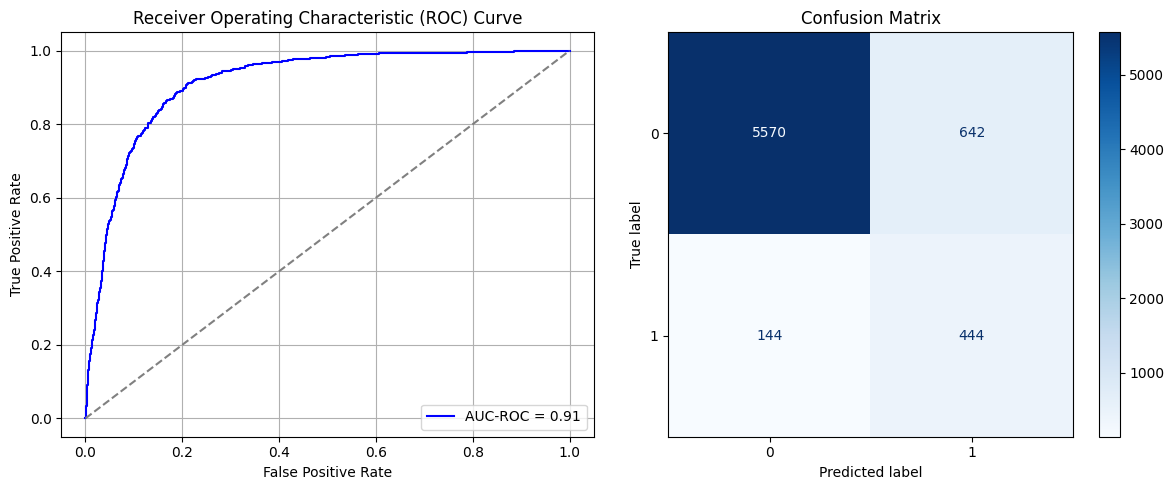

Best threshold based on F1-score: 0.9948927164077759
False Negative Rate: 0.24489795918367346
Time elapsed (performance): 1.0141870770000878
(np.float64(0.10334835801674179), np.float64(0.8966516419832582))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6533 - loss: 0.6558 - val_AUC: 0.7562 - val_loss: 0.6051
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7858 - loss: 0.5641 - val_AUC: 0.8434 - val_loss: 0.5114
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8677 - loss: 0.4732 - val_AUC: 0.8692 - val_loss: 0.4603
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4362 - val_AUC: 0.8746 - val_loss: 0.4515
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4183 - val_AUC: 0.8772 - val_loss: 0.4534
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4207 - val_AUC: 0.8814 - val_loss: 0.4345
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4298 - val_AUC: 0.8792 - val_loss: 0.4559
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.4053 - val_AUC: 0.8822 - val_loss: 0.4357
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 -

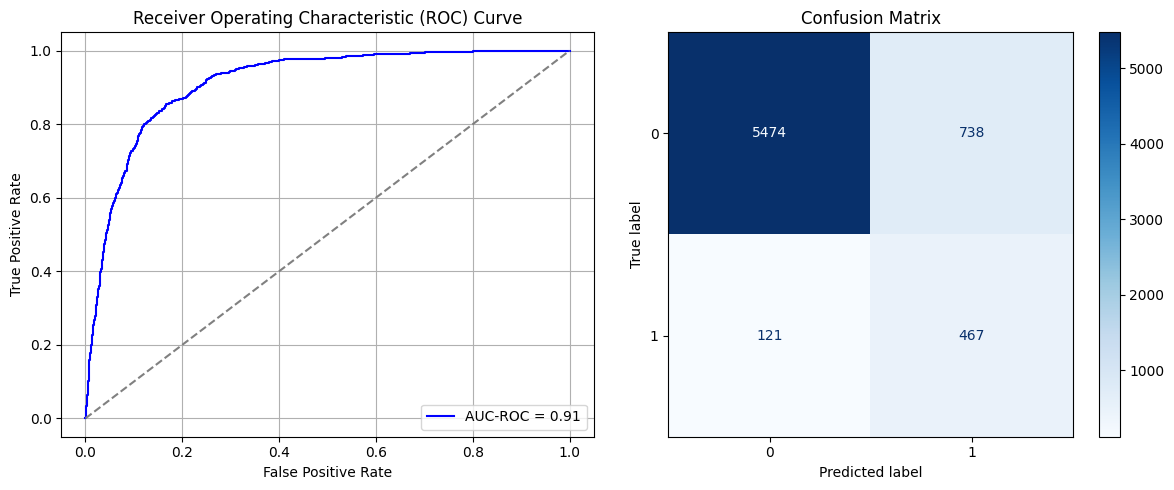

Best threshold based on F1-score: 0.9981015920639038
False Negative Rate: 0.20578231292517007
Time elapsed (performance): 0.7472339349999402
(np.float64(0.1188023180940116), np.float64(0.8811976819059884))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6710 - loss: 0.6554 - val_AUC: 0.7662 - val_loss: 0.5828
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7894 - loss: 0.5627 - val_AUC: 0.8378 - val_loss: 0.5107
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8498 - loss: 0.4930 - val_AUC: 0.8722 - val_loss: 0.4582
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8724 - loss: 0.4545 - val_AUC: 0.8805 - val_loss: 0.4428
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8821 - loss: 0.4377 - val_AUC: 0.8806 - val_loss: 0.4365
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4346 - val_AUC: 0.8842 - val_loss: 0.4293
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4222 - val_AUC: 0.8871 - val_loss: 0.4283
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4303 - val_AUC: 0.8870 - val_loss: 0.4296
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 -

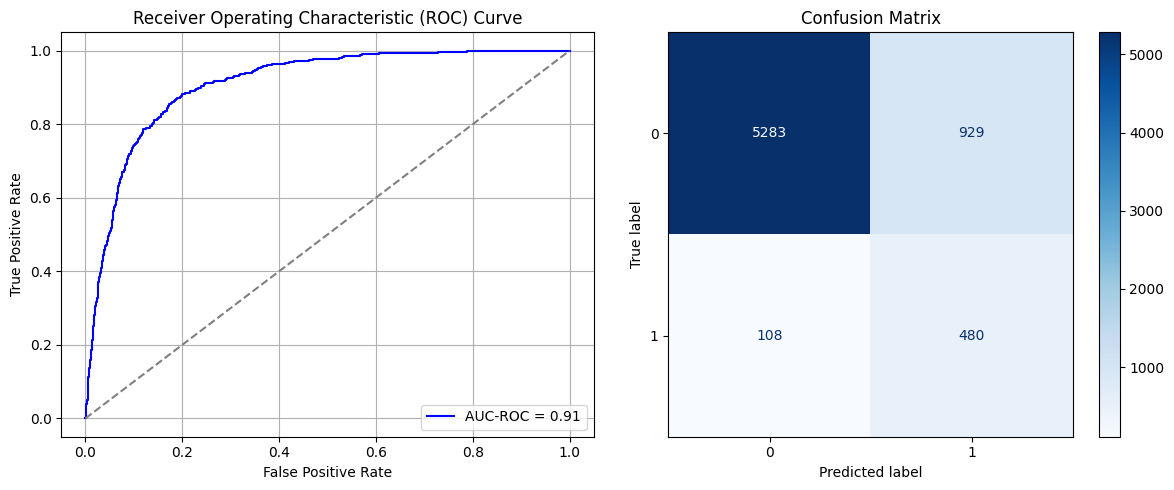

Best threshold based on F1-score: 0.9982706308364868
False Negative Rate: 0.1836734693877551
Time elapsed (performance): 0.75349681900002
(np.float64(0.1495492594977463), np.float64(0.8504507405022537))
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6775 - loss: 0.6504 - val_AUC: 0.7595 - val_loss: 0.5944
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7877 - loss: 0.5626 - val_AUC: 0.8473 - val_loss: 0.5095
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8646 - loss: 0.4717 - val_AUC: 0.8648 - val_loss: 0.4720
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4388 - val_AUC: 0.8736 - val_loss: 0.4646
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4370 - val_AUC: 0.8754 - val_loss: 0.4543
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4290 - val_AUC: 0.8806 - val_loss: 0.4469
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8957 - loss: 0.4155 - val_AUC: 0.8776 - val_loss: 0.4480
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8869 - loss: 0.4294 - val_AUC: 0.8803 - val_loss: 0.4429
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 -

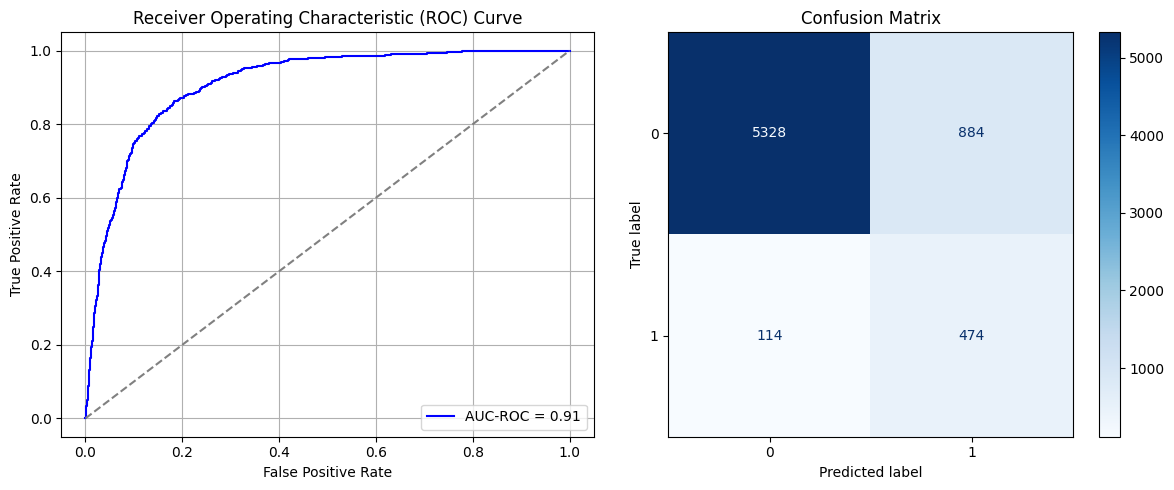

Best threshold based on F1-score: 0.6369840502738953
False Negative Rate: 0.19387755102040816
Time elapsed (performance): 0.760380504000068
(np.float64(0.14230521571152607), np.float64(0.8576947842884739))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6944 - loss: 0.6501 - val_AUC: 0.7554 - val_loss: 0.5986
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7917 - loss: 0.5580 - val_AUC: 0.8362 - val_loss: 0.5100
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8686 - loss: 0.4703 - val_AUC: 0.8622 - val_loss: 0.4714
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8733 - loss: 0.4563 - val_AUC: 0.8674 - val_loss: 0.4613
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4284 - val_AUC: 0.8673 - val_loss: 0.4609
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4263 - val_AUC: 0.8709 - val_loss: 0.4641
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8949 - loss: 0.4140 - val_AUC: 0.8733 - val_loss: 0.4554
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.4115 - val_AUC: 0.8734 - val_loss: 0.4477
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 -

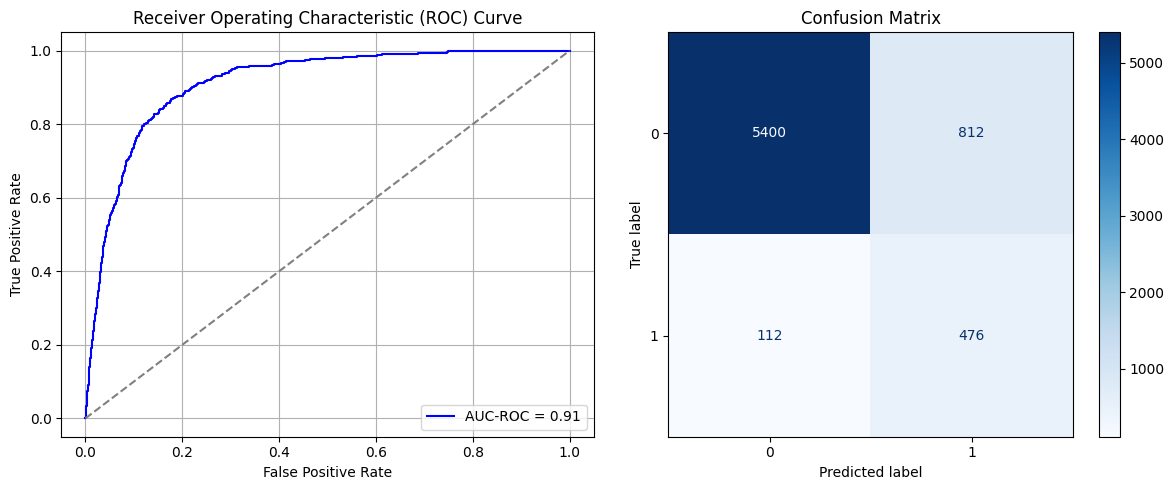

Best threshold based on F1-score: 0.9982717037200928
False Negative Rate: 0.19047619047619047
Time elapsed (performance): 1.0078972700000577
(np.float64(0.13071474565357372), np.float64(0.8692852543464262))
   Source time       FPR       TNR       FNR       TPR  Target time
0     9.179453  0.095621  0.904379  0.280612  0.719388     0.693004
1     9.748961  0.108661  0.891339  0.227891  0.772109     0.707798
2     9.099757  0.129266  0.870734  0.180272  0.819728     1.002898
3     9.127202  0.117193  0.882807  0.215986  0.784014     1.048105
4     8.115426  0.125885  0.874115  0.200680  0.799320     0.717758
5     9.690841  0.103348  0.896652  0.244898  0.755102     1.014187
6     9.334090  0.118802  0.881198  0.205782  0.794218     0.747234
7     9.708844  0.149549  0.850451  0.183673  0.816327     0.753497
8     9.329955  0.142305  0.857695  0.193878  0.806122     0.760381
9     9.241386  0.130715  0.869285  0.190476  0.809524     1.007897


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [45]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), 10)
    # print(start)

    Row = []

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)

In [46]:
print(ParamFit)
ParamFit.to_csv('Sy2_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0     9.179453  0.095621  0.904379  0.280612  0.719388     0.693004
1     9.748961  0.108661  0.891339  0.227891  0.772109     0.707798
2     9.099757  0.129266  0.870734  0.180272  0.819728     1.002898
3     9.127202  0.117193  0.882807  0.215986  0.784014     1.048105
4     8.115426  0.125885  0.874115  0.200680  0.799320     0.717758
5     9.690841  0.103348  0.896652  0.244898  0.755102     1.014187
6     9.334090  0.118802  0.881198  0.205782  0.794218     0.747234
7     9.708844  0.149549  0.850451  0.183673  0.816327     0.753497
8     9.329955  0.142305  0.857695  0.193878  0.806122     0.760381
9     9.241386  0.130715  0.869285  0.190476  0.809524     1.007897


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [47]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

4433
31960


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7847 - loss: 0.5537 - val_AUC: 0.8895 - val_loss: 0.4219
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8836 - loss: 0.4293 - val_AUC: 0.8946 - val_loss: 0.4131
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8903 - loss: 0.4154 - val_AUC: 0.8987 - val_loss: 0.4036
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8922 - loss: 0.4105 - val_AUC: 0.9022 - val_loss: 0.3901
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8951 - loss: 0.4051 - val_AUC: 0.9052 - val_loss: 0.4194
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9043 - loss: 0.3859 - val_AUC: 0.9097 - val_loss: 0.3724
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9112 - loss: 0.3712 - val_AUC: 0.9122 - val_loss: 0.3711
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9151 - loss: 0.3642 - val_AUC: 0.9154 - val_loss: 0.3650
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9274856433236526
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      6212
           1       0.41      0.82      0.55       588

    accuracy                           0.88      6800
   macro avg       0.70      0.86      0.74      6800
weighted avg       0.93      0.88      0.90      6800

FPR 0.11010946555054733 TPR: 0.8248299319727891 FNR: 0.17517006802721088 TNR: 0.8898905344494527


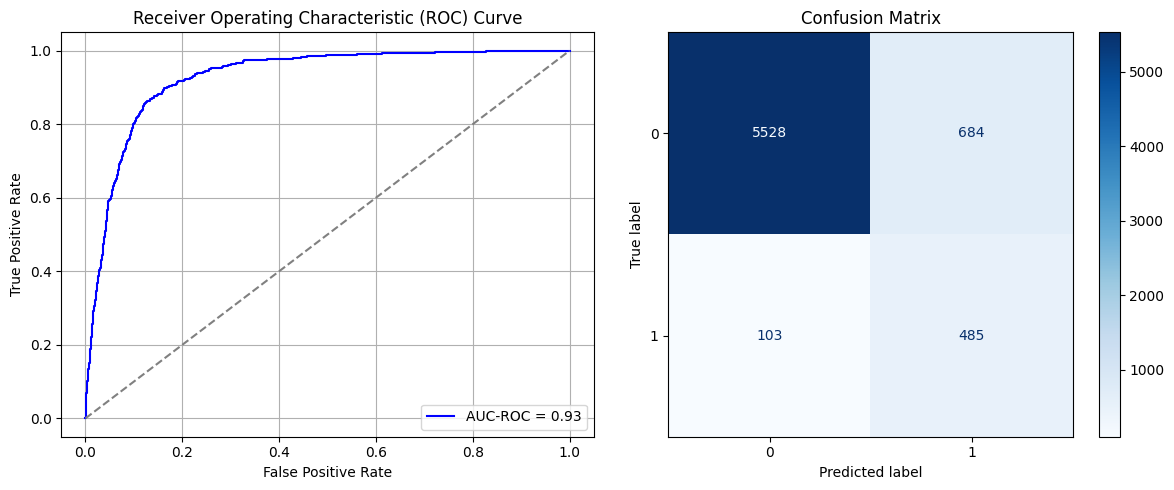

Best threshold based on F1-score: 0.9858218431472778
False Negative Rate: 0.17517006802721088
Time elapsed (performance): 0.7166268230000696
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7879 - loss: 0.5526 - val_AUC: 0.8877 - val_loss: 0.4273
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8838 - loss: 0.4307 - val_AUC: 0.8946 - val_loss: 0.4115
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8924 - loss: 0.4126 - val_AUC: 0.9005 - val_loss: 0.3961
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8991 - loss: 0.3987 - val_AUC: 0.9056 - val_loss: 0.3883
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9060 - loss: 0.3846 - val_AUC: 0.9091 - val_loss: 0.3782
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9114 - loss: 0.3734 - val_AUC: 0.9126 - val_loss: 0.3702
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9115 - loss: 0.3706 - val_AUC: 0.9129 - val_loss: 0.3741
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9148 - loss: 0.3658 - val_AUC: 0.9137 - val_loss: 0.3765
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

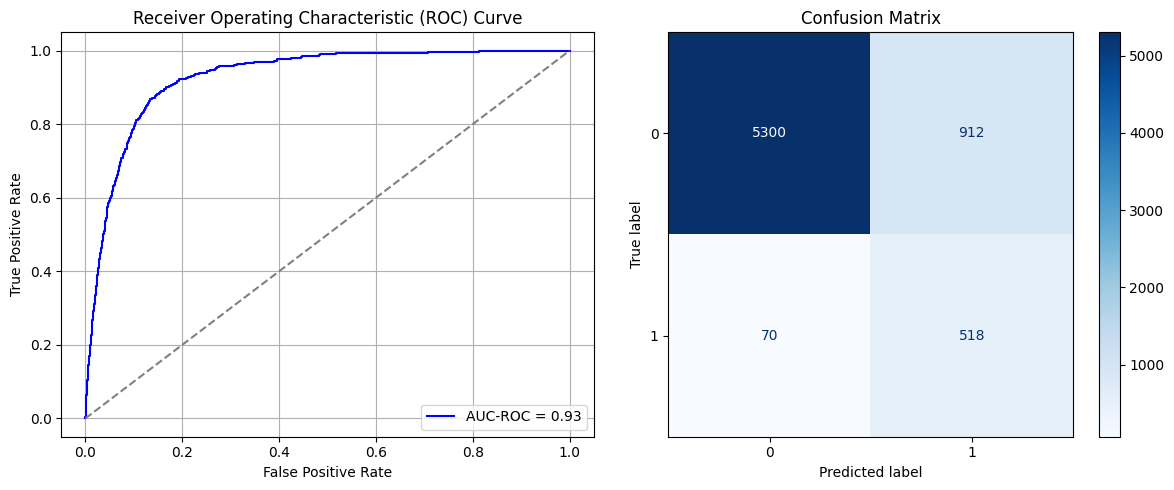

Best threshold based on F1-score: 0.7422081828117371
False Negative Rate: 0.11904761904761904
Time elapsed (performance): 0.7111772279999968
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7790 - loss: 0.5598 - val_AUC: 0.8860 - val_loss: 0.4299
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8802 - loss: 0.4348 - val_AUC: 0.8920 - val_loss: 0.4166
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8913 - loss: 0.4142 - val_AUC: 0.8980 - val_loss: 0.4017
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8960 - loss: 0.4047 - val_AUC: 0.9035 - val_loss: 0.3965
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9042 - loss: 0.3887 - val_AUC: 0.9079 - val_loss: 0.3808
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9065 - loss: 0.3830 - val_AUC: 0.9111 - val_loss: 0.3735
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9115 - loss: 0.3717 - val_AUC: 0.9145 - val_loss: 0.3645
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9093 - loss: 0.3743 - val_AUC: 0.9145 - val_loss: 0.3714
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9260951482975677
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      6212
           1       0.35      0.89      0.50       588

    accuracy                           0.85      6800
   macro avg       0.67      0.87      0.70      6800
weighted avg       0.93      0.85      0.87      6800

FPR 0.15856406954282035 TPR: 0.891156462585034 FNR: 0.10884353741496598 TNR: 0.8414359304571797


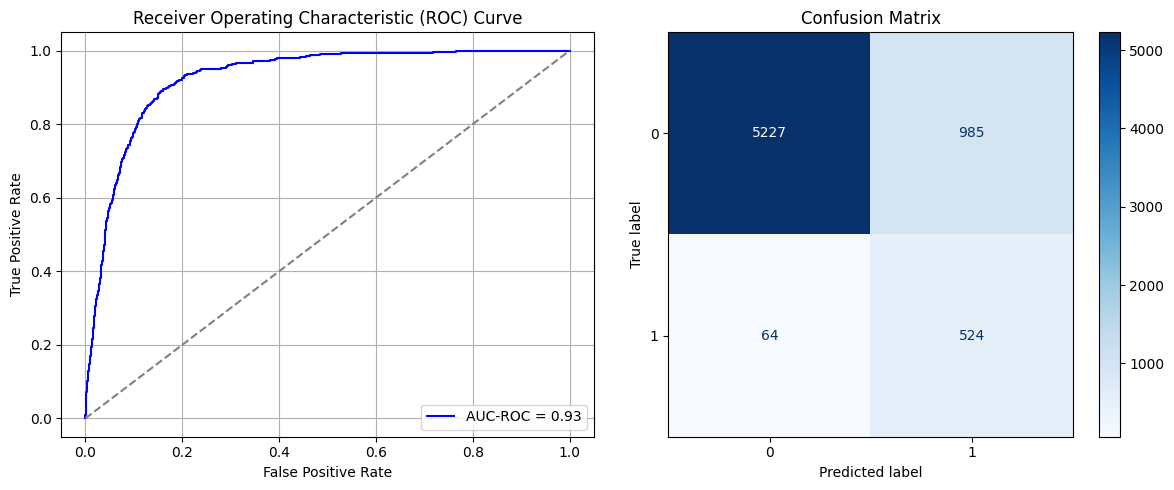

Best threshold based on F1-score: 0.7607479691505432
False Negative Rate: 0.10884353741496598
Time elapsed (performance): 0.7122181600000204
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7998 - loss: 0.5440 - val_AUC: 0.8872 - val_loss: 0.4590
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8778 - loss: 0.4398 - val_AUC: 0.8916 - val_loss: 0.4378
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8857 - loss: 0.4231 - val_AUC: 0.8977 - val_loss: 0.4005
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8950 - loss: 0.4049 - val_AUC: 0.9043 - val_loss: 0.3904
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9032 - loss: 0.3884 - val_AUC: 0.9085 - val_loss: 0.3755
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9052 - loss: 0.3831 - val_AUC: 0.9103 - val_loss: 0.3825
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9092 - loss: 0.3746 - val_AUC: 0.9140 - val_loss: 0.3651
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9126 - loss: 0.3654 - val_AUC: 0.9167 - val_loss: 0.3581
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

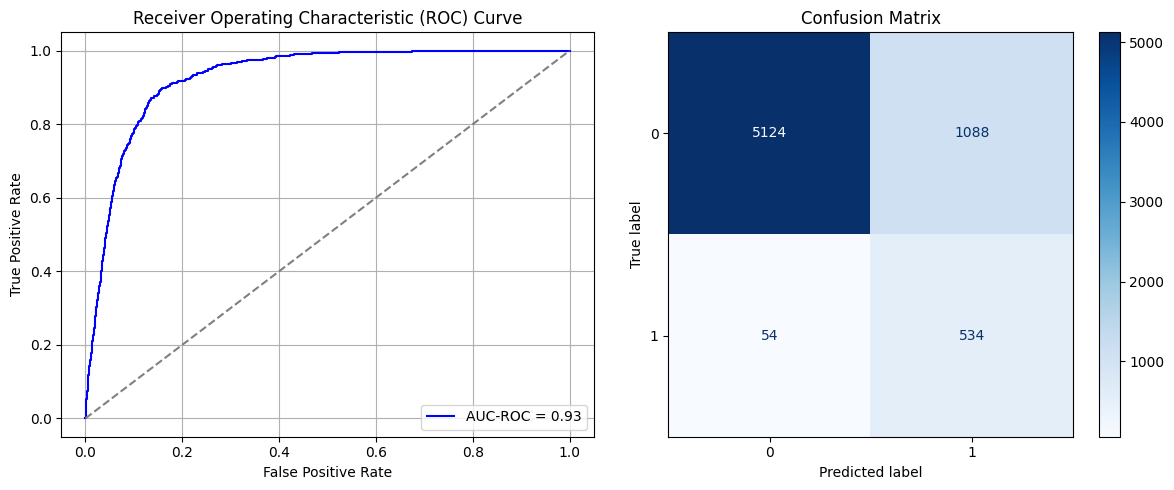

Best threshold based on F1-score: 0.7839525938034058
False Negative Rate: 0.09183673469387756
Time elapsed (performance): 0.7245067110000036
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7800 - loss: 0.5589 - val_AUC: 0.8886 - val_loss: 0.4223
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8874 - loss: 0.4236 - val_AUC: 0.8936 - val_loss: 0.4104
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8917 - loss: 0.4123 - val_AUC: 0.8990 - val_loss: 0.3987
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8973 - loss: 0.4023 - val_AUC: 0.9038 - val_loss: 0.3941
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8972 - loss: 0.4006 - val_AUC: 0.9085 - val_loss: 0.3766
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9036 - loss: 0.3878 - val_AUC: 0.9121 - val_loss: 0.3726
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9100 - loss: 0.3759 - val_AUC: 0.9141 - val_loss: 0.3680
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9105 - loss: 0.3735 - val_AUC: 0.9152 - val_loss: 0.3620
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9303348029488678
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      6212
           1       0.35      0.88      0.51       588

    accuracy                           0.85      6800
   macro avg       0.67      0.87      0.71      6800
weighted avg       0.93      0.85      0.88      6800

FPR 0.1522858982614295 TPR: 0.8843537414965986 FNR: 0.11564625850340136 TNR: 0.8477141017385705


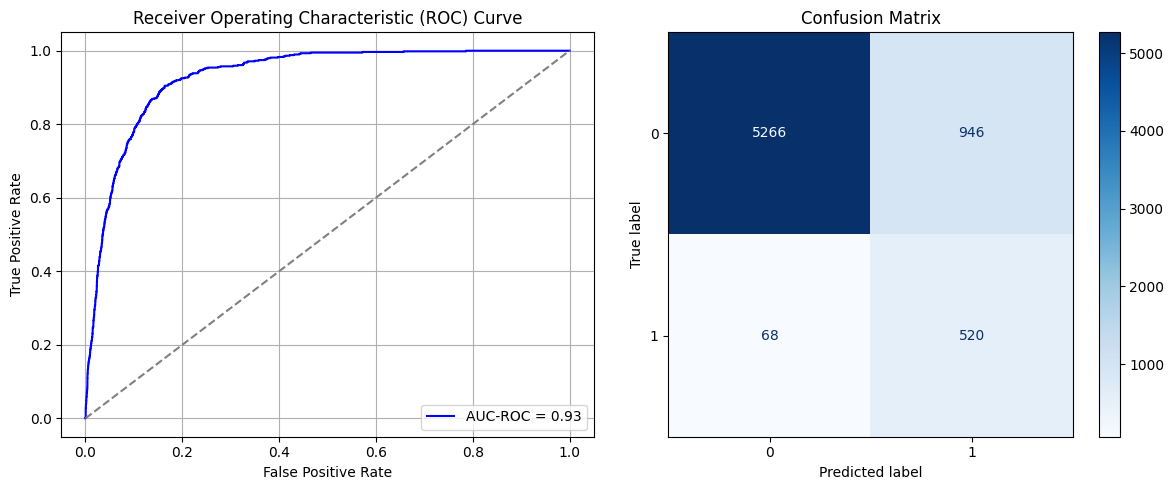

Best threshold based on F1-score: 0.9872391223907471
False Negative Rate: 0.11564625850340136
Time elapsed (performance): 0.7200371950000317
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7826 - loss: 0.5577 - val_AUC: 0.8868 - val_loss: 0.4273
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8865 - loss: 0.4254 - val_AUC: 0.8932 - val_loss: 0.4115
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8949 - loss: 0.4075 - val_AUC: 0.9001 - val_loss: 0.3984
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8983 - loss: 0.4000 - val_AUC: 0.9036 - val_loss: 0.3894
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9062 - loss: 0.3829 - val_AUC: 0.9066 - val_loss: 0.3825
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9107 - loss: 0.3744 - val_AUC: 0.9118 - val_loss: 0.3734
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9120 - loss: 0.3685 - val_AUC: 0.9139 - val_loss: 0.3670
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9118 - loss: 0.3687 - val_AUC: 0.9162 - val_loss: 0.3595
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9256291859950677
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      6212
           1       0.38      0.83      0.52       588

    accuracy                           0.87      6800
   macro avg       0.68      0.85      0.72      6800
weighted avg       0.93      0.87      0.89      6800

FPR 0.1263683193818416 TPR: 0.8299319727891157 FNR: 0.17006802721088435 TNR: 0.8736316806181584


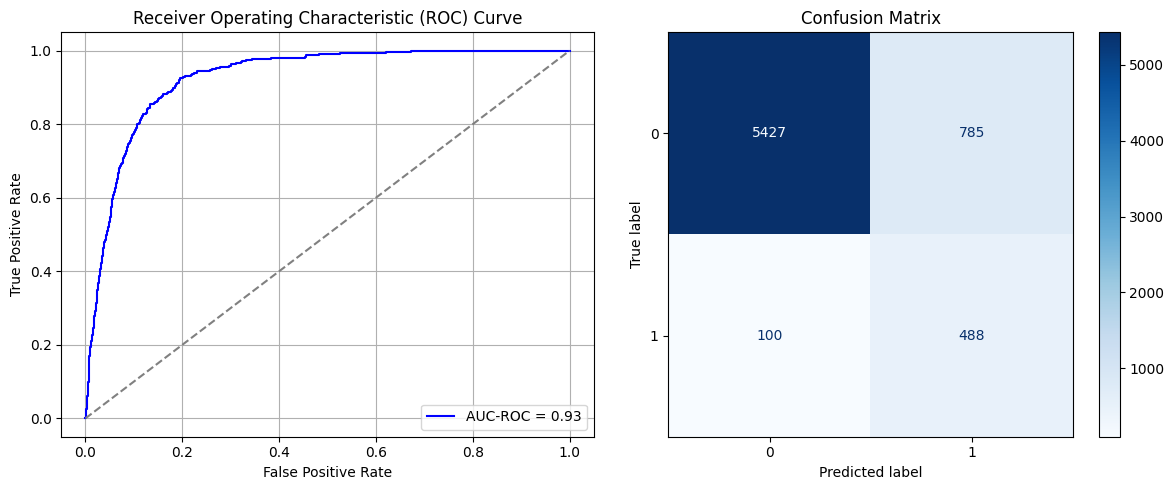

Best threshold based on F1-score: 0.9889661073684692
False Negative Rate: 0.17006802721088435
Time elapsed (performance): 1.0204112410001471
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7903 - loss: 0.5490 - val_AUC: 0.8870 - val_loss: 0.4298
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8873 - loss: 0.4216 - val_AUC: 0.8953 - val_loss: 0.4125
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8899 - loss: 0.4157 - val_AUC: 0.9003 - val_loss: 0.3955
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8937 - loss: 0.4081 - val_AUC: 0.9045 - val_loss: 0.3881
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9033 - loss: 0.3897 - val_AUC: 0.9087 - val_loss: 0.3789
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9051 - loss: 0.3847 - val_AUC: 0.9110 - val_loss: 0.3748
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9093 - loss: 0.3770 - val_AUC: 0.9123 - val_loss: 0.3697
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9111 - loss: 0.3727 - val_AUC: 0.9160 - val_loss: 0.3605
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

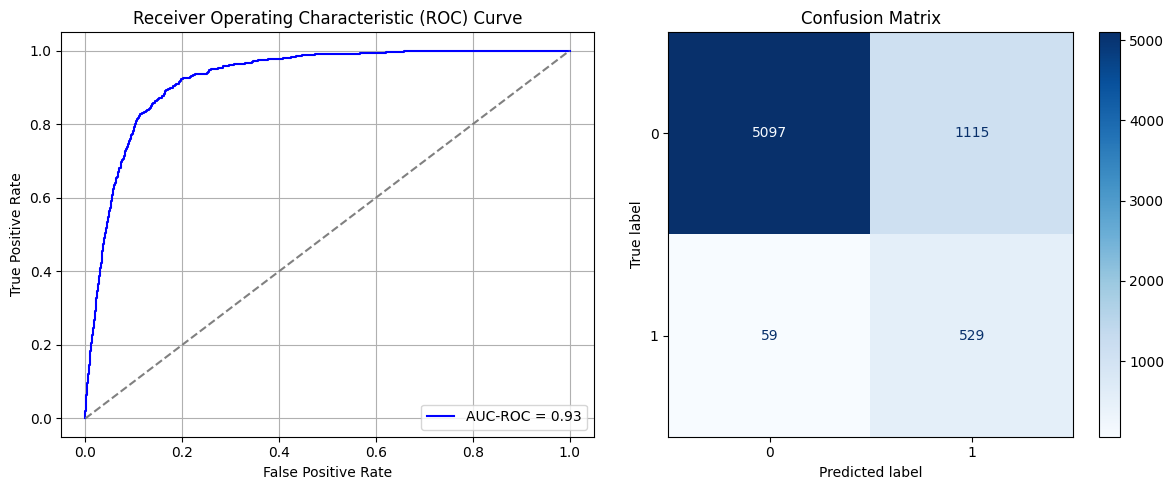

Best threshold based on F1-score: 0.7686997056007385
False Negative Rate: 0.10034013605442177
Time elapsed (performance): 1.067967327000133
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7812 - loss: 0.5568 - val_AUC: 0.8865 - val_loss: 0.4302
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8830 - loss: 0.4295 - val_AUC: 0.8934 - val_loss: 0.4158
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8919 - loss: 0.4120 - val_AUC: 0.8996 - val_loss: 0.4008
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8966 - loss: 0.4027 - val_AUC: 0.9031 - val_loss: 0.3898
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9021 - loss: 0.3917 - val_AUC: 0.9068 - val_loss: 0.3812
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9071 - loss: 0.3816 - val_AUC: 0.9082 - val_loss: 0.3821
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9090 - loss: 0.3763 - val_AUC: 0.9123 - val_loss: 0.3720
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9122 - loss: 0.3698 - val_AUC: 0.9136 - val_loss: 0.3660
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.929274478625964
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      6212
           1       0.39      0.87      0.54       588

    accuracy                           0.87      6800
   macro avg       0.69      0.87      0.73      6800
weighted avg       0.93      0.87      0.89      6800

FPR 0.12926593689632968 TPR: 0.8673469387755102 FNR: 0.1326530612244898 TNR: 0.8707340631036703


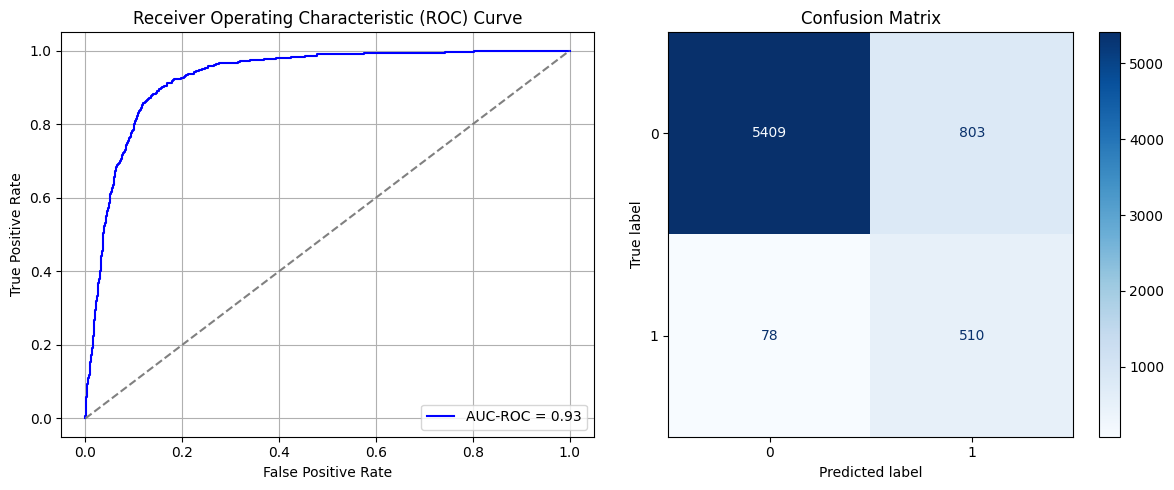

Best threshold based on F1-score: 0.7408256530761719
False Negative Rate: 0.1326530612244898
Time elapsed (performance): 1.2333547749999525
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7893 - loss: 0.5512 - val_AUC: 0.8901 - val_loss: 0.4268
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8835 - loss: 0.4295 - val_AUC: 0.8982 - val_loss: 0.4006
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8931 - loss: 0.4111 - val_AUC: 0.9030 - val_loss: 0.3915
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9001 - loss: 0.3959 - val_AUC: 0.9092 - val_loss: 0.3829
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9068 - loss: 0.3821 - val_AUC: 0.9114 - val_loss: 0.3720
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9091 - loss: 0.3775 - val_AUC: 0.9160 - val_loss: 0.3608
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9164 - loss: 0.3624 - val_AUC: 0.9191 - val_loss: 0.3558
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9143 - loss: 0.3654 - val_AUC: 0.9212 - val_loss: 0.3550
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9292293060173199
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      6212
           1       0.33      0.90      0.48       588

    accuracy                           0.83      6800
   macro avg       0.66      0.86      0.69      6800
weighted avg       0.93      0.83      0.86      6800

FPR 0.17401802962009014 TPR: 0.903061224489796 FNR: 0.09693877551020408 TNR: 0.8259819703799098


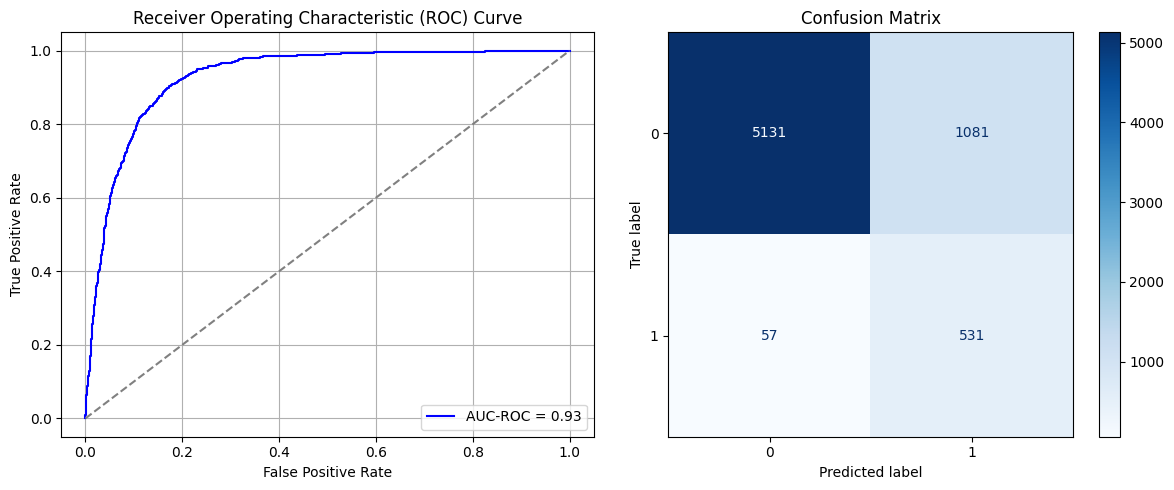

Best threshold based on F1-score: 0.8031448125839233
False Negative Rate: 0.09693877551020408
Time elapsed (performance): 1.0338116220000302
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7876 - loss: 0.5516 - val_AUC: 0.8850 - val_loss: 0.4290
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8839 - loss: 0.4271 - val_AUC: 0.8926 - val_loss: 0.4152
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8904 - loss: 0.4148 - val_AUC: 0.8990 - val_loss: 0.3982
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8970 - loss: 0.4018 - val_AUC: 0.9035 - val_loss: 0.3917
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9011 - loss: 0.3930 - val_AUC: 0.9083 - val_loss: 0.3767
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9065 - loss: 0.3819 - val_AUC: 0.9109 - val_loss: 0.3707
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9102 - loss: 0.3739 - val_AUC: 0.9129 - val_loss: 0.3758
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9160 - loss: 0.3622 - val_AUC: 0.9158 - val_loss: 0.3665
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9055629656885291
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      6212
           1       0.29      0.86      0.43       588

    accuracy                           0.80      6800
   macro avg       0.64      0.83      0.66      6800
weighted avg       0.92      0.80      0.84      6800

FPR 0.20235028976175146 TPR: 0.8605442176870748 FNR: 0.13945578231292516 TNR: 0.7976497102382485


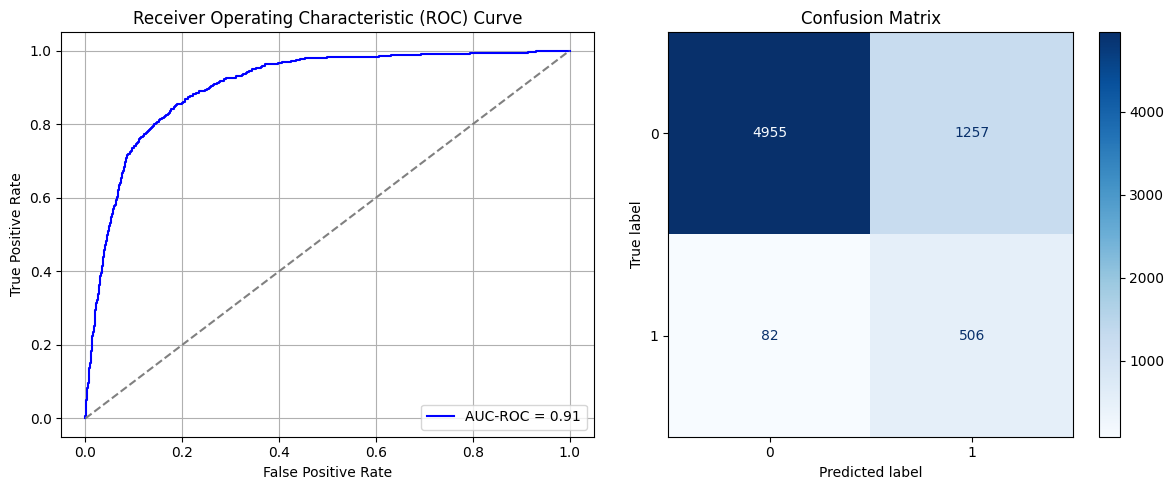

Best threshold based on F1-score: 0.752259373664856
False Negative Rate: 0.13945578231292516
Time elapsed (performance): 1.0222353439999097


In [48]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_SRS_ROS = data_S_SRS_ROS.iloc[:, :-1]
    y_S_SRS_ROS = data_S_SRS_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS_ROS, y_S_SRS_ROS, test_size=0.20, random_state=0)
    model_SRS_ROS = create_dnn_model(X_S_train.shape[1])
    result_SRS_ROS = train_and_evaluate(model_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS_ROS = Transductive_TL(model_SRS_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS_ROS)
    FPR.append(result_TL_SRS_ROS[0])
    TNR.append(result_TL_SRS_ROS[1])
    FNR.append(result_TL_SRS_ROS[2])
    TPR.append(result_TL_SRS_ROS[3])
    TL_time.append(result_TL_SRS_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [49]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    48.697112  0.110109  0.889891  0.175170  0.824830     0.716627
1    43.170035  0.146813  0.853187  0.119048  0.880952     0.711177
2    45.864766  0.158564  0.841436  0.108844  0.891156     0.712218
3    45.842505  0.175145  0.824855  0.091837  0.908163     0.724507
4    46.020708  0.152286  0.847714  0.115646  0.884354     0.720037
5    45.273073  0.126368  0.873632  0.170068  0.829932     1.020411
6    50.607551  0.179491  0.820509  0.100340  0.899660     1.067967
7    49.633984  0.129266  0.870734  0.132653  0.867347     1.233355
8    44.582456  0.174018  0.825982  0.096939  0.903061     1.033812
9    46.100403  0.202350  0.797650  0.139456  0.860544     1.022235


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=10$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}= 11.05 \approx 11$, so we take $k=10$.

In [50]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

4433
31960


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7825 - loss: 0.5556 - val_AUC: 0.8890 - val_loss: 0.4253
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8825 - loss: 0.4306 - val_AUC: 0.8983 - val_loss: 0.4005
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8947 - loss: 0.4057 - val_AUC: 0.9034 - val_loss: 0.3874
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9026 - loss: 0.3899 - val_AUC: 0.9090 - val_loss: 0.3807
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9083 - loss: 0.3788 - val_AUC: 0.9112 - val_loss: 0.3710
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9118 - loss: 0.3696 - val_AUC: 0.9140 - val_loss: 0.3650
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9105 - loss: 0.3712 - val_AUC: 0.9157 - val_loss: 0.3606
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9150 - loss: 0.3617 - val_AUC: 0.9165 - val_loss: 0.3629
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

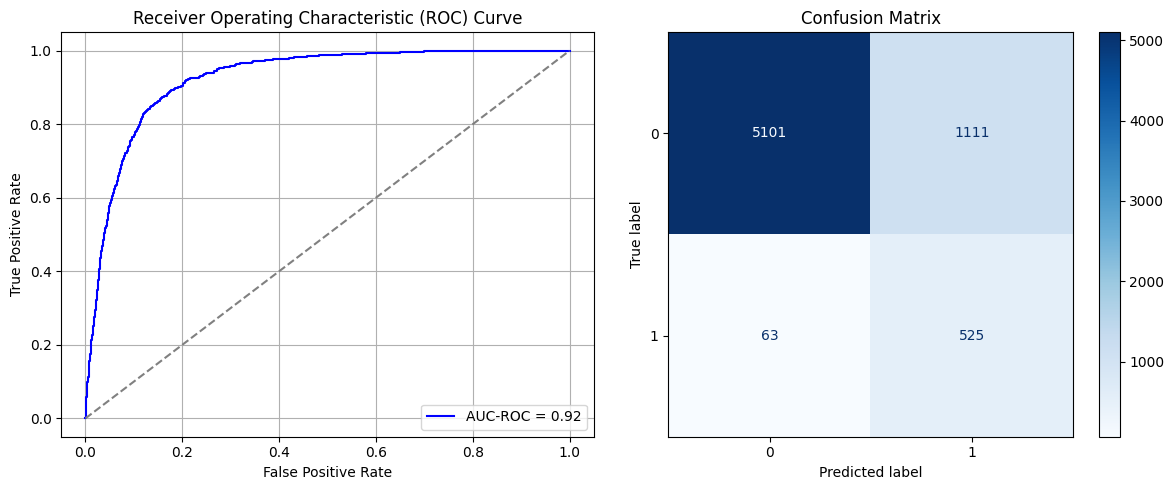

Best threshold based on F1-score: 0.9855529069900513
False Negative Rate: 0.10714285714285714
Time elapsed (performance): 0.7323206439998557
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7964 - loss: 0.5482 - val_AUC: 0.8830 - val_loss: 0.4338
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8819 - loss: 0.4345 - val_AUC: 0.8890 - val_loss: 0.4344
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8870 - loss: 0.4217 - val_AUC: 0.8951 - val_loss: 0.4062
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8943 - loss: 0.4069 - val_AUC: 0.8994 - val_loss: 0.4136
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9050 - loss: 0.3856 - val_AUC: 0.9060 - val_loss: 0.3853
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9058 - loss: 0.3831 - val_AUC: 0.9083 - val_loss: 0.3813
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9111 - loss: 0.3707 - val_AUC: 0.9115 - val_loss: 0.3715
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9118 - loss: 0.3699 - val_AUC: 0.9121 - val_loss: 0.3694
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

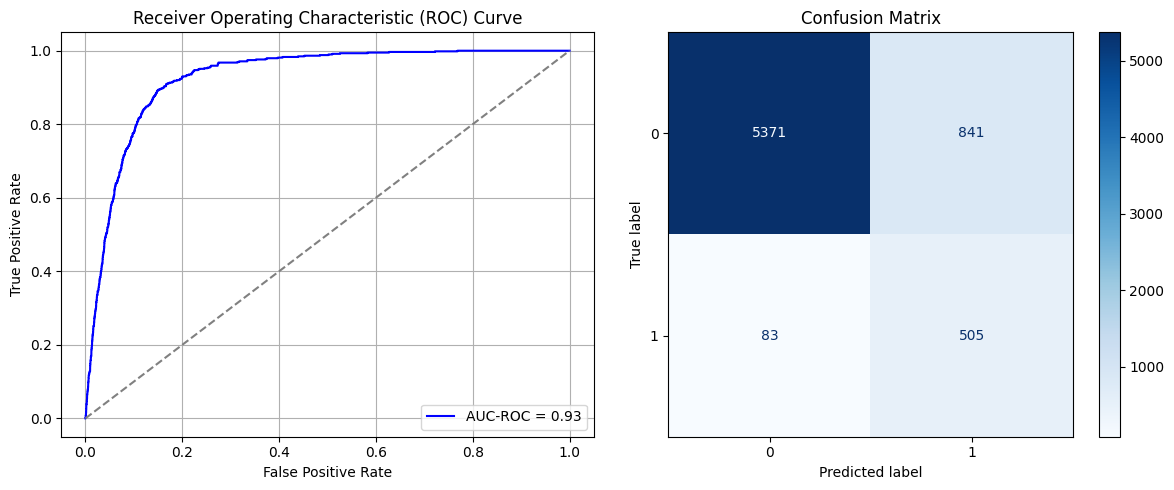

Best threshold based on F1-score: 0.9886044263839722
False Negative Rate: 0.141156462585034
Time elapsed (performance): 1.2227055280000059
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7840 - loss: 0.5522 - val_AUC: 0.8904 - val_loss: 0.4194
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8872 - loss: 0.4225 - val_AUC: 0.8979 - val_loss: 0.4037
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8927 - loss: 0.4114 - val_AUC: 0.9020 - val_loss: 0.3928
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9009 - loss: 0.3953 - val_AUC: 0.9036 - val_loss: 0.3893
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9048 - loss: 0.3867 - val_AUC: 0.9116 - val_loss: 0.3715
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9075 - loss: 0.3803 - val_AUC: 0.9146 - val_loss: 0.3645
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9089 - loss: 0.3757 - val_AUC: 0.9166 - val_loss: 0.3639
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9114 - loss: 0.3717 - val_AUC: 0.9188 - val_loss: 0.3584
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

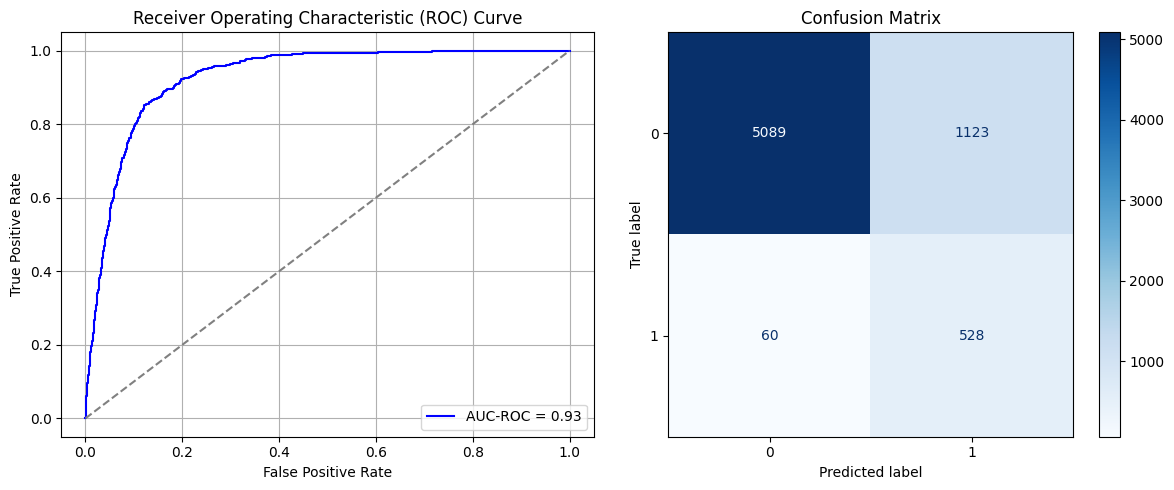

Best threshold based on F1-score: 0.7834466099739075
False Negative Rate: 0.10204081632653061
Time elapsed (performance): 1.1859405259999676
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7787 - loss: 0.5564 - val_AUC: 0.8861 - val_loss: 0.4296
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8818 - loss: 0.4322 - val_AUC: 0.8930 - val_loss: 0.4311
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8899 - loss: 0.4171 - val_AUC: 0.8976 - val_loss: 0.4060
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8946 - loss: 0.4065 - val_AUC: 0.9021 - val_loss: 0.4039
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9007 - loss: 0.3946 - val_AUC: 0.9076 - val_loss: 0.3888
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9078 - loss: 0.3800 - val_AUC: 0.9102 - val_loss: 0.3793
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9112 - loss: 0.3731 - val_AUC: 0.9147 - val_loss: 0.3641
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9113 - loss: 0.3707 - val_AUC: 0.9161 - val_loss: 0.3687
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

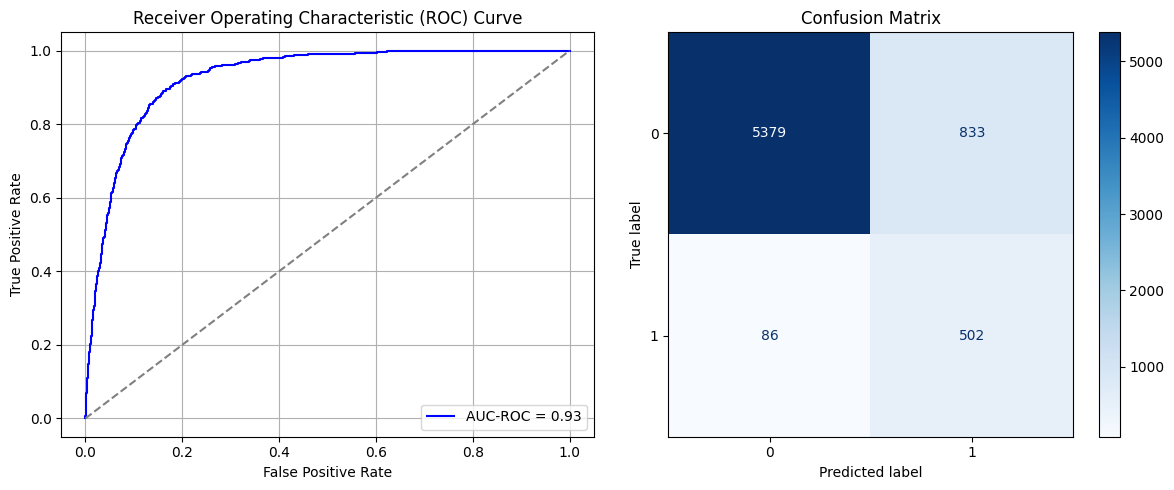

Best threshold based on F1-score: 0.7344812750816345
False Negative Rate: 0.14625850340136054
Time elapsed (performance): 0.7438255330000629
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7889 - loss: 0.5542 - val_AUC: 0.8929 - val_loss: 0.4174
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8826 - loss: 0.4318 - val_AUC: 0.8966 - val_loss: 0.4098
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8884 - loss: 0.4196 - val_AUC: 0.8990 - val_loss: 0.3979
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8918 - loss: 0.4115 - val_AUC: 0.9037 - val_loss: 0.3888
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8974 - loss: 0.4008 - val_AUC: 0.9050 - val_loss: 0.3846
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9035 - loss: 0.3882 - val_AUC: 0.9103 - val_loss: 0.3787
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9077 - loss: 0.3796 - val_AUC: 0.9123 - val_loss: 0.3679
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9103 - loss: 0.3728 - val_AUC: 0.9151 - val_loss: 0.3618
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9302474692388224
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      6212
           1       0.36      0.87      0.51       588

    accuracy                           0.85      6800
   macro avg       0.67      0.86      0.71      6800
weighted avg       0.93      0.85      0.88      6800

FPR 0.14810045074050227 TPR: 0.8741496598639455 FNR: 0.12585034013605442 TNR: 0.8518995492594977


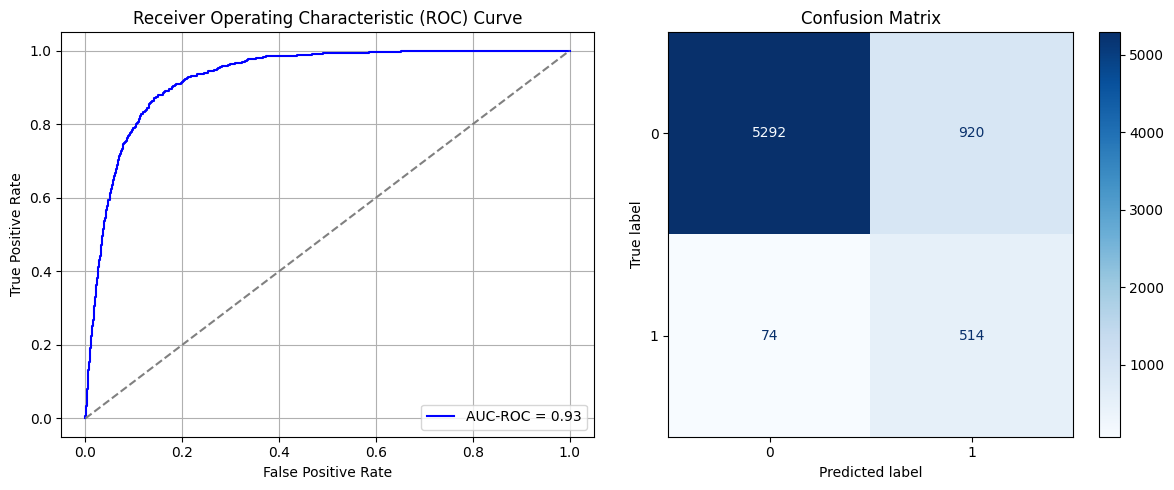

Best threshold based on F1-score: 0.7315804958343506
False Negative Rate: 0.12585034013605442
Time elapsed (performance): 1.0130178859999432
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7823 - loss: 0.5605 - val_AUC: 0.8859 - val_loss: 0.4335
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8808 - loss: 0.4387 - val_AUC: 0.8924 - val_loss: 0.4174
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8902 - loss: 0.4181 - val_AUC: 0.8982 - val_loss: 0.4049
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8984 - loss: 0.4011 - val_AUC: 0.9045 - val_loss: 0.3873
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9031 - loss: 0.3896 - val_AUC: 0.9072 - val_loss: 0.3812
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9109 - loss: 0.3739 - val_AUC: 0.9099 - val_loss: 0.3732
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9090 - loss: 0.3760 - val_AUC: 0.9136 - val_loss: 0.3685
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9139 - loss: 0.3641 - val_AUC: 0.9154 - val_loss: 0.3634
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-29-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.9256379467434108
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      6212
           1       0.37      0.86      0.52       588

    accuracy                           0.86      6800
   macro avg       0.68      0.86      0.72      6800
weighted avg       0.93      0.86      0.89      6800

FPR 0.13715389568576947 TPR: 0.8571428571428572 FNR: 0.14285714285714285 TNR: 0.8628461043142306


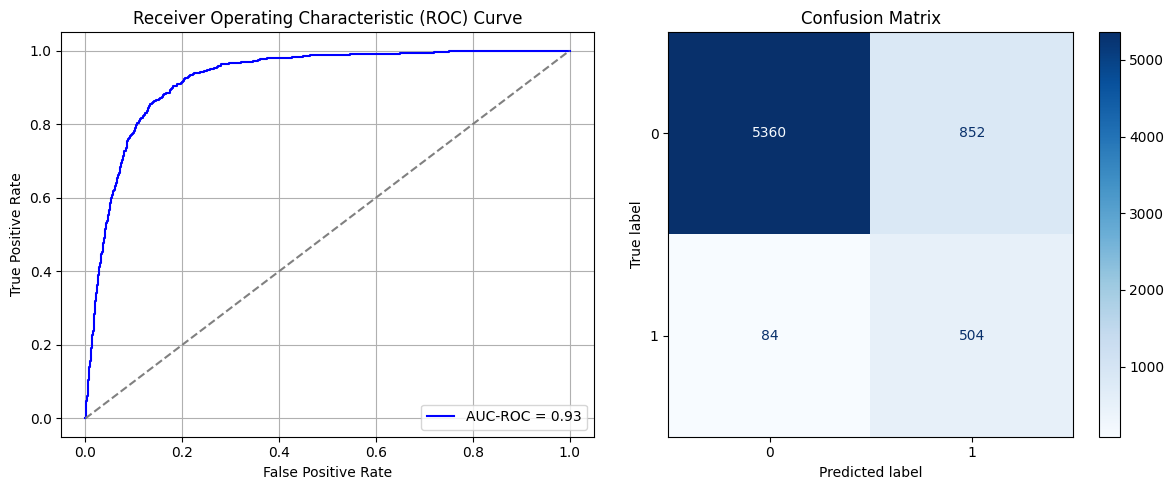

Best threshold based on F1-score: 0.9927830100059509
False Negative Rate: 0.14285714285714285
Time elapsed (performance): 1.0005865470000117
Epoch 1/10


<ipython-input-30-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7785 - loss: 0.5570 - val_AUC: 0.8872 - val_loss: 0.4260
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8838 - loss: 0.4299 - val_AUC: 0.8934 - val_loss: 0.4174
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8929 - loss: 0.4105 - val_AUC: 0.9008 - val_loss: 0.3994
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8987 - loss: 0.3990 - val_AUC: 0.9048 - val_loss: 0.3907
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9035 - loss: 0.3900 - val_AUC: 0.9097 - val_loss: 0.3819
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9103 - loss: 0.3749 - val_AUC: 0.9123 - val_loss: 0.3702
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9115 - loss: 0.3719 - val_AUC: 0.9143 - val_loss: 0.3706
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9151 - loss: 0.3652 - val_AUC: 0.9155 - val_loss: 0.3616
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

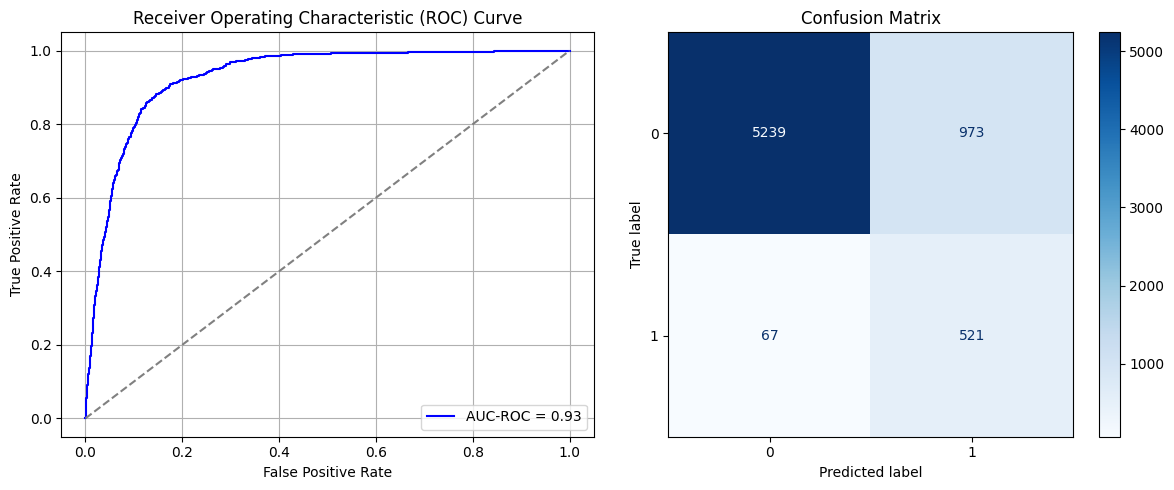

Best threshold based on F1-score: 0.808456540107727
False Negative Rate: 0.11394557823129252
Time elapsed (performance): 0.7389254120000714
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7917 - loss: 0.5499 - val_AUC: 0.8882 - val_loss: 0.4350
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8848 - loss: 0.4317 - val_AUC: 0.8962 - val_loss: 0.4201
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8956 - loss: 0.4073 - val_AUC: 0.9039 - val_loss: 0.3907
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9024 - loss: 0.3923 - val_AUC: 0.9102 - val_loss: 0.3764
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9069 - loss: 0.3823 - val_AUC: 0.9125 - val_loss: 0.3707
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9126 - loss: 0.3691 - val_AUC: 0.9144 - val_loss: 0.3679
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9149 - loss: 0.3639 - val_AUC: 0.9173 - val_loss: 0.3614
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9148 - loss: 0.3635 - val_AUC: 0.9184 - val_loss: 0.3616
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

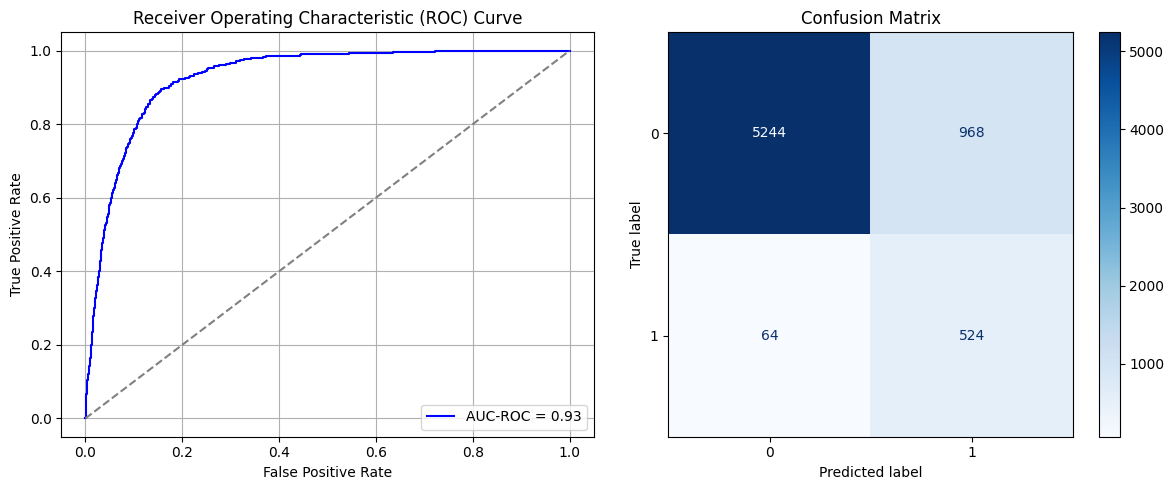

Best threshold based on F1-score: 0.7556896805763245
False Negative Rate: 0.10884353741496598
Time elapsed (performance): 0.7258119880002596
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7891 - loss: 0.5552 - val_AUC: 0.8851 - val_loss: 0.4351
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8832 - loss: 0.4307 - val_AUC: 0.8936 - val_loss: 0.4214
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8882 - loss: 0.4187 - val_AUC: 0.8978 - val_loss: 0.4013
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8975 - loss: 0.4012 - val_AUC: 0.9007 - val_loss: 0.4031
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8980 - loss: 0.3996 - val_AUC: 0.9038 - val_loss: 0.3881
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9029 - loss: 0.3897 - val_AUC: 0.9081 - val_loss: 0.3781
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9032 - loss: 0.3866 - val_AUC: 0.9103 - val_loss: 0.3954
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9060 - loss: 0.3799 - val_AUC: 0.9127 - val_loss: 0.3691
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

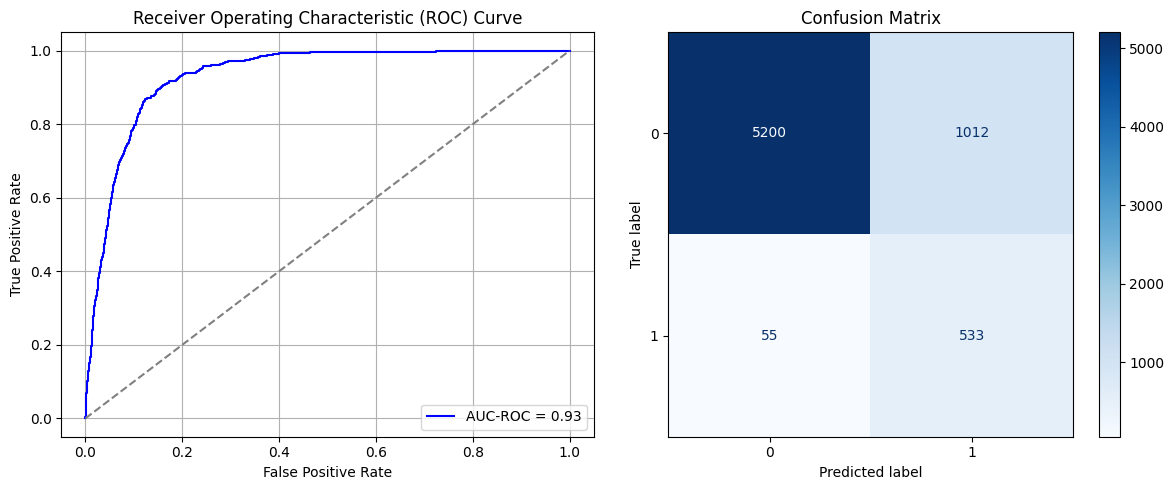

Best threshold based on F1-score: 0.7842265367507935
False Negative Rate: 0.0935374149659864
Time elapsed (performance): 1.01532161599971
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7833 - loss: 0.5512 - val_AUC: 0.8911 - val_loss: 0.4194
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8842 - loss: 0.4284 - val_AUC: 0.8980 - val_loss: 0.4051
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8915 - loss: 0.4136 - val_AUC: 0.9023 - val_loss: 0.3959
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8943 - loss: 0.4064 - val_AUC: 0.9046 - val_loss: 0.3924
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9003 - loss: 0.3953 - val_AUC: 0.9086 - val_loss: 0.3909
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9054 - loss: 0.3846 - val_AUC: 0.9105 - val_loss: 0.3728
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9074 - loss: 0.3806 - val_AUC: 0.9132 - val_loss: 0.3712
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9069 - loss: 0.3805 - val_AUC: 0.9156 - val_loss: 0.3638
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

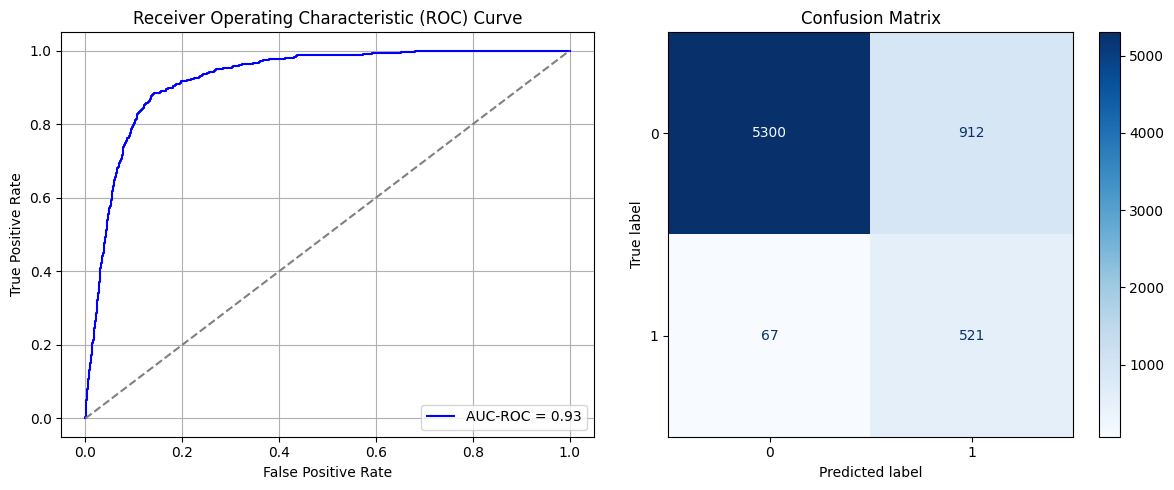

Best threshold based on F1-score: 0.7228222489356995
False Negative Rate: 0.11394557823129252
Time elapsed (performance): 1.0262277189999622


In [51]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = 10
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_S_min_ros = pd.DataFrame()
    data_S_min_ros = data_S_minority.iloc[Row]
    data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_Sy_ROS = data_S_Sy_ROS.iloc[:, :-1]
    y_S_Sy_ROS = data_S_Sy_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy_ROS, y_S_Sy_ROS, test_size=0.20, random_state=0)
    model_Sy_ROS = create_dnn_model(X_S_train.shape[1])
    result_Sy_ROS = train_and_evaluate(model_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy_ROS = Transductive_TL(model_Sy_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_Sy_ROS)
    FPR.append(result_TL_Sy_ROS[0])
    TNR.append(result_TL_Sy_ROS[1])
    FNR.append(result_TL_Sy_ROS[2])
    TPR.append(result_TL_Sy_ROS[3])
    TL_time.append(result_TL_Sy_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [52]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    48.159085  0.178847  0.821153  0.107143  0.892857     0.732321
1    44.188626  0.135383  0.864617  0.141156  0.858844     1.222706
2    46.333122  0.180779  0.819221  0.102041  0.897959     1.185941
3    44.663314  0.134095  0.865905  0.146259  0.853741     0.743826
4    43.780980  0.148100  0.851900  0.125850  0.874150     1.013018
5    42.753659  0.137154  0.862846  0.142857  0.857143     1.000587
6    46.369082  0.156632  0.843368  0.113946  0.886054     0.738925
7    45.897885  0.155827  0.844173  0.108844  0.891156     0.725812
8    47.336240  0.162910  0.837090  0.093537  0.906463     1.015322
9    47.935256  0.146813  0.853187  0.113946  0.886054     1.026228
